<h1 style="border-width:2px; border-style:solid; border-color:blue; background-color:#367395; text-align: center; text-shadow: 0px 0px 3px red; padding-bottom: 2em; padding-top: 1em;">INSURANCE CROSS-SELLING PREDICTION<br>Classification Project</h1>

About the project:

- Dataset from: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction

- In this fictional context, the challenge is to create an intelligent method to select the potential customers most likely to buy a new product from an insurance company, in order to maximize the results of the sales team and, consequently, the total invoicing revenue.

- For the present research, the available dataset contains the results of a poll over 381 thousand actual clients of a health insurance contract, who informed if they were interested in the new vehicle insurance. Besides that, the sales team will work with 20 thousand people selected from a group of 127 thousand new potential clients.

Version 2: 2024.09.19

# 0. INITIAL PROCEDURES

## 0.1 Imports

In [1]:
import pandas                          as pd
import numpy                           as np
import pickle
import json
import optuna
from   matplotlib       import pyplot      as plt
import scikitplot                          as skplt
import xgboost                             as xgb
from   boruta           import BorutaPy
from   lightgbm         import LGBMClassifier
import seaborn                                  as sns
from   scipy            import stats            as ss
from   sklearn          import preprocessing    as pp
from   sklearn          import model_selection  as ms
from   sklearn          import ensemble         as en
from   sklearn          import neighbors        as nh
from   sklearn          import linear_model     as lm
from   sklearn          import metrics          as mt
import category_encoders                        as ce
from   IPython.display  import Image
from   imblearn.combine import SMOTETomek
from   sklearn.metrics.pairwise  import rbf_kernel
from   sklearn.neighbors         import KNeighborsClassifier
from   mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from   mlxtend.feature_selection import SequentialFeatureSelector as SFS
from   sklearn.metrics           import precision_score, recall_score, f1_score
from   sklearn.metrics           import balanced_accuracy_score, accuracy_score, silhouette_score
from   sklearn.metrics           import mutual_info_score
from   sklearn.svm               import LinearSVC, SVC
from   sklearn.pipeline          import make_pipeline
from   sklearn.cluster           import DBSCAN, KMeans


c:\Users\Manoel\miniconda3\envs\healthins2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2 Load Dataset

In [2]:
# Kaggle dataset:
# https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.sample(8).T

,305852,79038,190590,41382,117514,32339,111108,264096
id,305853,79039,190591,41383,117515,32340,111109,264097
Gender,Female,Male,Female,Male,Male,Male,Female,Male
Age,44,22,24,54,35,52,20,68
Driving_License,1,1,1,1,1,1,1,1
Region_Code,12.0,24.0,2.0,48.0,28.0,8.0,36.0,8.0
Previously_Insured,1,0,1,0,1,0,1,0
Vehicle_Age,1-2 Year,< 1 Year,< 1 Year,1-2 Year,1-2 Year,1-2 Year,< 1 Year,1-2 Year
Vehicle_Damage,No,Yes,No,Yes,No,Yes,Yes,Yes
Annual_Premium,30413.0,2630.0,24648.0,2630.0,24994.0,57619.0,25660.0,44612.0
Policy_Sales_Channel,26.0,152.0,160.0,124.0,124.0,25.0,160.0,124.0


In [3]:
df_raw.shape

(381109, 12)

# 1. DATA DESCRIPTION

## 1.0. copy data, rename cols

In [4]:
df1 = df_raw.copy()

# Rename Columns (to lowercase)
df1.columns = df1.columns.str.lower()
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.1. Verifying Types & Size & Nunique & NAs

In [5]:
print( 'N# of rows: {}'.format( df1.shape[0] ) )
print( 'N# of cols: {}'.format( df1.shape[1] ) )

N# of rows: 381109
N# of cols: 12


In [6]:
aux = pd.DataFrame( {'cols': df1.columns,
                      'DType': df1.dtypes,
                      'size': df1.shape[0],
                      'nunique': df1.nunique(),
                      'NAs': df1.isna().sum()} )
aux['NA_percent'] = round( aux['NAs'] / aux['size'], 2 )
aux

,cols,DType,size,nunique,NAs,NA_percent
id,id,int64,381109,381109,0,0.0
gender,gender,object,381109,2,0,0.0
age,age,int64,381109,66,0,0.0
driving_license,driving_license,int64,381109,2,0,0.0
region_code,region_code,float64,381109,53,0,0.0
previously_insured,previously_insured,int64,381109,2,0,0.0
vehicle_age,vehicle_age,object,381109,3,0,0.0
vehicle_damage,vehicle_damage,object,381109,2,0,0.0
annual_premium,annual_premium,float64,381109,48838,0,0.0
policy_sales_channel,policy_sales_channel,float64,381109,155,0,0.0


In [7]:
df1.sample(8).T

,207264,107635,235190,246362,14120,284149,304180,257778
id,207265,107636,235191,246363,14121,284150,304181,257779
gender,Female,Female,Male,Female,Female,Female,Male,Female
age,48,22,51,22,71,31,25,64
driving_license,1,1,1,1,1,1,1,1
region_code,29.0,31.0,8.0,12.0,3.0,28.0,15.0,28.0
previously_insured,0,0,0,1,1,0,0,1
vehicle_age,1-2 Year,< 1 Year,1-2 Year,< 1 Year,1-2 Year,1-2 Year,< 1 Year,1-2 Year
vehicle_damage,Yes,No,Yes,No,No,Yes,Yes,No
annual_premium,2630.0,2630.0,46174.0,2630.0,22052.0,41588.0,38878.0,32092.0
policy_sales_channel,124.0,160.0,26.0,152.0,124.0,26.0,151.0,26.0


## 1.2. Split data

In [8]:
#............... Split dataframe to T.V.T.
# T.V.T: Train, Validation, Test
X = df1.drop( 'response', axis=1 )
y = df1['response'].copy()

# Select ~127k potential clients to run final performance test
x_train_val, x_test, y_train_val, y_test = ms.train_test_split( X, y, random_state=0, test_size=0.3333 )

# divide the "train_val" in train and validation sets.
x_train, x_validation, y_train, y_validation = ms.train_test_split( x_train_val, y_train_val, random_state=0, test_size=0.20 )

# df1 = train + validation
df1 = x_train_val.copy()
df1['response'] = y_train_val

In [9]:
(df_raw.shape, df1.shape, x_train.shape, x_validation.shape , x_test.shape)

((381109, 12), (254085, 12), (203268, 11), (50817, 11), (127024, 11))

## 1.3. Descriptive Statistics

### 1.3.1 Separete Features

In [10]:
# Manually separate numerical features (after meditation...)
num_feat = [ 'id', 'age', 'annual_premium', 'vintage' ]
num_attributes = df1.loc[:, num_feat].copy()

# Manually separete target variable(s)
target_feat = [ 'response' ]

# Manually separate other features (ex: data, id, ...)
other_feat = [  ]

# Categorical features: all the others
cat_feat = []
for a in df1.columns:
    if a in num_feat:
        #print(a)
        continue
    if a in target_feat:
        continue
    if a in other_feat:
        continue
    cat_feat.append(a)
cat_attributes = df1.loc[:, cat_feat].copy()

In [11]:
# Numerical Features: [ 'id', 'age', 'annual_premium', 'vintage' ]
num_attributes.sample(8).T

,244163,101608,265207,223105,107882,204083,224357,41767
id,244164.0,101609.0,265208.0,223106.0,107883.0,204084.0,224358.0,41768.0
age,27.0,22.0,23.0,53.0,22.0,22.0,27.0,45.0
annual_premium,34079.0,25891.0,22356.0,34578.0,35766.0,23251.0,2630.0,2630.0
vintage,191.0,77.0,170.0,120.0,267.0,23.0,244.0,226.0


In [12]:
# Categorical Features: [ gender, driving_license, region_code, previously_insured, 
#                         vehicle_age, vehicle_damage, policy_sales_channel ]
cat_attributes.sample(8).T

,277287,204969,281726,219579,179588,92236,302365,117925
gender,Female,Female,Female,Male,Female,Female,Male,Male
driving_license,1,1,1,1,1,1,1,1
region_code,28.0,11.0,28.0,28.0,3.0,28.0,29.0,28.0
previously_insured,0,1,0,1,0,1,1,1
vehicle_age,> 2 Years,< 1 Year,1-2 Year,1-2 Year,< 1 Year,1-2 Year,< 1 Year,1-2 Year
vehicle_damage,Yes,No,Yes,No,No,No,No,No
policy_sales_channel,163.0,152.0,26.0,124.0,160.0,61.0,152.0,55.0


### 1.3.2 Numerical Features

In [13]:
# DESCRIPTIVE STATISTICS - NUMERICAL ATTRIBUTES
# Dispersion (variance, standard deviation, max, min, range, skew, kurtosis)
# central tendency (mean, median)

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate the metrics
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).round(2).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190728.51,190901.0,109992.44,-0.00,-1.20
1,age,20.0,85.0,65.0,38.82,36.0,15.52,0.67,-0.56
2,annual_premium,2630.0,540165.0,537535.0,30582.78,31687.0,17171.47,1.62,29.83
3,vintage,10.0,299.0,289.0,154.22,154.0,83.71,0.01,-1.20


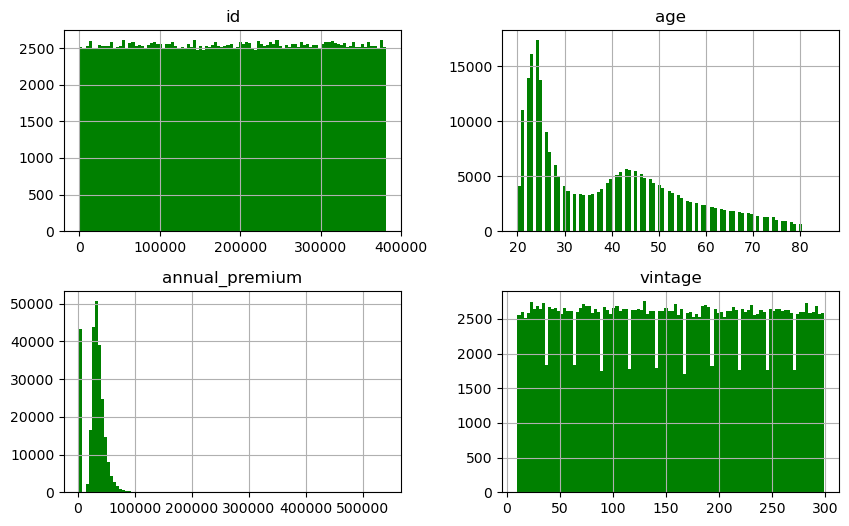

In [14]:
num_attributes.hist( bins=100, figsize=(10,6), color='green' );

### 1.3.3 Categorical Features

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender                    2
driving_license           2
region_code              53
previously_insured        2
vehicle_age               3
vehicle_damage            2
policy_sales_channel    152
dtype: int64

#### (a) GENDER

In [16]:
# Gender: 2 categories - female/male
df1['gender'].value_counts()

gender
Male      137081
Female    117004
Name: count, dtype: int64

#### (b) DRIVING_LICENSE

In [17]:
# Driving License: 2 categories - 0/1
df1['driving_license'].value_counts()

driving_license
1    253541
0       544
Name: count, dtype: int64

#### (c) REGION_CODE

In [18]:
# Region Code: 53 categories...
df1['region_code'].value_counts()

region_code
28.0    70893
8.0     22662
46.0    13266
41.0    12130
15.0     8917
30.0     8160
29.0     7326
50.0     6763
11.0     6173
3.0      6166
36.0     5923
33.0     5093
47.0     4992
35.0     4626
6.0      4131
45.0     3720
37.0     3684
18.0     3524
39.0     3158
48.0     3128
14.0     3038
10.0     2898
21.0     2816
2.0      2691
13.0     2686
7.0      2161
12.0     2128
9.0      2060
27.0     1868
32.0     1848
43.0     1774
17.0     1727
26.0     1725
25.0     1714
24.0     1610
16.0     1368
38.0     1348
0.0      1333
23.0     1309
31.0     1291
20.0     1274
49.0     1218
4.0      1200
34.0     1112
19.0     1012
5.0       867
40.0      854
22.0      839
1.0       654
44.0      539
42.0      383
52.0      176
51.0      129
Name: count, dtype: int64

#### (d) PREVIOUSLY_INSURED

In [19]:
# Previously Insured: 2 categories - 0/1
df1['previously_insured'].value_counts()

previously_insured
0    137568
1    116517
Name: count, dtype: int64

#### (e) VEHICLE_AGE

In [20]:
# Vehicle Age: 3 categories -  <1Y, 1-2Y, >2Y
df1['vehicle_age'].value_counts()

vehicle_age
1-2 Year     133307
< 1 Year     110002
> 2 Years     10776
Name: count, dtype: int64

#### (f) VEHICLE_DAMAGE

In [21]:
# Vehicle Damage: 2 categories - Yes/No
df1['vehicle_damage'].value_counts()

vehicle_damage
Yes    128232
No     125853
Name: count, dtype: int64

#### (g) POLICY SALES CHANNEL

In [22]:
# Policy Sales Channel: 155 categories...
df1['policy_sales_channel'].value_counts()

policy_sales_channel
152.0    90039
26.0     53142
124.0    49047
160.0    14595
156.0     7073
         ...  
50.0         1
144.0        1
34.0         1
143.0        1
149.0        1
Name: count, Length: 152, dtype: int64

### 1.3.4 Target Variable

In [23]:
# Response: 2 categories - 0/1
df1['response'].value_counts()

response
0    223000
1     31085
Name: count, dtype: int64

In [24]:
# Response: 2 categories - 0/1
targ = df1.loc[:, ['response', 'id'] ].groupby('response').count().reset_index()
targ['perc'] = round(100. * targ['id'] / df1.shape[0], 2)
targ.columns = ['response', 'qtty', 'qtty%']
targ

,response,qtty,qtty%
0,0,223000,87.77
1,1,31085,12.23


c:\Users\Manoel\miniconda3\envs\healthins2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


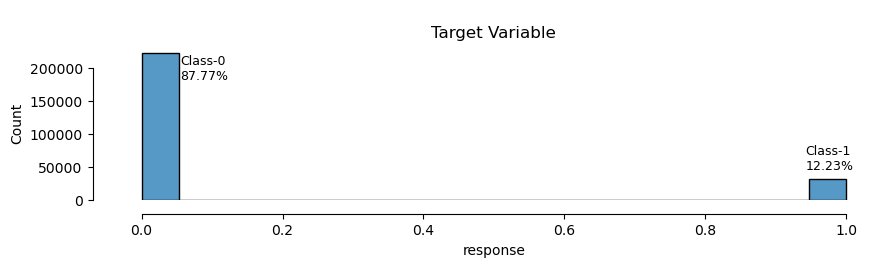

In [25]:
# Target: unbalanced classes
plt.figure( figsize=(10, 2) )
plt.title('Target Variable')
plt.annotate( 'Class-0\n87.77%', xy=(130,135), fontsize=9, xycoords='figure points' );
plt.annotate( 'Class-1\n12.23%', xy=(580,70), fontsize=9, xycoords='figure points' );
sns.histplot(df1, x='response');
sns.despine( offset=10, trim=True );

## 1.4. Fillout NA & Change Data Types

In [26]:
# Nop

# 2. BUSINESS HYPOTHESIS

## 2.1. Mind Map

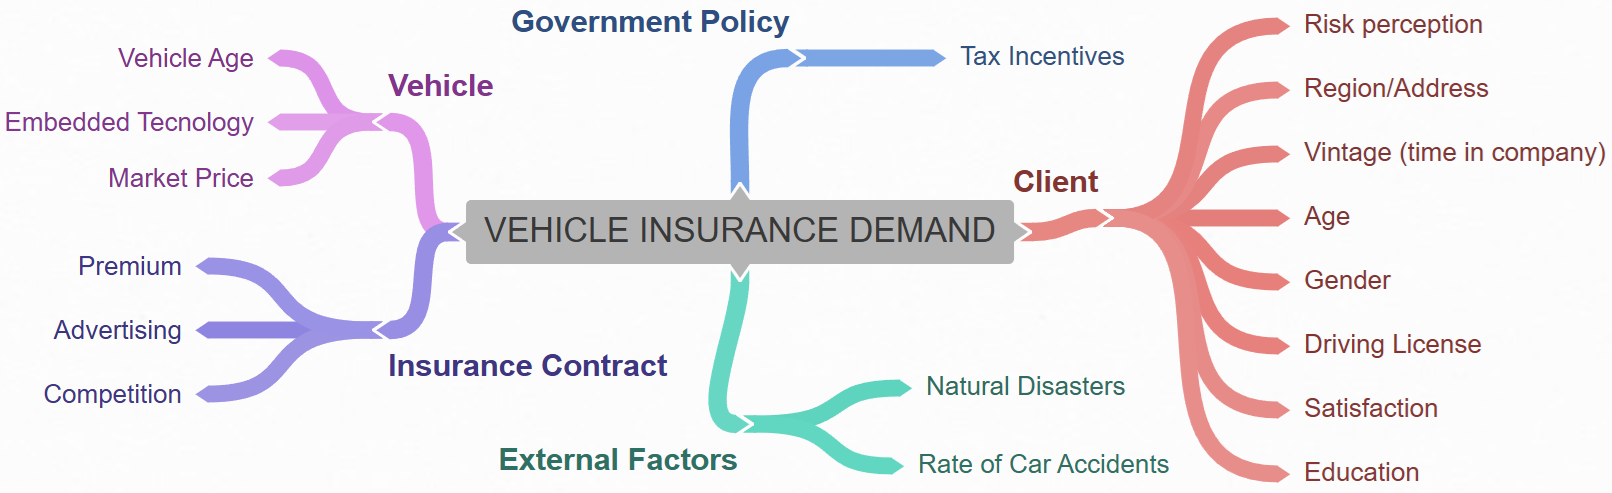

In [27]:
Image('../img/MindMapHypothesis_Insurance.png')

## 2.2. Hypothesis (considering available features)

**H-1.** GENDER: will not influence interest for insurance.

**H-2.** CLIENT AGE: interest for insurance will rise with age.

(since different groups have different needs and risk perceptions, affecting insurance demand)

**H-3.** DRIVING LICENSE: the interest for insurance tends to rise after aquiring a license.

**H-4.** REGION CODE: some regions may generate more interest for insurance than others.

- due to demographic characteristics. That can be a result of factors like regions with higher crime rates or simply due to more vehicles in an area

**H-5.** PREVIOUSLY INSURED: those insured by other insurance companies will be less inclined to become our clients.

**H-6.** VEHICLE AGE: the newer the vehicle, the bigger the interest for insurance.

- That may be due to: (1) higher market value of newer cars, (2) older cars may need less broad insurance, (3) compared to the value of older/cheaper cars, premium become percentually expensive, reducing the demand. To overcome that effect, companies may offer insurance specially suited for older vehicles, which may raise demand

**H-7.** ANNUAL PREMIUM: higher values will result in less interest for insurance.

**H-8.** POLICY SALES CHANNEL: some channels may be more effective in aquiring new clients.

**H-9.** VINTAGE: longer time clients tend to continue clients.


## 2.3. Other Hypothesis

Other factors can be subject of further studies.

**1.** ECONOMIC FACTORS: 

**1.1.** ECONOMIC GROWTH: affecting consumer's purchase power

**1.2.** UNEMPLOYMENT RATE: affecting consumer's purchase power

**1.3.** INFLATION: may inflate premiums, reducing potential demand

**2.** DEMOGRAPHIC FACTORS:

**2.1** POPULATION GROWTH: lead to more vehicles and then more insurance demand

**3.** SOCIOECONOMIC FACTORS:

**3.1** INCOME LEVEL: rise of income tend to increase insurance demand.

**3.2** EDUCATION LEVEL: tend to increase insurance demand.


**4.** TECHNOLOGICAL FACTORS

**4.1** INOVATION & TECHNOLOGY: the influence of telematics and autonomous cars may affect demand.

**5.** REGULATORY FACTORS

**5.1** GOVERNMENT INCENTIVES: tax benefits and other policies applied to vehicles tend to affect insurance demand.

**6.** MARKET FACTORS

**6.1** COMPETITION: affects consumer decision, then affecting insurance demand.

**6.1** ADVERTISING: afffects insurance demand.

**7.** BEHAVIORAL FACTORS

**7.1** RISK PERCEPTION: influences insurance demand.

**7.2** CUSTOMER SATISFACTION: impact retention of current customers and can attract new ones.

**8.** EXTERNAL FACTORS

**8.1** NATURAL AND ACCIDENTAL EVENTS: disasters or higher rate of accidents tend to boost demand for insurance.

REF: question presented to ChatGPT 4o:
- "In an economic analysis of the car insurance sales business, list the main factors that influence sales volume"

# 3. FEATURE ENGINEERING

## 3.0. copy data

In [28]:
# df3 = train
df3 = x_train.copy()
df3['response'] = y_train
df3.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [29]:
df3.nunique()

id                      203268
gender                       2
age                         66
driving_license              2
region_code                 53
previously_insured           2
vehicle_age                  3
vehicle_damage               2
annual_premium           41923
policy_sales_channel       151
vintage                    290
response                     2
dtype: int64

## 3.1. DataFitAndTransform Class

In [30]:
class DataFitAndTransform:

    def __init__(self):
        self.ss0 = pp.StandardScaler()
        self.ss1 = pp.StandardScaler()
        self.ss2 = pp.StandardScaler()
        self.ss3 = pp.StandardScaler()
        self.mms_age = pp.MinMaxScaler()
        self.mms_vintage = pp.MinMaxScaler()
        self.ohe_gender_enc = pp.OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
        self.looe_region_code_enc = ce.LeaveOneOutEncoder(cols=['region_code'])
        self.ohe_vehicle_age = pp.OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
        self.fe_policy_sales_channel = None
        self.policy_sales_channel_importance_dict = {}
        self.list_of_features = []
        self.age_rbf_dict = None
        self.age_rbf_24_dict = {}
        self.age_rbf_44_dict = {}

    def DataFitting(self, in_df, y_train):
        """
        Fits the scalers and encoders on the training data.

        Parameters:
        in_df (DataFrame): Input DataFrame containing the training data.
        y_train (Series): Target variable for encoding.
        
        Returns:
        out_df (DataFrame): Prepared DataFrame with all transformations applied.
        """
        
        out_df = in_df.copy()

        #........ Encoding: apply one-hot, target, leave-one-out
        ohe_gender = self.ohe_gender_enc.fit_transform(out_df[['gender']])
        out_df = pd.concat([out_df, ohe_gender], axis=1).drop(columns=['gender'])

        out_df = self.looe_region_code_enc.fit_transform(out_df, y_train)

        #........ Standardization: apply standard-scaler
        out_df['annual_premium'] = self.ss0.fit_transform(out_df[['annual_premium']].values)
        out_df['annual_premium_f1'] = self.ss1.fit_transform(out_df[['annual_premium_f1']].values)
        out_df['annual_premium_f2'] = self.ss2.fit_transform(out_df[['annual_premium_f2']].values)
#        out_df['annual_premium_f3'] = self.ss3.fit_transform(out_df[['annual_premium_f3']].values)

        #.......... Policy Sales Channel
        aux = out_df.loc[:, ['policy_sales_channel', 'id'] ].groupby('policy_sales_channel').count().reset_index()
        aux['policy_sales_channel_importance'] = aux['id'] / aux['id'].max()
        self.policy_sales_channel_importance_dict = aux.set_index('policy_sales_channel')['policy_sales_channel_importance'].to_dict()
        out_df['policy_sales_channel_importance'] = out_df['policy_sales_channel'].map(self.policy_sales_channel_importance_dict)

        self.fe_policy_sales_channel = out_df.groupby('policy_sales_channel').size() / len(out_df)
        out_df['policy_sales_channel'] = out_df['policy_sales_channel'].map(self.fe_policy_sales_channel)

        #.......... Age
        # Since 'age' is a bimodal variable (mode1=23-24, mode2=43): create two features using "rbf_kernel()"
        # REF: Géron, pg.77-80
        centers = [24, 44]
        gamma_24 = 0.030
        gamma_44 = 0.015

        # Populate dictionaries. Note that, once defined center & gamma, the database is useless.
        for age in range(0, 121):
            self.age_rbf_24_dict[age] = rbf_kernel([[age]], [[centers[0]]], gamma=gamma_24).flatten()[0]
            self.age_rbf_44_dict[age] = rbf_kernel([[age]], [[centers[1]]], gamma=gamma_44).flatten()[0]
        #for age in out_df['age'].unique():
            #self.age_rbf_24_dict[age] = rbf_kernel([[age]], [[centers[0]]], gamma=gamma_24).flatten()[0]
            #self.age_rbf_44_dict[age] = rbf_kernel([[age]], [[centers[1]]], gamma=gamma_44).flatten()[0]

        #min_age = int(out_df['age'].min())
        #max_age = int(out_df['age'].max())
        #print(f"MinAge={min_age}   MaxAge={max_age}")
        #self.rbf_fill_age_rbf_dict(self.age_rbf_24_dict, min_age, max_age)
        #self.rbf_fill_age_rbf_dict(self.age_rbf_44_dict, min_age, max_age)

        # Apply results to train data
        out_df['age_rbf_24'] = out_df['age'].map(self.age_rbf_24_dict)
        out_df['age_rbf_44'] = out_df['age'].map(self.age_rbf_44_dict)

        # age (detail: let "age" be the last to be transformed...)
        out_df['age'] = self.mms_age.fit_transform(out_df[['age']].values)

        #........ Encoding: apply one-hot, target, leave-one-out
        ohe = self.ohe_vehicle_age.fit_transform(out_df[['vehicle_age']])
        out_df = pd.concat([out_df, ohe], axis=1).drop(columns=['vehicle_age'])

        #........ vintage: apply min-max-scaler
        out_df['vintage'] = self.mms_vintage.fit_transform(out_df[['vintage']].values)

        return out_df

    def DataTransforming(self, in_df):
        """
        Transforms the test data using the fitted scalers and encoders.

        Parameters:
        in_df (DataFrame): Input DataFrame containing the test data.
        
        Returns:
        out_df (DataFrame): Transformed DataFrame with all transformations applied.
        """

        out_df = in_df.copy()
        
        # gender: encoding
        ohe_gender = self.ohe_gender_enc.transform(out_df[['gender']])
        out_df = pd.concat([out_df, ohe_gender], axis=1).drop(columns=['gender'])

        # region_code: encoding
        out_df = self.looe_region_code_enc.transform(out_df)

        # annual_premium: standardization
        out_df['annual_premium'] = self.ss0.transform(out_df[['annual_premium']].values)
        out_df['annual_premium_f1'] = self.ss1.transform(out_df[['annual_premium_f1']].values)
        out_df['annual_premium_f2'] = self.ss2.transform(out_df[['annual_premium_f2']].values)
#       out_df['annual_premium_f3'] = self.ss3.transform(out_df[['annual_premium_f3']].values)

        # policy_sales_channel (detail: let "policy_sales_channel" be the last to be transformed...)
        out_df['policy_sales_channel_importance'] = out_df['policy_sales_channel'].map(self.policy_sales_channel_importance_dict)
        out_df['policy_sales_channel'] = out_df['policy_sales_channel'].map(self.fe_policy_sales_channel)

        # age (detail: let "age" be the last to be transformed...)
        out_df['age_rbf_24'] = out_df['age'].map(self.age_rbf_24_dict)
        out_df['age_rbf_44'] = out_df['age'].map(self.age_rbf_44_dict)
        out_df['age'] = self.mms_age.transform(out_df[['age']].values)

        # vehicle_age: encoding
        ohe = self.ohe_vehicle_age.transform(out_df[['vehicle_age']])
        out_df = pd.concat([out_df, ohe], axis=1).drop(columns=['vehicle_age'])

        # vintage: rescaling
        out_df['vintage'] = self.mms_vintage.transform(out_df[['vintage']].values)

        return out_df.fillna(0)

    def get_parameters(self):
        """
        Returns the fitted scalers and encoders.

        Returns:
        dict: Dictionary containing the scalers and encoders.
        """
        return {
            'mms_age': self.mms_age,
            'age_rbf_24': self.age_rbf_24_dict,
            'age_rbf_44': self.age_rbf_44_dict,
            'ss0': self.ss0,  # annual_premium
            'ss1': self.ss1,  # annual_premium_f1
            'ss2': self.ss2,  # annual_premium_f2
            'ss3': self.ss3,  # annual_premium_f3
            'ohe_gender_enc': self.ohe_gender_enc,
            'fe_policy_sales_channel': self.fe_policy_sales_channel,
            'policy_importance_dict': self.policy_sales_channel_importance_dict,
            'looe_region_code_enc': self.looe_region_code_enc,
            'ohe_vehicle_age': self.ohe_vehicle_age,
            'mms_vintage': self.mms_vintage,
        }

    def simple_conversion_of_categorical_features(self, in_df):

        df3 = in_df.copy()

        #.......... Vehicle Damage Number
        df3['vehicle_damage'] = df3['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        #.......... Vehicle Age
        df3['vehicle_age'] = df3['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                    'between_1_2_years' if x == '1-2 Year'  else 'bellow_1_year' )

        #.......... Annual Premium
        # From 'annual_premium', derive 3 features
        #    - feature.1: points with values below 2675 (or between 2630-2675), others =ZERO
        #    - feature.2: values from 2675 to 74301 (or 83260), others =ZERO
        #    - feature.3: values above previous limits, others =ZERO
        df3['annual_premium_f1'] = df3['annual_premium'].apply( lambda x: 0.0 if x>2675.0 else x )
        df3['annual_premium_f2'] = df3['annual_premium'].apply( lambda x: x if x>2675.0 and x<74301.0 else 0.0 )
        df3['annual_premium_f3'] = df3['annual_premium'].apply( lambda x: 0.0 if x<74301.0 else x )

        return df3

    def SaveSelectedFeatures( self, inListOfFeatures ):
        """
        Save list of selected features to future use

        Returns:
        nop: nothing.
        """
        self.list_of_features = inListOfFeatures

    def GetSelectedFeatures( self ):
        """
        Returns list of features.

        Returns:
        list: list of features.
        """
        return self.list_of_features

    def rbf_interpolate_missing_value( self, year, in_dict ):
        previous_year = year - 1
        next_year = year + 1
        prev_val = in_dict.get(previous_year)
        next_val = in_dict.get(next_year)
        
        if prev_val is not None and next_val is not None:
            return (prev_val + next_val) / 2.0
        elif prev_val is not None:
            return prev_val
        elif next_val is not None:
            return next_val
        else:
            return 0

    def rbf_fill_age_rbf_dict( self, in_dict, min_age, max_age ):
        for year in range(min_age, max_age + 1):
            if year not in in_dict:
                in_dict[year] = self.rbf_interpolate_missing_value(year, in_dict)


## 3.2. New features

In [31]:
#.......... Include new features: age_rbf & policy_sales_channel_importance (to EDA)
# create object
prep_models = DataFitAndTransform()

# Simple conversion of "vehicle_damage", "vehicle_age" and "annual_premium"
df3 = prep_models.simple_conversion_of_categorical_features(df3)

# Fit to create econdings
aux = prep_models.DataFitting(df3, y_train)

# get encoders and apply to "age" and "policy_sales_channel"
trained_models = prep_models.get_parameters()

# Create new features
df3['age_rbf_24'] = df3['age'].map(trained_models['age_rbf_24'])
df3['age_rbf_44'] = df3['age'].map(trained_models['age_rbf_44'])
df3['policy_sales_channel_importance'] = df3['policy_sales_channel'].map(trained_models['policy_importance_dict'])

df3.head(6).T

,65169,170484,330577,189262,292749,227082
id,65170,170485,330578,189263,292750,227083
gender,Male,Male,Female,Female,Female,Female
age,52,74,22,24,24,38
driving_license,1,1,1,1,1,1
region_code,7.0,24.0,15.0,50.0,34.0,28.0
previously_insured,0,0,0,0,1,1
vehicle_age,between_1_2_years,between_1_2_years,bellow_1_year,bellow_1_year,bellow_1_year,between_1_2_years
vehicle_damage,1,0,1,1,0,0
annual_premium,2630.0,2630.0,70518.0,28188.0,33831.0,39311.0
policy_sales_channel,124.0,156.0,152.0,152.0,152.0,29.0


In [32]:
# Verifying...
cols = [ 'annual_premium', 'annual_premium_f1', 'annual_premium_f2', 'annual_premium_f3' ]
aux = df3.loc[:, cols ].copy()
aux = pd.DataFrame( {'cols': aux.columns,
                      'DType': aux.dtypes,
                      'size': aux.shape[0],
                      'nunique': aux.nunique(),
                      'NAs': aux.isna().sum()} )
aux['NA_percent'] = round( aux['NAs'] / aux['size'], 2 )
aux

,cols,DType,size,nunique,NAs,NA_percent
annual_premium,annual_premium,float64,203268,41923,0,0.0
annual_premium_f1,annual_premium_f1,float64,203268,2,0,0.0
annual_premium_f2,annual_premium_f2,float64,203268,40245,0,0.0
annual_premium_f3,annual_premium_f3,float64,203268,1679,0,0.0


In [33]:
df3.nunique()

id                                 203268
gender                                  2
age                                    66
driving_license                         2
region_code                            53
previously_insured                      2
vehicle_age                             3
vehicle_damage                          2
annual_premium                      41923
policy_sales_channel                  151
vintage                               290
response                                2
annual_premium_f1                       2
annual_premium_f2                   40245
annual_premium_f3                    1679
age_rbf_24                             62
age_rbf_44                             42
policy_sales_channel_importance        94
dtype: int64

# 5. EDA

## 5.0. copy data, etc

In [34]:
df5 = df3.copy()

### Cramer V

In [35]:
#............... In case of categorical attributes: Cramer V Method
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramer_v( x, y ):
    confusion_matrix = pd.crosstab( x, y ).to_numpy()
    chi2 = ss.chi2_contingency( confusion_matrix )[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape

    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )

### Histogram Table

In [36]:
def histogram_table( num_bins, df, in_feature ):

    qt_tot = df.shape[0]

    # Binned range
    n, bins = np.histogram( df[in_feature], num_bins )
    str_bin = []
    first = True
    #lim_inf = str(bins[0])
    #lim_inf = f'{bins[0]:.1f}'
    lim_inf = str( round( bins[0], 1 ) )
    for bin in bins:
        if first:
            first = False
            continue
        str_bin.append( "(" + lim_inf + " - " + str( round(bin, 1) ) + ")" )
        #lim_inf = str( bin )
        #lim_inf = f'{bin:.1f}'
        lim_inf = str( round(bin, 1) )

    out_table = pd.DataFrame()
    out_table['VALUE RANGE'] = str_bin
    out_table[in_feature + ': all'] = n
    out_table['perc%'] = 100.0 * n / qt_tot

    aux00 = df.loc[ df['response']==0, [in_feature, 'response'] ]
    n0, bins = np.histogram( aux00[in_feature], num_bins )
    out_table['resp.0'] = n0

    aux01 = df.loc[ df['response']==1, [in_feature, 'response'] ]
    n1, bins = np.histogram( aux01[in_feature], num_bins )
    out_table['resp.1'] = n1

    return out_table


## 5.1. Univariate & Bivariate Analysis

In [37]:
# AIM:
# Univariate Analysis: understand the characteristics & behaviour of each feature alone
# Bivariate  Analysis: understand the impact of each attribute to the response variable.

### 5.1.1. Numerical Features

#### Importance of Numerical Features: Correlation

In [38]:
# Correlation Coefficient
# REF: "Machine Learning Bootcamp", pg.86-88

features = [ 'age', 'annual_premium', 'vintage', 
             'annual_premium_f1', 'annual_premium_f2', 'annual_premium_f3', 
             'age_rbf_24', 'age_rbf_44', 
             'policy_sales_channel_importance' ]
df_pearson = df5[features].corrwith(df5.response)
df_pearson = df_pearson.sort_values(ascending=False).to_frame(name='Corr.Coef')
df_pearson


,Corr.Coef
age_rbf_44,0.191734
age,0.112446
annual_premium,0.021670
annual_premium_f2,0.018966
annual_premium_f1,0.010520
annual_premium_f3,0.004882
vintage,-0.002953
policy_sales_channel_importance,-0.144944
age_rbf_24,-0.205636


In [39]:
# RESULTS INDICATE THAT:
#
# "vintage" & "annual_premium_f3" are the least important features
# "age_rbf_24" & "age_rbf_44" show more important than "age"
# Conclusion: "age", "vintage" & "annual_premium_f3" could (supposedly) be discarded.

#### (a) AGE

- **(1)** AGE has bimodal distribution, with two populations having modes in 24 and 44 years.

- **(2)** The graphics indicate that 44-years mode differs from 24-years by presenting, proportionally, more people interest in insurance. So, different marketing strategies (ads & sales) should be considered for each group.

- **(3)** The bimodal distribution is treated by applying Radial Basis Functions (RBF) to create two new features to represent the similarity between the 'age' feature and each mode [ref: Géron, 3rd ed, pg.77]

##### Univariate Analysis

c:\Users\Manoel\miniconda3\envs\healthins2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


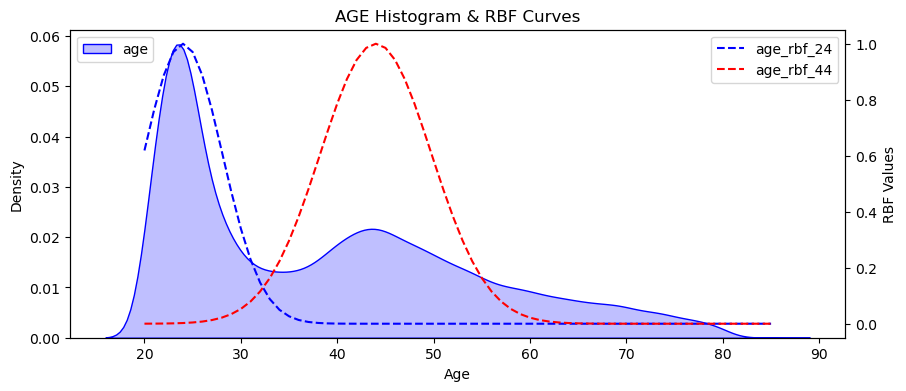

In [40]:
# UNIVARIATE:
# There are 66 unique values in 'age'.
# In order to plot, let's prepare a dataframe...
# ... with 66 lines & 3 columns: 'age', 'age_rbf_24' e 'age_rbf_44'
aux = df5.loc[:, ['age','age_rbf_24','age_rbf_44'] ].groupby('age').mean().reset_index()

# Two Y axes needed...
fig, ax1 = plt.subplots(figsize=(10, 4))
plt.title('AGE Histogram & RBF Curves')

# First Y: KDEPLOT
sns.kdeplot(df5['age'], label='age', fill=True, ax=ax1, color='blue')
ax1.set_ylabel('Density')
ax1.legend(loc='upper left')
ax1.set_xlabel('Age')

# Second Y: RBF curves
ax2 = ax1.twinx()
ax2.plot(aux['age'], aux['age_rbf_24'], 'b--', label='age_rbf_24')
ax2.plot(aux['age'], aux['age_rbf_44'], 'r--', label='age_rbf_44')
ax2.set_ylabel('RBF Values')
ax2.legend(loc='upper right')

plt.show()

##### Bivariate Analysis

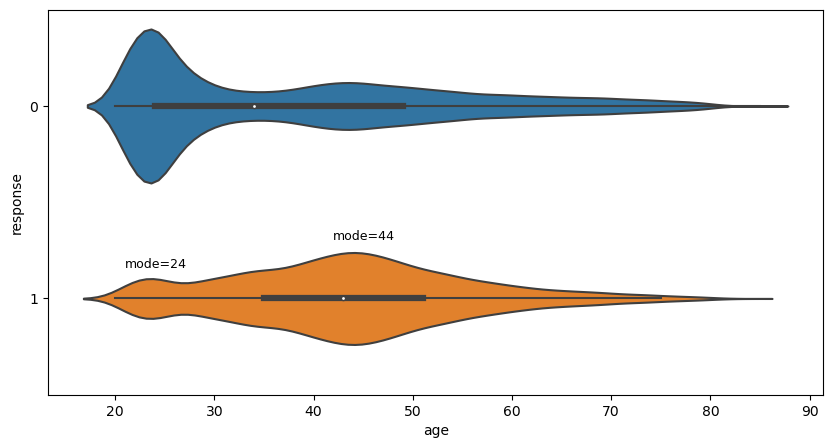

In [41]:
# BIVARIATE ANALYSIS:
plt.figure(figsize=(10, 5))
sns.violinplot(y='response', x='age', orient='h', data=df5);
plt.annotate( 'mode=24', xy=(90,130), fontsize=9, xycoords='figure points' );
plt.annotate( 'mode=44', xy=(240,150), fontsize=9, xycoords='figure points' );

##### digging into age values

In [42]:
# AGE IN THE MICROSCOPE: how we found the modes...
# First mode
num_bins = 136   # we vary this...
df_hist = histogram_table(num_bins, df5, 'age')
print( df_hist.loc[3:13] )
#df_hist.head(21)    # ...and this.

# RESULTS:
# Age   qt     %      r0       r1
# 22  11119  5.47%   10712     407
# 23  12932  6.36%   12453     479
# 24  13913  6.84%   13425     488  <<< mode
# 25  10962  5.39%   10579     383


      VALUE RANGE  age: all     perc%  resp.0  resp.1
3   (21.4 - 21.9)         0  0.000000       0       0
4   (21.9 - 22.4)     11119  5.470118   10712     407
5   (22.4 - 22.9)         0  0.000000       0       0
6   (22.9 - 23.3)     12932  6.362044   12453     479
7   (23.3 - 23.8)         0  0.000000       0       0
8   (23.8 - 24.3)     13913  6.844658   13425     488
9   (24.3 - 24.8)         0  0.000000       0       0
10  (24.8 - 25.3)     10962  5.392880   10579     383
11  (25.3 - 25.7)         0  0.000000       0       0
12  (25.7 - 26.2)      7245  3.564260    6979     266
13  (26.2 - 26.7)         0  0.000000       0       0


In [43]:
# Second mode
num_bins = 132   # we vary this...
df_hist = histogram_table(num_bins, df5, 'age')
print( df_hist.loc[43:52] )  # ...and this.
#df_hist.head(55)    # ...and this.

# RESULTS:
# Age   qt     %         r0      r1
# 42   4340  2.14%      3438     848
# 43   4508  2.2178%    3537     902
# 44   4509  2.2183%    3527     971  <<< mode
# 45   4392  2.16%      3427     982


      VALUE RANGE  age: all     perc%  resp.0  resp.1
43  (41.2 - 41.7)         0  0.000000       0       0
44  (41.7 - 42.2)      4340  2.135112    3438     848
45  (42.2 - 42.7)         0  0.000000       0       0
46  (42.7 - 43.1)      4508  2.217762    3537     902
47  (43.1 - 43.6)         0  0.000000       0       0
48  (43.6 - 44.1)      4509  2.218254    3527     971
49  (44.1 - 44.6)         0  0.000000       0       0
50  (44.6 - 45.1)      4392  2.160694    3427     982
51  (45.1 - 45.6)         0  0.000000       0       0
52  (45.6 - 46.1)      4130  2.031800    3214     965


#### (b) ANNUAL PREMIUM

- **(1)** Annual Premium values comprise three groups of values, which we named Low Budget Group, Main Group, Extreme Group

- **(2)** Low budget group - the cheapest premium (= $2.630) occurs in 17% of the database.

- **(3)** Main group - 82% of the database includes insurance premiums ranging from $6.098 to $74.300

- **(4)** Extreme group - 0,9% of the cases range from $74.301 to the maximum value of $540.165

PS: alternativelly, three categories could be generated with OneHotEncoding.

##### Univariate Analysis

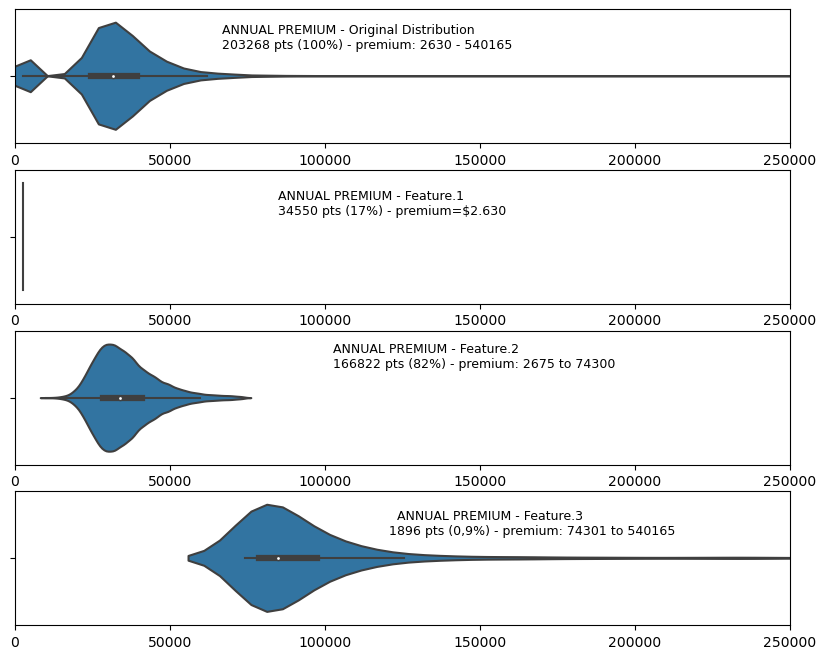

In [44]:
# UNIVARIATE ANALYSIS:
# annual_premium feature.1: points with values between 2630-2675, others =ZERO
# Result: there are 34.550 (17%) contracts of low budget premium of exactly $2630.
auxf1 = df5.loc[ df5['annual_premium_f1']!=0, ['response','annual_premium_f1'] ]

# annual_premium feature.2: values from 2675 to 74301 (or 83260), others =ZERO
# Result: there are 166822 (82%, vast majority) contracts with premiums from $2675 to $74.301.
auxf2 = df5.loc[ df5['annual_premium_f2']!=0, ['response','annual_premium_f2'] ]

# annual_premium feature.3: values above 74301, others =ZERO
# Result: there are 1.896 (0,9%) contracts with premiums over $74.301.
auxf3 = df5.loc[ df5['annual_premium_f3']!=0, ['response','annual_premium_f3'] ]

plt.figure(figsize=(10, 8))
plt.subplot(4,1,1)
ax0 = sns.violinplot(x='annual_premium', orient='h', data=df5);
ax0.set_xlim(0, 250000)
ax0.set( xlabel='' )
plt.subplot(4,1,2)
ax1 = sns.violinplot(x='annual_premium_f1', orient='h', data=auxf1);
ax1.set_xlim(0, 250000)
ax1.set( xlabel='' )
plt.subplot(4,1,3)
ax2 = sns.violinplot(x='annual_premium_f2', orient='h', data=auxf2);
ax2.set_xlim(0, 250000)
ax2.set( xlabel='' )
plt.subplot(4,1,4)
ax3 = sns.violinplot(x='annual_premium_f3', orient='h', data=auxf3);
ax3.set_xlim(0, 250000)
ax3.set( xlabel='' )
plt.annotate( 'ANNUAL PREMIUM - Original Distribution\n203268 pts (100%) - premium: 2630 - 540165', xy=(160,440), fontsize=9, xycoords='figure points' );
plt.annotate( 'ANNUAL PREMIUM - Feature.1\n34550 pts (17%) - premium=$2.630', xy=(200,320), fontsize=9, xycoords='figure points' );
plt.annotate( 'ANNUAL PREMIUM - Feature.2\n166822 pts (82%) - premium: 2675 to 74300', xy=(240,210), fontsize=9, xycoords='figure points' );
plt.annotate( '  ANNUAL PREMIUM - Feature.3\n1896 pts (0,9%) - premium: 74301 to 540165', xy=(280,90), fontsize=9, xycoords='figure points' );
plt.show()


In [45]:
(df5.shape, auxf1.shape, auxf2.shape, auxf3.shape )

((203268, 18), (34550, 2), (166822, 2), (1896, 2))

In [46]:
np.max( auxf3['annual_premium_f3'] )

540165.0

##### Bivariate Analysis

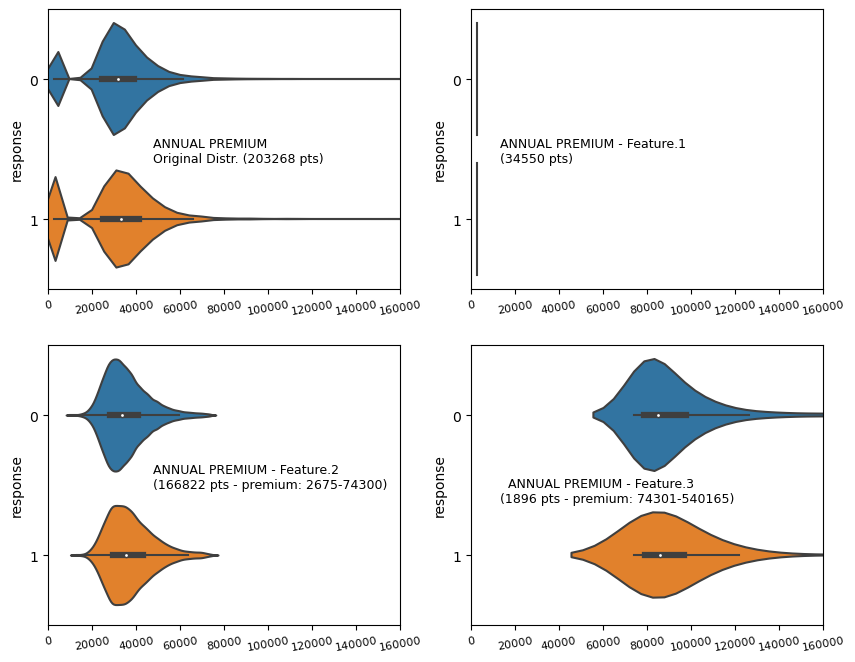

In [47]:
# BIVARIATE ANALYSIS:
#............... PLOTTINGS
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
ax0 = sns.violinplot(y='response', x='annual_premium', orient='h', data=df5);
ax0.set_xlim(0, 160000)
ax0.set( xlabel='' )
plt.xticks(rotation=10, fontsize=8);
plt.subplot(2,2,2)
ax1 = sns.violinplot(y='response', x='annual_premium_f1', orient='h', data=auxf1);
ax1.set_xlim(0, 160000)
ax1.set( xlabel='' )
plt.xticks(rotation=10, fontsize=8);
plt.subplot(2,2,3)
ax2 = sns.violinplot(y='response', x='annual_premium_f2', orient='h', data=auxf2);
ax2.set_xlim(0, 160000)
ax2.set( xlabel='' )
plt.xticks(rotation=10, fontsize=8);
plt.subplot(2,2,4)
ax3 = sns.violinplot(y='response', x='annual_premium_f3', orient='h', data=auxf3);
ax3.set_xlim(0, 160000)
ax3.set( xlabel='' )
plt.xticks(rotation=10, fontsize=8);
plt.annotate( 'ANNUAL PREMIUM\nOriginal Distr. (203268 pts)', xy=(110,360), fontsize=9, xycoords='figure points' );
plt.annotate( 'ANNUAL PREMIUM - Feature.1\n(34550 pts)', xy=(360,360), fontsize=9, xycoords='figure points' );
plt.annotate( 'ANNUAL PREMIUM - Feature.2\n(166822 pts - premium: 2675-74300)', xy=(110,125), fontsize=9, xycoords='figure points' );
plt.annotate( '  ANNUAL PREMIUM - Feature.3\n(1896 pts - premium: 74301-540165)', xy=(360,115), fontsize=9, xycoords='figure points' );
plt.show()

In [48]:
#............... TABLE

tabela = df5.loc[:, ['annual_premium', 'response'] ].groupby('response').count().reset_index()
tabela['ap%'] = np.round(100.0 * tabela['annual_premium'] / df5.shape[0], 2)
t1 = df5[df5['annual_premium_f1'] != 0].loc[:, ['annual_premium_f1', 'response']].groupby('response').count().reset_index()
t2 = df5[df5['annual_premium_f2'] != 0].loc[:, ['annual_premium_f2', 'response']].groupby('response').count().reset_index()
t3 = df5[df5['annual_premium_f3'] != 0].loc[:, ['annual_premium_f3', 'response']].groupby('response').count().reset_index()
tabela['annual_premium_f1'] = t1['annual_premium_f1']
tabela['apf1%'] = np.round(100.0 * tabela['annual_premium_f1'] / t1['annual_premium_f1'].sum(), 2)
tabela['annual_premium_f2'] = t2['annual_premium_f2']
tabela['apf2%'] = np.round(100.0 * tabela['annual_premium_f2'] / t2['annual_premium_f2'].sum(), 2)
tabela['annual_premium_f3'] = t3['annual_premium_f3']
tabela['apf3%'] = np.round(100.0 * tabela['annual_premium_f3'] / t3['annual_premium_f3'].sum(), 2)
annualpremium_tab = tabela
annualpremium_tab

,response,annual_premium,ap%,annual_premium_f1,apf1%,annual_premium_f2,apf2%,annual_premium_f3,apf3%
0,0,178389,87.76,30058,87.0,146702,87.94,1629,85.92
1,1,24879,12.24,4492,13.0,20120,12.06,267,14.08


##### digging into annual premium values

In [49]:
# HOW WE FOUND THE LIMITS OF FEATURES...
# annual_premium:    min=2630.0    max=540165.0

# From 'annual_premium', derived 3 features
#    - feature.1: points with values = 2630, others =ZERO
#    - feature.2: values from 2635 to 74301 (or 83260), others =ZERO
#    - feature.3: values >than previous limits, others =ZERO

In [50]:
# annual_premium histogram:    min=2630.0    max=540165.0
# --> first 15% of range (limit to 83260) comprise 99,5% of measurement points

num_bins = 20
df_hist = histogram_table(num_bins, df5, 'annual_premium')
df_hist.head(4)

,VALUE RANGE,annual_premium: all,perc%,resp.0,resp.1
0,(2630.0 - 29506.8),84630,41.634689,59984,9491
1,(29506.8 - 56383.5),109513,53.876163,106328,14023
2,(56383.5 - 83260.2),8080,3.975048,10657,1213
3,(83260.2 - 110137.0),788,0.387666,1085,118


In [51]:
# annual_premium histogram:    min=2630.0    max=540165.0
# --> first 13,33% of range (limit 74301) comprise 99,10% of measurement points

num_bins = 30
df_hist = histogram_table(num_bins, df5, 'annual_premium')
df_hist.head(5)

,VALUE RANGE,annual_premium: all,perc%,resp.0,resp.1
0,(2630.0 - 20547.8),38464,18.922801,31892,4797
1,(20547.8 - 38465.7),109147,53.696106,82688,12041
2,(38465.7 - 56383.5),46532,22.891946,51732,6676
3,(56383.5 - 74301.3),7230,3.556881,9345,1099
4,(74301.3 - 92219.2),1273,0.626267,1909,182


In [52]:
# annual_premium histogram:    min=2630.0    max=540165.0
# --> ~17% of the measurement points (=64877) are located in the very beginning...
#     ...values between 2630-2675 (or =2630)

num_bins = 12000
df_hist = histogram_table(num_bins, df5, 'annual_premium')
df_hist.head(4)

,VALUE RANGE,annual_premium: all,perc%,resp.0,resp.1
0,(2630.0 - 2674.8),34550,16.997265,30058,4492
1,(2674.8 - 2719.6),0,0.000000,0,0
2,(2719.6 - 2764.4),0,0.000000,0,0
3,(2764.4 - 2809.2),0,0.000000,0,0


#### (c) VINTAGE

- 'vintage' shows almost uniform distribution. Probably, no benefit to the present study.

##### Univariate Analysis

c:\Users\Manoel\miniconda3\envs\healthins2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


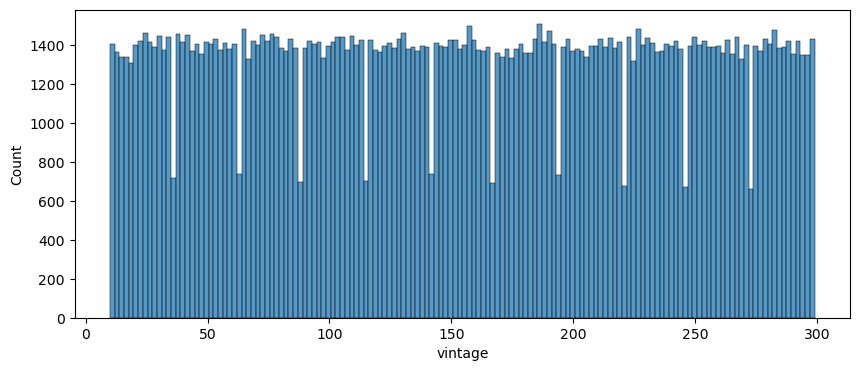

In [53]:
# Univariate Analysis:
plt.figure(figsize=(10, 4))
sns.histplot( df5['vintage'], bins=150 );

##### Bivariate Analysis

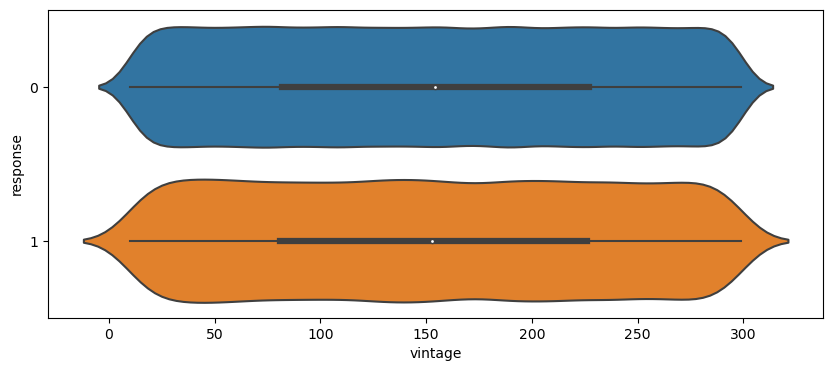

In [54]:
# Bivariate Analysis
plt.figure(figsize=(10, 4))
sns.violinplot(y='response', x='vintage', orient='h', data=df5);

### 5.1.2. Categorical Features

#### Importance of Categorical Features: Mutual Information

In [55]:
# Mutual Information
# REF: "Machine Learning Bootcamp", pg.85

def calculate_mi(series):
    return mutual_info_score( series, df5.response )

features = [ 'gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'policy_sales_channel' ]
df_mi = df5[features].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi


,MI
previously_insured,0.079611
vehicle_damage,0.079218
policy_sales_channel,0.039318
vehicle_age,0.026273
region_code,0.009539
gender,0.001384
driving_license,0.000081


In [56]:
# RESULTS INDICATE THAT: "driving_license" & "gender" are the least important categorical features,
#                        ...and could (possibly) be discarded.

#### (a) GENDER

- **(1)** The base comprises 46% of female people & 54% of male people.

- **(2)** More male people (13,8% or 15181) are inclined to purchase the vehicle insurance contract, when compared to female people (10,38% or 9698)

##### Univariate Analysis

,gender,qtty,qtty%
0,Female,93440,45.97
1,Male,109828,54.03


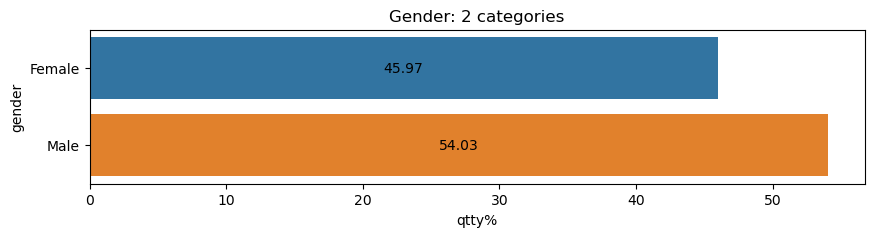

In [57]:
# Gender: 2 categories - female/male
tabela = df5.loc[:, ['gender', 'id'] ].groupby('gender').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['gender', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,2))
b2 = sns.barplot(tabela, y='gender', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='center')
plt.title('Gender: 2 categories');

gender_tab1 = tabela

tabela

##### Bivariate Analysis

In [58]:
# função "crosstab": monta tabela de contingência
gender_tab2 = pd.crosstab( df5['gender'], df5['response'] )
gender_tab2

response,0,1
gender,,
Female,83742,9698
Male,94647,15181


In [59]:
# tabela de contingência percentual
gender_tab3 = pd.crosstab( df5['gender'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )
gender_tab3

response,0,1
gender,,
Female,89.62,10.38
Male,86.18,13.82


#### (b) DRIVING_LICENSE

- Since almost the entire population (99,8%) has a driving license, this feature won't probably be of any benefit to the present study.

##### Univariate Analysis

,driving_license,qtty,qtty%
0,0,412,0.2
1,1,202856,99.8


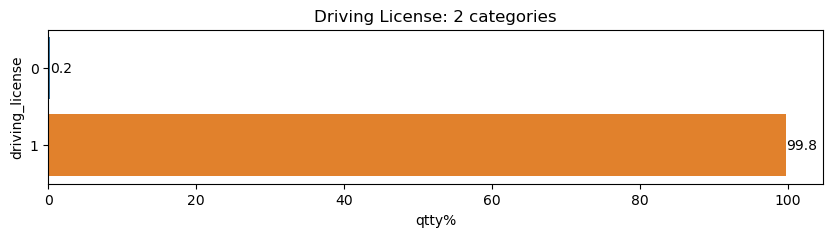

In [60]:
# Driving License: 2 categories - 0/1
tabela = df5.loc[:, ['driving_license', 'id'] ].groupby('driving_license').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['driving_license', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,2))
b2 = sns.barplot(tabela, y='driving_license', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='edge')
plt.title('Driving License: 2 categories');

tabela

##### Bivariate Analysis

In [61]:
# função "crosstab": monta tabela de contingência
drivinglicence_tab1 = pd.crosstab( df5['driving_license'], df5['response'] )
drivinglicence_tab1

response,0,1
driving_license,,
0,395,17
1,177994,24862


In [62]:
# tabela de contingência percentual
drivinglicence_tab2 = pd.crosstab( df5['driving_license'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )
drivinglicence_tab2

response,0,1
driving_license,,
0,95.87,4.13
1,87.74,12.26


#### (c) REGION_CODE

- **(1)** The 53 region codes are probably very important for the analysis, since they represent 53 different socio-economic consumer conditions for the target area.

- **(2)** From the univariate analysis, it can be observed that the first five regions with the greatest amount of registers comprise >50% of the total base, and the first 16 regions comprise >75%.

- **(3)** A new KPI can be derived: region_code_importance = (N# regs by region) / (Total N# regs)

##### Univariate Analysis

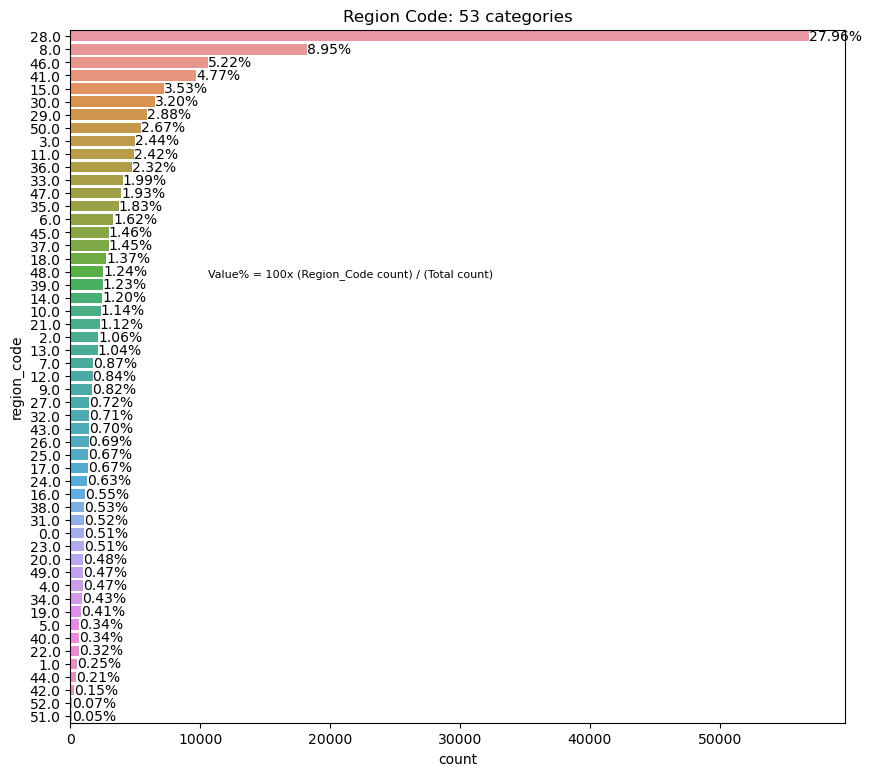

In [63]:
# UNIVARIATE ANALYSIS - Region Code: 53 categories...
plt.figure( figsize=(10, 9) )
b2 = sns.countplot( y='region_code', data=df5, order=df5['region_code'].value_counts().index );
tot = df5['region_code'].count()
for i in b2.containers:
    b2.bar_label(i, label_type='edge', fmt=lambda x: f'{(x/tot)*100:0.2f}%')
plt.title('Region Code: 53 categories');
plt.annotate( 'Value% = 100x (Region_Code count) / (Total count)', xy=(150,360), fontsize=8, xycoords='figure points' );


##### Bivariate Analysis

In [64]:
aux1 = df5.loc[:, ['region_code', 'response'] ].groupby('region_code').sum().reset_index()
aux2 = df5.loc[:, ['region_code', 'id'] ].groupby('region_code').count().reset_index()
regcode = pd.merge( aux1, aux2, how="inner", on=['region_code'] )
regcode.columns = ['region_code', 'response1', 'qtd']
regcode['response0'] = regcode['qtd'] - regcode['response1']
regcode['response%'] = regcode['response1'] / regcode['qtd']

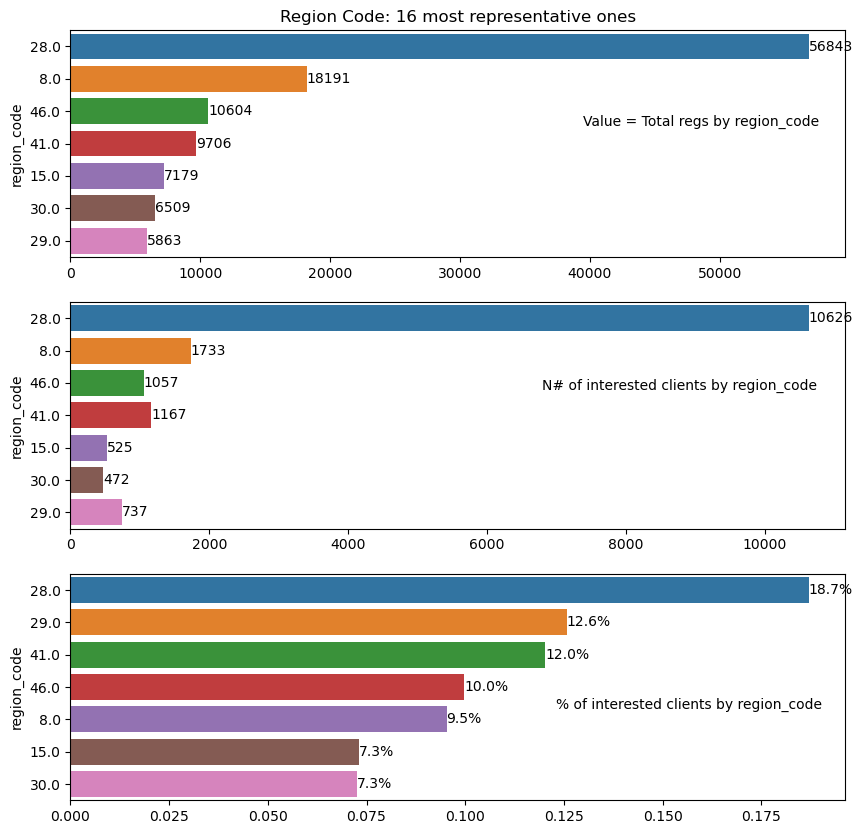

In [65]:
plt.figure(figsize=(10, 10))

# Total pts/Region
plt.subplot(3,1,1)
plt.title('Region Code: 16 most representative ones')
aux = regcode.loc[ regcode['qtd']>5604 , ['region_code', 'qtd'] ].sort_values('qtd', ascending=False).copy()
b1 = sns.barplot( aux, y='region_code', x='qtd', orient='h', order=aux['region_code'] );
b1.set_xlabel('')
tot = regcode['qtd'].sum()
for i in b1.containers:
    #b1.bar_label(i, label_type='edge', fmt=lambda x: f'{(100 * x/tot):0.1f}%')
    b1.bar_label(i, label_type='edge')

# Total pts where response=1
plt.subplot(3,1,2)
aux = regcode.loc[ regcode['qtd']>5604 , ['region_code', 'response1', 'qtd'] ].sort_values('qtd', ascending=False).copy()
b2 = sns.barplot( aux, y='region_code', x='response1', orient='h', order=aux['region_code'] );
b2.set_xlabel('')
tot = regcode['qtd'].sum()
for i in b2.containers:
    #b2.bar_label(i, label_type='edge', fmt=lambda x: f'{(100 * x/tot):0.2f}%')
    b2.bar_label(i, label_type='edge')

# % of pts where response=1
plt.subplot(3,1,3)
aux = regcode.loc[ regcode['qtd']>5604 , ['region_code', 'response%' ] ].sort_values('response%', ascending=False).copy()
b3 = sns.barplot( aux, y='region_code', x='response%', orient='h', order=aux['region_code'] );
b3.set_xlabel('')
for i in b3.containers:
    b3.bar_label(i, label_type='edge', fmt=lambda x: f'{100 * x:0.1f}%')
    #b3.bar_label(i, label_type='edge')

plt.annotate( 'Value = Total regs by region_code', xy=(420,510), fontsize=10, xycoords='figure points' );
plt.annotate( 'N# of interested clients by region_code', xy=(390,320), fontsize=10, xycoords='figure points' );
plt.annotate( '% of interested clients by region_code', xy=(400,90), fontsize=10, xycoords='figure points' );
plt.show()

#### (d) PREVIOUSLY_INSURED

- **(1)** From the whole database, 54% of customers do not have a vehicle insurance, while 46% already have it.

- **(2)** From those who do not have a vehicle insurance, 22,56% are interested in contracting one.

- **(3)** On the other hand, from those who already have it, 99,9% have NO interest in buying a vehicle insurance.

##### Univariate Analysis

,previously_insured,qtty,qtty%
0,0,109891,54.06
1,1,93377,45.94


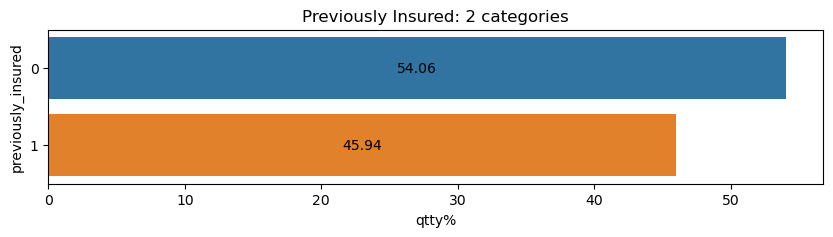

In [66]:
# Previously Insured: 2 categories - 0/1
tabela = df5.loc[:, ['previously_insured', 'id'] ].groupby('previously_insured').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['previously_insured', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,2))
b2 = sns.barplot(tabela, y='previously_insured', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='center')
plt.title('Previously Insured: 2 categories');

tabela

##### Bivariate Analysis

In [67]:
# Possíveis problemas:
# 1) o fato de 99,9% dos que já têm seguro não quererem, isso pode significar que não querem mudar de empresa
# 2) pode estar havendo vazamento de dados, pois "previously_insured" está muito relacionado a "response", ie,...
#    ...a variável de entrada está extremamente correlacionada com a saída.

In [68]:
# função "crosstab": monta tabela de contingência
pd.crosstab( df5['previously_insured'], df5['response'] )

response,0,1
previously_insured,,
0,85099,24792
1,93290,87


In [69]:
# aqui: tabela de contingência percentual
previouslyinsured_tab = pd.crosstab( df5['previously_insured'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )
previouslyinsured_tab

response,0,1
previously_insured,,
0,77.44,22.56
1,99.91,0.09


#### (e) VEHICLE_AGE

- **(1)** Only 4,2% of registers refer to vehicles aging > 2 years. On the other hand, 29% of them are inclined to purchase a vehicle insurance. So, raising the number of this kind of clients would probably be beneficial to the business.

- **(2)** Customers with newer cars (<1 year) represent 43% of the total, but only 4,3% of these customers are inclined to purchase a vehicle insurance. Why? Do they want to run the risk? Or do they already have a previous insurance?

- **(3)** Customers with cars between 1 and 2 years represent 52,5% of the whole, and 17,3% of them are inclined to purchase a vehicle insurance.

##### Univariate Analysis

,vehicle_age,qtty,qtty%
0,bellow_1_year,87925,43.26
1,between_1_2_years,106720,52.50
2,over_2_years,8623,4.24


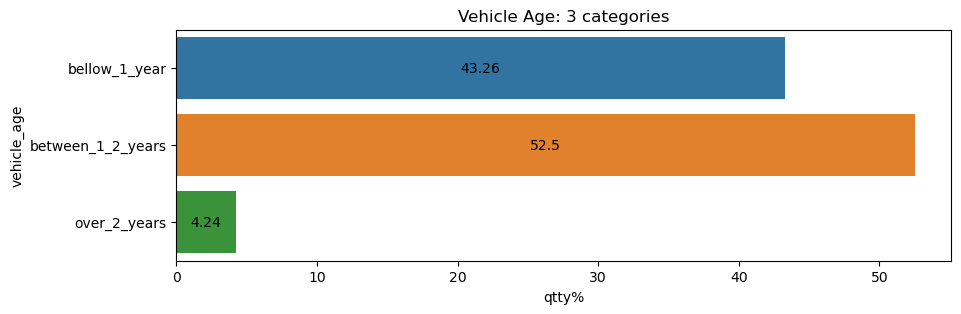

In [70]:
# Vehicle Age: 3 categories -  <1Y, 1-2Y, >2Y
tabela = df5.loc[:, ['vehicle_age', 'id'] ].groupby('vehicle_age').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['vehicle_age', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,3))
b2 = sns.barplot(tabela, y='vehicle_age', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='center')
plt.title('Vehicle Age: 3 categories');

tabela

##### Bivariate Analysis

In [71]:
# função "crosstab": monta tabela de contingência
pd.crosstab( df5['vehicle_age'], df5['response'] )

response,0,1
vehicle_age,,
bellow_1_year,84095,3830
between_1_2_years,88204,18516
over_2_years,6090,2533


In [72]:
# aqui: tabela de contingência percentual
vehicleage_tab = pd.crosstab( df5['vehicle_age'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )
vehicleage_tab

response,0,1
vehicle_age,,
bellow_1_year,95.64,4.36
between_1_2_years,82.65,17.35
over_2_years,70.63,29.37


#### (f) VEHICLE_DAMAGE

- **(1)** The database comprises 49,6% of customers who never got their vehicles damaged in the past. And only 0,5% of this group are inclined to purchase a vehicle insurance.

- **(2)** The other customers (50,4%) have already had their vehicles damaged in the past. Among these, 23,8% are inclined to purchase a vehicle insurance.

##### Univariate Analysis

,vehicle_damage,qtty,qtty%
0,0,100803,49.59
1,1,102465,50.41


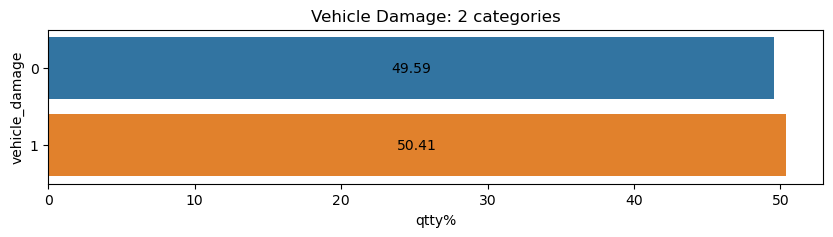

In [73]:
# Vehicle Damage: 2 categories - Yes/No
tabela = df5.loc[:, ['vehicle_damage', 'id'] ].groupby('vehicle_damage').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['vehicle_damage', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,2))
b2 = sns.barplot(tabela, y='vehicle_damage', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='center')
plt.title('Vehicle Damage: 2 categories');

tabela

##### Bivariate Analysis

In [74]:
# função "crosstab": monta tabela de contingência
pd.crosstab( df5['vehicle_damage'], df5['response'] )

response,0,1
vehicle_damage,,
0,100285,518
1,78104,24361


In [75]:
# tabela de contingência percentual
pd.crosstab( df5['vehicle_damage'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )

response,0,1
vehicle_damage,,
0,99.49,0.51
1,76.23,23.77


#### (g) POLICY_SALES_CHANNEL

- **(1)** From the univariate analysis, it can be observed that the two most representative channels (152 & 26) comprise more than 56% of the total base, and 90% of the base is spread in just 8 channels.

- **(2)** A new KPI can be derived: policy_sales_channel_importance = (N# regs by channel) / (Total N# regs)

##### Univariate Analysis

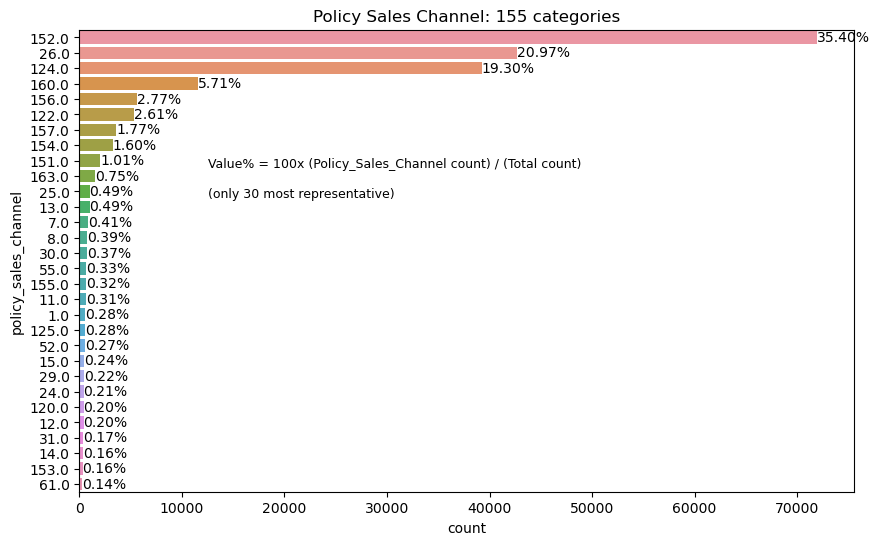

In [76]:
# UNIVARIATE ANALYSIS - Policy Sales Channel: 155 categories...
plt.figure( figsize=(10, 6) )
b2 = sns.countplot( y='policy_sales_channel', 
                   data=df5, order=df5['policy_sales_channel'].value_counts().iloc[:30].index );
tot = df5['policy_sales_channel'].count()
for i in b2.containers:
    b2.bar_label(i, label_type='edge', fmt=lambda x: f'{(x/tot)*100:0.2f}%')
plt.title('Policy Sales Channel: 155 categories');
plt.annotate( 'Value% = 100x (Policy_Sales_Channel count) / (Total count)\n\n(only 30 most representative)', xy=(150,250), fontsize=9, xycoords='figure points' );


##### Bivariate Analysis

In [77]:
aux1 = df5.loc[:, ['policy_sales_channel', 'response'] ].groupby('policy_sales_channel').sum().reset_index()
aux2 = df5.loc[:, ['policy_sales_channel', 'id'] ].groupby('policy_sales_channel').count().reset_index()
regcode = pd.merge( aux1, aux2, how="inner", on=['policy_sales_channel'] )
regcode.columns = ['policy_sales_channel', 'response1', 'qtd']
regcode['response0'] = regcode['qtd'] - regcode['response1']
regcode['response%'] = regcode['response1'] / regcode['qtd']

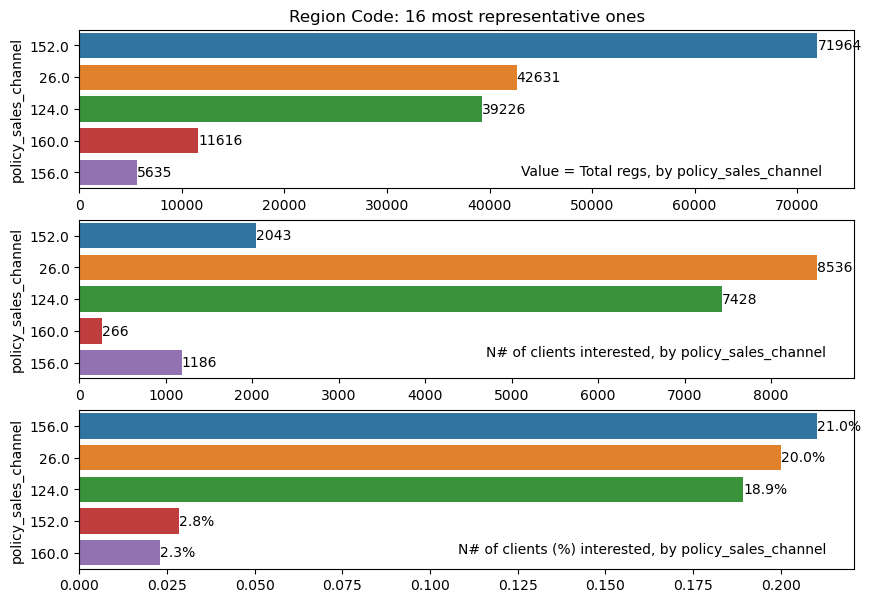

In [78]:
# BIVARIATE ANALYSIS
plt.figure(figsize=(10, 7))

# Total pts/Region
plt.subplot(3,1,1)
plt.title('Region Code: 16 most representative ones')
aux = regcode.loc[ regcode['qtd']>5604 , ['policy_sales_channel', 'qtd'] ].sort_values('qtd', ascending=False).copy()
b1 = sns.barplot( aux, y='policy_sales_channel', x='qtd', orient='h', order=aux['policy_sales_channel'] );
b1.set_xlabel('')
tot = regcode['qtd'].sum()
for i in b1.containers:
    #b1.bar_label(i, label_type='edge', fmt=lambda x: f'{(100 * x/tot):0.1f}%')
    b1.bar_label(i, label_type='edge')

# Total pts where response=1
plt.subplot(3,1,2)
aux = regcode.loc[ regcode['qtd']>5604 , ['policy_sales_channel', 'response1', 'qtd'] ].sort_values('qtd', ascending=False).copy()
b2 = sns.barplot( aux, y='policy_sales_channel', x='response1', orient='h', order=aux['policy_sales_channel'] );
b2.set_xlabel('')
tot = regcode['qtd'].sum()
for i in b2.containers:
    #b2.bar_label(i, label_type='edge', fmt=lambda x: f'{(100 * x/tot):0.2f}%')
    b2.bar_label(i, label_type='edge')

# % of pts where response=1
plt.subplot(3,1,3)
aux = regcode.loc[ regcode['qtd']>5604 , ['policy_sales_channel', 'response%' ] ].sort_values('response%', ascending=False).copy()
b3 = sns.barplot( aux, y='policy_sales_channel', x='response%', orient='h', order=aux['policy_sales_channel'] );
b3.set_xlabel('')
for i in b3.containers:
    b3.bar_label(i, label_type='edge', fmt=lambda x: f'{100 * x:0.1f}%')
    #b3.bar_label(i, label_type='edge')

plt.annotate( 'Value = Total regs, by policy_sales_channel', xy=(375,310), fontsize=10, xycoords='figure points' );
plt.annotate( 'N# of clients interested, by policy_sales_channel', xy=(350,180), fontsize=10, xycoords='figure points' );
plt.annotate( 'N# of clients (%) interested, by policy_sales_channel', xy=(330,38), fontsize=10, xycoords='figure points' );
plt.show()

## 5.2. Multivariate Analysis

In [79]:
# Aim: discover relation among attributes.

### 5.2.1. Numerical Attributes

- **1.** Feature 'vintage' has almost no correlation to the other features, confirming previous analysis of possibly no benefit to the present study.

- **2.** Feature 'annual premium f3' consists of 0,9% of annual_premium points, and shows almost no correlation to the other features, probably bringing no benefit to the present study.

- **3.** Synthetic features 'annual_premium_f1' and 'annual_premium_f2' show important negative correlation to one another, which may enhance machine learning models' results.

- **4.** Synthetic features 'age_rbf_24' and 'age_rbf_44' show important negative correlation to one another, which may enhance machine learning models' results.

- **5.** Synthetic feature 'policy_sales_channel_importance' shows important correlation to all the other numeric features, which may enhance machine learning models' results.

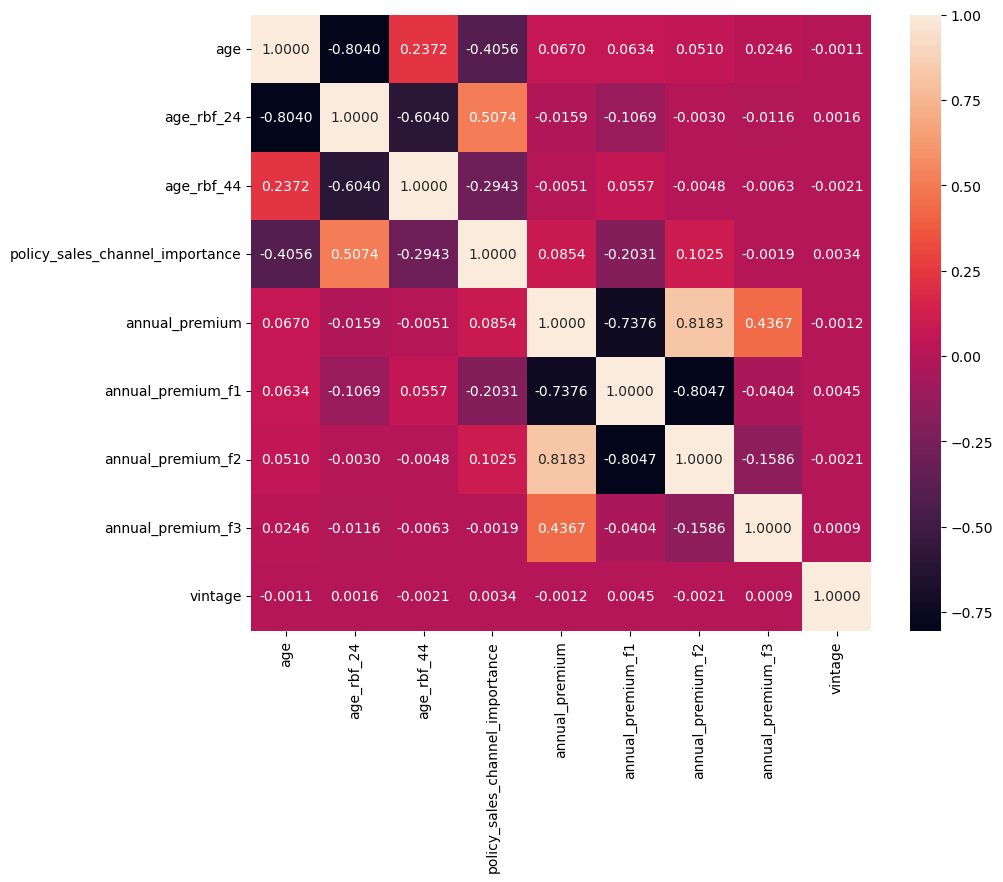

In [80]:
# Select numerical attributes for correlation

num_feat = [ 'age', 'age_rbf_24', 'age_rbf_44', 
             'policy_sales_channel_importance', 
             'annual_premium', 'annual_premium_f1', 'annual_premium_f2', 
             'annual_premium_f3', 'vintage' ]
num_attributes = df5.loc[:, num_feat].copy()

#num_vars = len(num_attributes.columns)

# calcula a matriz de correlação
#correlation_matrix = np.zeros((num_vars, num_vars))
correlation = num_attributes.corr( method='pearson' )

plt.figure( figsize=(10, 8) );
sns.heatmap(correlation, annot=True, fmt='.4f' )
#sns.heatmap( correlation, annot=True, fmt='.4f', cmap='crest', annot_kws={'color':'black'} );

plt.show()


### 5.2.2. Categorical Attributes

**OBSERVATIONS** about the following pairs of positive correlations:

**1.** 'driving_licence' & 'gender' = strong positive correlation

**2.** 'region_code' & 'policy_sales_channel' = strong positive correlation

**3.** 'previously_insured' & 'gender' = strong positive correlation

**OBSERVATIONS** about the following pairs of negative correlations:

**1.** 'previously_insured' & 'vehicle damage' = negative correlation

**2.** 'policy_sales_channel' & 'vehicle_age' = negative correlation

In [81]:
# Assembling 'correlation' matrix for categorical attributes

# Select categorical features to apply CRAMER'S V function
df_cramer = df5.loc[:,
       ['gender',         'region_code',  'driving_license', 'previously_insured',
        'vehicle_damage', 'vehicle_age',  'policy_sales_channel' ]]

num_vars = len(df_cramer.columns)
correlation_matrix = np.zeros((num_vars, num_vars))

# Create correlation matrix using CRAMER'S V function
for i in range(num_vars):
    for j in range(num_vars):
        if i != j:
            corr = cramer_v(df_cramer.iloc[:, i], df_cramer.iloc[:, j])
            correlation_matrix[i, j] = corr

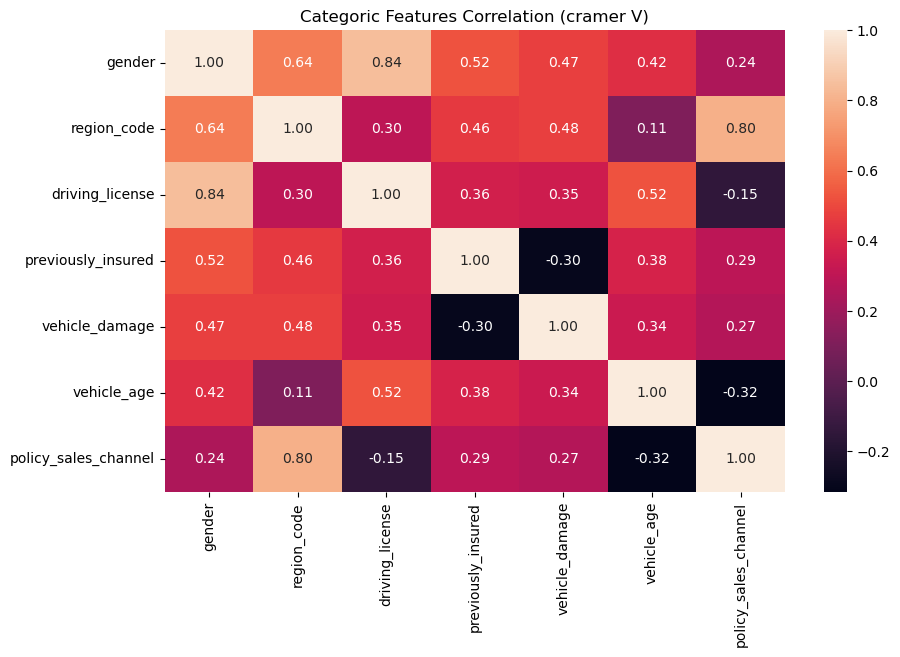

In [82]:
plt.figure(figsize=(10,6))

correlation_df = pd.DataFrame(correlation_matrix, columns=df_cramer.columns, index=df_cramer.columns)
#sns.set(font_scale=0.6)
sns.heatmap(correlation_df.corr(), annot=True, fmt='.2f');
#sns.heatmap(correlation_df.corr(), annot=True, fmt='.3f', cmap='crest');
plt.title("Categoric Features Correlation (cramer V)");

## 5.3. Testing of Hypothesis

### H1. GENDER: will not influence interest for insurance - **FALSE**

**FALSE hypothesis** More male gender people (13.82%) are interested in contracting insurance, when compared to female gender people (10.38%).

In [83]:
gender_tab3

response,0,1
gender,,
Female,89.62,10.38
Male,86.18,13.82


In [84]:
gender_tab1  # total amount per gender

,gender,qtty,qtty%
0,Female,93440,45.97
1,Male,109828,54.03


### H2. CLIENT AGE: interest for insurance will rise with age - **TRUE**

**TRUE hypothesis** People aging around 24 years are less interested (3.6%) in insurance than those around 44 years (21.5%).

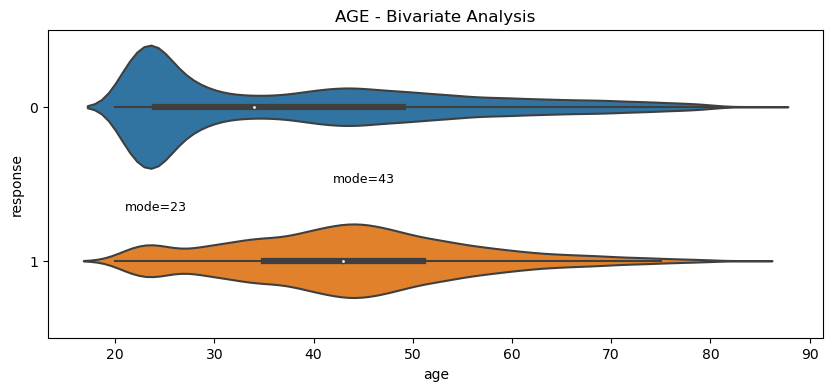

In [85]:
# AGE BIVARIATE ANALYSIS:
plt.figure(figsize=(10, 4))
sns.violinplot(y='response', x='age', orient='h', data=df5);
plt.title('AGE - Bivariate Analysis');
plt.annotate( 'mode=23', xy=(90,130), fontsize=9, xycoords='figure points' );
plt.annotate( 'mode=43', xy=(240,150), fontsize=9, xycoords='figure points' );

In [86]:
# For ages between 21 & 25 years, 3.6% are interested in insurance
# 2078 / (2078+55570) = 0,03605
aux23 = df5.loc[ (df5['age']>20) & (df5['age']<26), ['response','id'] ].groupby('response').count().reset_index()
aux23

,response,id
0,0,55570
1,1,2078


In [87]:
# For ages between 39 & 47 years, 21.5% are interested in insurance
# 7965 / (7965+29152) = 0,21459
aux43 = df5.loc[ (df5['age']>38) & (df5['age']<48), ['response','id'] ].groupby('response').count().reset_index()
aux43

,response,id
0,0,29152
1,1,7965


### H3. DRIVING LICENSE: the interest for insurance tends to rise after aquiring a license - **TRUE**

**TRUE hypothesis** From those with driving license, 12.23% are interested in insurance, while just 4.49% of those not licensed are.

In [88]:
drivinglicence_tab2

response,0,1
driving_license,,
0,95.87,4.13
1,87.74,12.26


### H4. REGION CODE: some regions may generate more interest for insurance than others - **TRUE**

**TRUE hypothesis** Some regions present more clients interested in insurance. That can be due to demographic characteristics, like regions with higher crime rates or simply due to more vehicles in an area.

In [89]:
aux1 = df5.loc[:, ['region_code', 'response'] ].groupby('region_code').sum().reset_index()
aux2 = df5.loc[:, ['region_code', 'id'] ].groupby('region_code').count().reset_index()
regcode = pd.merge( aux1, aux2, how="inner", on=['region_code'] )
regcode.columns = ['region_code', 'response1', 'qtd']
regcode['response0'] = regcode['qtd'] - regcode['response1']
regcode['response%'] = regcode['response1'] / regcode['qtd']

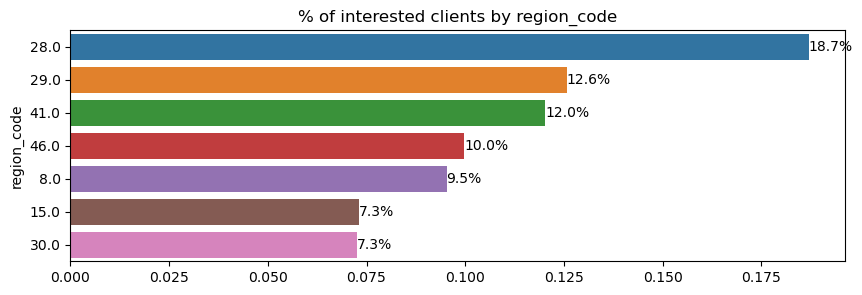

In [90]:
# % of pts where response=1
plt.figure(figsize=(10, 3))
aux = regcode.loc[ regcode['qtd']>5604 , ['region_code', 'response%' ] ].sort_values('response%', ascending=False).copy()
b3 = sns.barplot( aux, y='region_code', x='response%', orient='h', order=aux['region_code'] );
b3.set_xlabel('')
for i in b3.containers:
    b3.bar_label(i, label_type='edge', fmt=lambda x: f'{100 * x:0.1f}%')
    #b3.bar_label(i, label_type='edge')
plt.title('% of interested clients by region_code')
plt.show()

### H5. PREVIOUSLY INSURED: those insured by other insurance companies will be less inclined to become our clients - **TRUE**

**TRUE hypothesis** From those already insured, only less than 0.1% are interested in becoming our client.

- **(1)** From the whole database, 54% of customers do not have a vehicle insurance, while 46% already have it.

- **(2)** From those who do not have a vehicle insurance, 22,56% are interested in contracting one.

- **(3)** On the other hand, from those who already have it, 99,9% have NO interest in buying a vehicle insurance.

In [91]:
previouslyinsured_tab

response,0,1
previously_insured,,
0,77.44,22.56
1,99.91,0.09


### H6. VEHICLE AGE: the newer the vehicle, the bigger the interest for insurance - **FALSE**

**FALSE hypothesis** Clients with older cars (older than one year) are more inclined to purchase a vehicle insurance, while those with newer cars are less interested. That happens even considering only those who do not already have this kind of insurance.

- **(1)** The third-table consider only those who do not have a previous car insurance (previously_insured = 0). It shows that people with newer cars are less inclined to purchase our car insurance product.


In [92]:
# FIRST TABLE
vehicleage_tab

response,0,1
vehicle_age,,
bellow_1_year,95.64,4.36
between_1_2_years,82.65,17.35
over_2_years,70.63,29.37


In [93]:
# SECOND TABLE
# Let's analyse "vehicle_age", given "previously_insured" = 0
df_not_previously_insured = df5.loc[ df5['previously_insured']==0, ['vehicle_age', 'response', 'id'] ]
# Contingency table
pd.crosstab( df_not_previously_insured['vehicle_age'], df_not_previously_insured['response'] )


response,0,1
vehicle_age,,
bellow_1_year,25717,3802
between_1_2_years,53320,18458
over_2_years,6062,2532


In [94]:
# THIRD TABLE
# Percentual contingency table
pd.crosstab( df_not_previously_insured['vehicle_age'], df_not_previously_insured['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )

response,0,1
vehicle_age,,
bellow_1_year,87.12,12.88
between_1_2_years,74.28,25.72
over_2_years,70.54,29.46


### H7. ANNUAL PREMIUM: higher values will result in less interest for insurance - **TRUE**

**TRUE hypothesis** The so-called "low budget group" shows a discretly higher interest for insurance (13.08% against the average 12.22%).

- **(1)** Annual Premium values comprise three groups of values, which can be named Low Budget Group (f1), Main Group (f2), Extreme Group (f3)

- **(2)** Low budget group - the cheapest premium (= $2.630) occurs in 17% of the database.

- **(3)** Main group - 82% of the database includes insurance premiums ranging from $6.098 to $74.300

- **(4)** Extreme group - 0,9% of the cases range from $74.305 to the maximum value of $540.165 [sounds like an outliers group]

In [95]:
annualpremium_tab

,response,annual_premium,ap%,annual_premium_f1,apf1%,annual_premium_f2,apf2%,annual_premium_f3,apf3%
0,0,178389,87.76,30058,87.0,146702,87.94,1629,85.92
1,1,24879,12.24,4492,13.0,20120,12.06,267,14.08


### H8. POLICY SALES CHANNEL: some channels may be more effective in aquiring new clients - **TRUE**

**TRUE hypothesis** There are six channels which are far better then the other 149 ones.

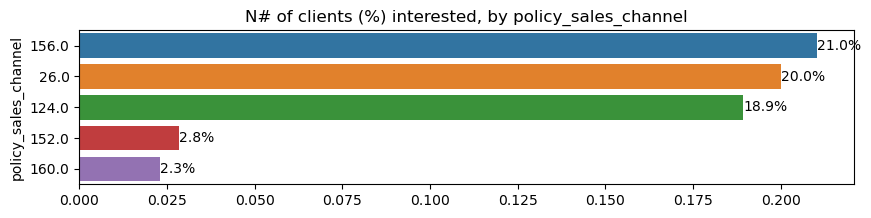

In [96]:
aux1 = df5.loc[:, ['policy_sales_channel', 'response'] ].groupby('policy_sales_channel').sum().reset_index()
aux2 = df5.loc[:, ['policy_sales_channel', 'id'] ].groupby('policy_sales_channel').count().reset_index()
regcode = pd.merge( aux1, aux2, how="inner", on=['policy_sales_channel'] )
regcode.columns = ['policy_sales_channel', 'response1', 'qtd']
regcode['response0'] = regcode['qtd'] - regcode['response1']
regcode['response%'] = regcode['response1'] / regcode['qtd']

# POLICY SALES CHANNEL: BIVARIATE ANALYSIS
plt.figure(figsize=(10, 2))
aux = regcode.loc[ regcode['qtd']>5604 , ['policy_sales_channel', 'response%' ] ].sort_values('response%', ascending=False).copy()
b3 = sns.barplot( aux, y='policy_sales_channel', x='response%', orient='h', order=aux['policy_sales_channel'] );
b3.set_xlabel('')
for i in b3.containers:
    b3.bar_label(i, label_type='edge', fmt=lambda x: f'{100 * x:0.1f}%')
    #b3.bar_label(i, label_type='edge')

plt.title( 'N# of clients (%) interested, by policy_sales_channel' );
plt.show()

### H9. VINTAGE: longer time clients tend to continue clients, supposing they are satisfied with the quality of offered service - **FALSE**

**FALSE hypothesis** 'vintage' shows almost uniform distribution. Probably, no benefit to the present study.

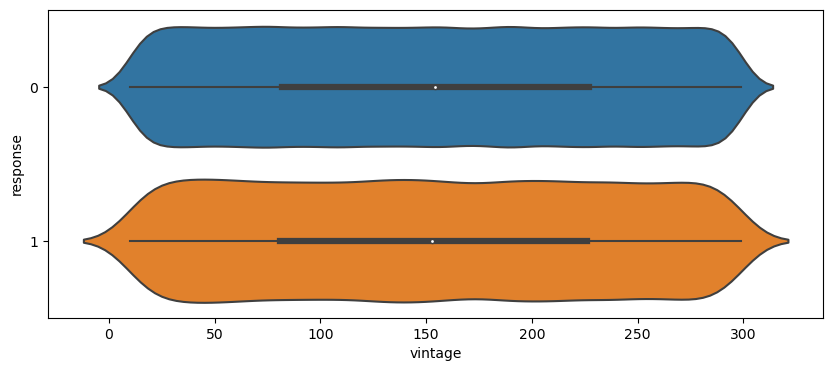

In [97]:
# Bivariate Analysis
plt.figure(figsize=(10, 4))
sns.violinplot(y='response', x='vintage', orient='h', data=df5);

# 6. DATA PREPARATION

## 6.1. Prepare train & validation datasets

In [98]:
# Prepare train & validation sets, to be used in single-validation

# create object
data_preparation_models = DataFitAndTransform()

# Simple conversion of "vehicle_damage", "vehicle_age" and "annual_premium"
x_train = data_preparation_models.simple_conversion_of_categorical_features(x_train)
x_validation = data_preparation_models.simple_conversion_of_categorical_features(x_validation)

# Fit to create (& apply) econdings
x_train_prep = data_preparation_models.DataFitting(x_train, y_train)
y_train_prep = y_train  # readability

# transform
x_validation_prep = data_preparation_models.DataTransforming(x_validation)
y_validation_prep = y_validation

( x_train.shape, x_train_prep.shape, x_validation.shape, x_validation_prep.shape )


((203268, 14), (203268, 20), (50817, 14), (50817, 20))

In [99]:
x_train.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'annual_premium_f1',
       'annual_premium_f2', 'annual_premium_f3'],
      dtype='object')

In [100]:
x_train_prep.columns

Index(['id', 'age', 'driving_license', 'region_code', 'previously_insured',
       'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage',
       'annual_premium_f1', 'annual_premium_f2', 'annual_premium_f3',
       'gender_Female', 'gender_Male', 'policy_sales_channel_importance',
       'age_rbf_24', 'age_rbf_44', 'vehicle_age_bellow_1_year',
       'vehicle_age_between_1_2_years', 'vehicle_age_over_2_years'],
      dtype='object')

In [101]:
x_train_val.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage'],
      dtype='object')

## 6.2. rows filtering

In [102]:
# Delete all ROWS in 'train' where 'annual_premium_f3' <> 0
aux = x_train_prep
aux['response'] = y_train_prep
aux = aux[ (aux['annual_premium_f3'] == 0) ]
x_train_prep = aux.drop( 'response', axis=1 )
y_train_prep = aux['response'].copy()
( x_train.shape, x_train_prep.shape, y_train_prep.shape )

((203268, 14), (201372, 20), (201372,))

## 6.3. cols filtering

In [103]:
# Delete 'annual_premium_f3' COLUMN in train & val
x_train_prep = x_train_prep.drop( 'annual_premium_f3', axis=1 )
x_validation_prep = x_validation_prep.drop( 'annual_premium_f3', axis=1 )
( x_train_prep.shape, y_train_prep.shape, x_validation_prep.shape, y_validation_prep.shape )

((201372, 19), (201372,), (50817, 19), (50817,))

## 6.4. Resampling (x_train)

In [104]:
# Informing: characteristics of "Response" variable: 2 categories - 0/1
targ = df1.loc[:, ['response', 'id'] ].groupby('response').count().reset_index()
targ['perc'] = round(100. * targ['id'] / df1.shape[0], 2)
targ.columns = ['response', 'qtty', 'qtty%']
targ

,response,qtty,qtty%
0,0,223000,87.77
1,1,31085,12.23


- The TARGET data is unballanced, with **~88%** of ZEROES & **~12%** of ONES

- Possible solutions:

- **(1)** SMOTE + Tomek

- **(2)** ADASYN

- **(3)** Balanced Random Forest Classifier

- **(4)** Balanced RFC with balanced classes

In [105]:
# Solution used: SMOTE + Tomek
x_train_prep, y_train_prep = SMOTETomek(random_state=42).fit_resample(x_train_prep, y_train_prep)

(x_train_prep.shape, y_train_prep.shape)

((315000, 19), (315000,))

# 7. FEATURE IMPORTANCE / SELECTION

In [106]:
Run_Feature_Importance = True

In [107]:
# save a copy
x_train_prep1 = x_train_prep
x_validation_prep1 = x_validation_prep
#x_test_prep1 = x_test_prep

## 7.0 functions

### Single-Validation function

In [108]:
def performance_metrics_at_k( data, k=20000 ):
    """
    Calculates metrics to the first "k" points of "data"

    Args:
    data: DataFrame containing predictions sorted by score.
    k: position up to which recall is calculated.

    Returns: precision, recall, f1, TN, FP, FN, TP
    """
    df = data.head(k)

    df = df.reset_index(drop=True)

    # metrics
    precision_k = precision_score(df['response'], df['preview'])
    recall_k = recall_score(df['response'], df['preview'])
    f1_k = f1_score(df['response'], df['preview'])
    cm_k = mt.confusion_matrix( df['response'], df['preview'] )
    print( f"TOT={k}  TP={cm_k[1,1]}  FP={cm_k[0,1]}  FN={cm_k[1,0]}  TN={cm_k[0,0]}" )

    # list of return values
    ret_val = [
        precision_k,
        recall_k,
        f1_k,
        cm_k[0,0],  # TN
        cm_k[0,1],  # FP
        cm_k[1,0],  # FN
        cm_k[1,1],  # TP
    ]
    return ret_val


In [109]:
def single_validation_metrics(model_name, x_val, y_val, yhat_proba, yhat ):

    # metrics
    data = x_val.copy()
    data['response'] = y_val.copy()
    data['preview'] = yhat.copy()
    data['score'] = yhat_proba[:, 1].tolist()
    data = data.sort_values('score', ascending=False)

    cm = mt.confusion_matrix( y_val, yhat )
    print( f"TOT={data.shape[0]}  TP={cm[1,1]}  FP={cm[0,1]}  FN={cm[1,0]}  TN={cm[0,0]}" )

    # Why k=20000? See problem definition
    vals = performance_metrics_at_k( data, 20000 )
    nprec_k20 = vals[0]
    nrec_k20 = vals[1]
    f1_k20 = vals[2]
    tn_k20 = vals[3]
    fp_k20 = vals[4]
    fn_k20 = vals[5]
    tp_k20 = vals[6]
    # Why k=40000? See problem definition
    vals = performance_metrics_at_k( data, 40000 )
    nprec_k40 = vals[0]
    nrec_k40 = vals[1]
    f1_k40 = vals[2]
    tn_k40 = vals[3]
    fp_k40 = vals[4]
    fn_k40 = vals[5]
    tp_k40 = vals[6]

    # return dataframe with calculated metrics
    ndecs = 6
    df = pd.DataFrame({
        'Model Name': model_name,
        'Accuracy': 100. * np.round(accuracy_score(y_val, yhat), ndecs),
        'Precision': 100. * np.round(precision_score(y_val, yhat), ndecs),
        'Recall': 100. * np.round(recall_score(y_val, yhat), ndecs),
        'F1': 100. * f1_score(y_val, yhat),
        'cm.pos': f"TP={cm[1,1]}  FP={cm[0,1]}",
        'cm.neg': f"FN={cm[1,0]}  TN={cm[0,0]}  TOT={data.shape[0]}",
        'Precision@20k': 100. * np.round(nprec_k20, ndecs),
        'Recall@20k': 100. * np.round(nrec_k20, ndecs),
        'F1@20k': 100. * np.round(f1_k20, ndecs),
        'cm.pos.20k': f"TP={tp_k20}  FP={fp_k20}",
        'cm.neg.20k': f"FN={fn_k20}  TN={tn_k20}  TOT=20k",
        'Precision@40k': 100. * np.round(nprec_k40, ndecs),
        'Recall@40k': 100. * np.round(nrec_k40, ndecs),
        'F1@40k': 100. * np.round(f1_k40, ndecs),
        'cm.pos.40k': f"TP={tp_k40}  FP={fp_k40}",
        'cm.neg.40k': f"FN={fn_k40}  TN={tn_k40}  TOT=40k",
    }, index=[0])

    return df

In [110]:
#def precision_at_k(data, k=20000):
#    """
#    Calculates precision up to the first "k" points of "data"
#    
#    Args:
#    data: DataFrame containing predictions sorted by score.
#    k: position up to which precision is calculated.

#    Returns:
#    precision_at_k: precision at point k.
#    data: updated DataFrame.
#    """
#    data = data.reset_index(drop=True)
#    # create ranking order
#    data['ranking'] = data.index + 1
#    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
#    return data.loc[k, 'precision_at_k'], data

#def recall_at_k(data, k=20000):
#    """
#    Calculates recall up to the first "k" points of "data"

#    Args:
#    data: DataFrame containing predictions sorted by score.
#    k: position up to which recall is calculated.

#    Returns:
#    recall_at_k: recall at point k.
#    data: updated DataFrame.
#    """
#    data = data.reset_index(drop=True)
#    # create ranking order
#    data['ranking'] = data.index + 1
#    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
#    return data.loc[k, 'recall_at_k'], data

### Cross-Validation function

In [111]:
def cross_validation(model, x_train, y_train, n_of_folds, selected_features):
    """
    Performs stratified k-fold cross-validation on a machine learning model.

    Args:
    model: machine learning model to be trained and evaluated.
    x_train: DataFrame containing the training features.
    y_train: Series containing the training labels.
    n_of_folds: number of folds for cross-validation.
    Verbose: if True, prints progress information.

    Returns:
    df: DataFrame containing model performance metrics.
    """
    
    # Initialize StratifiedKFold to ensure class proportion in each fold
    kfold = ms.StratifiedKFold(n_splits=n_of_folds, shuffle=True, random_state=28)

    encoder = DataFitAndTransform()
    x_train = encoder.simple_conversion_of_categorical_features(x_train)

    # Initialize lists to store metrics
    balanced_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []
#    precision_k_list = []
    precision_20k_list = []
    precision_40k_list = []
#    recall_k_list = []
    recall_20k_list = []
    recall_40k_list = []
    f1_20k_list = []
    f1_40k_list = []
    tp_20k_list = []
    tn_20k_list = []
    fp_20k_list = []
    fn_20k_list = []
    tp_40k_list = []
    tn_40k_list = []
    fp_40k_list = []
    fn_40k_list = []

    i = 1  # Fold counter

    # Perform cross-validation
    for train_cv, val_cv in kfold.split(x_train, y_train):

        print(f'{i}', end=" ")
        #print( f"x_in={x_train.shape}  y={y_train.shape}" )

        # Split the data into training and validation sets for the current fold
        x_train_fold = x_train.iloc[train_cv].copy()
        y_train_fold = y_train.iloc[train_cv].copy()
        x_val_fold = x_train.iloc[val_cv].copy()
        y_val_fold = y_train.iloc[val_cv].copy()

        # From 6.1 - Fit training fold & transform validation fold
        #print( f"x_tr_fold={x_train_fold.shape}  y={y_train_fold.shape}" )
        x_train_fold_encoded = encoder.DataFitting(x_train_fold, y_train_fold)
        #print( f"x_val_fold={x_val_fold.shape}" )
        x_val_fold_encoded = encoder.DataTransforming(x_val_fold)
        # From 6.2 - rows filtering
        aux = x_train_fold_encoded
        aux['response'] = y_train_fold
        aux = aux[ (aux['annual_premium_f3'] == 0) ]
        x_train_fold_encoded = aux.drop( 'response', axis=1 )
        y_train_fold = aux['response'].copy()
        # From 6.3 - cols filtering
        x_train_fold_encoded = x_train_fold_encoded.drop( 'annual_premium_f3', axis=1 )
        x_val_fold_encoded = x_val_fold_encoded.drop( 'annual_premium_f3', axis=1 )
        # From 6.4 - Apply resampling (SMOTE + Tomek)
        x_train_fold_encoded, y_train_fold = (
            SMOTETomek(random_state=42).fit_resample(x_train_fold_encoded, y_train_fold)
        )
        # From 7.8 and 8.0 - Filter selected features
        #selected_features = encoder.GetSelectedFeatures()
        #print( f"selected = {selected_features}" )
        x_train_fold_encoded = x_train_fold_encoded[ selected_features ]
        x_val_fold_encoded = x_val_fold_encoded[ selected_features ]

        # Train the model on the current fold
        #print( f"x_encoded={x_train_fold_encoded.shape}  y={y_train_fold.shape}" )
        #print( x_train_fold_encoded.sample(4).T )
        model.fit(x_train_fold_encoded, y_train_fold.values.ravel())

        # Make probability and label predictions on the validation set
        yhat = model.predict_proba(x_val_fold_encoded)
        yhat_1 = model.predict(x_val_fold_encoded)

        # Prepare data for metrics calculation
        validation_data = x_val_fold_encoded.copy()
        validation_data['response'] = y_val_fold.copy()
        validation_data['score'] = yhat[:, 1].tolist()
        validation_data = validation_data.sort_values('score', ascending=False)

        # Calculate and store precision
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        # Calculate and store recall
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)
        # Calculate and store balanced accuracy
        balanced_accuracy = balanced_accuracy_score(y_val_fold, yhat_1)
        balanced_list.append(balanced_accuracy)
        # Calculate and store f1
        f1 = f1_score(y_val_fold, yhat_1)
        f1_list.append(f1)
        # Calculate Confusion Matrix
        cm = mt.confusion_matrix( y_val_fold, yhat_1 )
        tp_list.append(cm[1,1])
        tn_list.append(cm[0,0])
        fp_list.append(cm[0,1])
        fn_list.append(cm[1,0])

        # Calculate and store metrics at k
        data = x_val_fold_encoded.copy()
        data['response'] = y_val_fold.copy()
        data['preview'] = yhat_1.copy()
        data['score'] = yhat[:, 1].tolist()  # ...proba
        data = data.sort_values('score', ascending=False)
        # Metrics for k = 20k
        vals = performance_metrics_at_k( data, 20000 )
        precision_20k_list.append(vals[0])
        recall_20k_list.append(vals[1])
        f1_20k_list.append(vals[2])
        tn_20k_list.append(vals[3])
        fp_20k_list.append(vals[4])
        fn_20k_list.append(vals[5])
        tp_20k_list.append(vals[6])
        # Metrics for k = 40k
        vals = performance_metrics_at_k( data, 40000 )
        precision_40k_list.append(vals[0])
        recall_40k_list.append(vals[1])
        f1_40k_list.append(vals[2])
        tn_40k_list.append(vals[3])
        fp_40k_list.append(vals[4])
        fn_40k_list.append(vals[5])
        tp_40k_list.append(vals[6])

        i += 1  # Increment fold counter

    # Create a DataFrame with calculated metrics
    df = pd.DataFrame({
        'Model Name': type(model).__name__,
        'Balanced Accuracy Mean': 100.0 * np.mean(balanced_list),
        'Precision Mean': 100.0 * np.round(np.mean(precision_list), 7),
        'Precision STD': 100.0 * np.round(np.std(precision_list), 4),
        'Recall Mean': 100.0 * np.round(np.mean(recall_list), 7),
        'Recall STD': 100.0 * np.round(np.std(recall_list), 4),
        'F1 Mean': 100.0 * np.round(np.mean(f1_list), 7),
        'F1 STD': 100.0 * np.round(np.std(f1_list), 4),
        'cm.pos': f"TP={int(np.mean(tp_list))}  FP={int(np.mean(fp_list))}",
        'cm.neg': f"FN={int(np.mean(fn_list))}  TN={int(np.mean(tn_list))}  TOT={x_train.shape[0]}",
        'Precision@20k Mean': 100.0 * np.round(np.mean(precision_20k_list), 7),
        'Precision@20k STD': 100.0 * np.round(np.std(precision_20k_list), 4),
        'Recall@20k Mean': 100.0 * np.round(np.mean(recall_20k_list), 7),
        'Recall@20k STD': 100.0 * np.round(np.std(recall_20k_list), 4),
        'F1@20k Mean': 100.0 * np.round(np.mean(f1_20k_list), 7),
        'F1@20k STD': 100.0 * np.round(np.std(f1_20k_list), 4),
        'TP@20k': int(np.mean(tp_20k_list)),
        'cm.pos.20k': f"TP={int(np.mean(tp_20k_list))}  FP={int(np.mean(fp_20k_list))}",
        'cm.neg.20k': f"FN={int(np.mean(fn_20k_list))}  TN={int(np.mean(tn_20k_list))}  TOT=20k",
        'Precision@40k Mean': 100.0 * np.round(np.mean(precision_40k_list), 7),
        'Precision@40k STD': 100.0 * np.round(np.std(precision_40k_list), 4),
        'Recall@40k Mean': 100.0 * np.round(np.mean(recall_40k_list), 7),
        'Recall@40k STD': 100.0 * np.round(np.std(recall_40k_list), 4),
        'F1@40k Mean': 100.0 * np.round(np.mean(f1_40k_list), 7),
        'F1@40k STD': 100.0 * np.round(np.std(f1_40k_list), 4),
        'cm.pos.40k': f"TP={int(np.mean(tp_40k_list))}  FP={int(np.mean(fp_40k_list))}",
        'cm.neg.40k': f"FN={int(np.mean(fn_40k_list))}  TN={int(np.mean(tn_40k_list))}  TOT=40k",
    }, index=[0])
    
    return df


### KNN Optimization Function

In [112]:
# There was a time when KNN sounded like the best model...
def KNN_optimization( k_init, k_end, in_weights='uniform', in_metric='minkowski', in_p=2 ):

    Precision_list = list()
    F1_list = list()
    best_k_f1 = 0
    best_F1 = 0

    best_k_pr = 0
    best_Precision = 0
    knn_BestClassifier = 0

    Recall_list = list()
    best_k_rc = 0
    best_Recall = 0

    KK = range( k_init, k_end+1, 2 )
    for k in KK:

        print(k, end = " ")
        knn_classifier = KNeighborsClassifier( 
                            n_neighbors = k,
                            weights = in_weights,
                            metric = in_metric,
                            p = in_p
                        )
        knn_classifier.fit( x_train_prep, y_train_prep )
        yhat_val = knn_classifier.predict( x_validation_prep )
        # Save result in dataset
        df_result = x_validation_prep.copy()
        df_result['classification'] = yhat_val

        # Performance Metrics
        Precision = mt.precision_score( y_validation_prep, yhat_val )
        Recall = mt.recall_score( y_validation_prep, yhat_val )
        F1 = mt.f1_score( y_validation_prep, yhat_val )

        Precision_list.append(Precision)
        Recall_list.append(Recall)
        F1_list.append(F1)

        if Recall > best_Recall:
            best_Recall = Recall
            best_k_rc = k

        if Precision > best_Precision:
            best_Precision = Precision
            best_k_pr = k

        if F1 > best_F1:
            best_F1 = F1
            best_k_f1 = k
            knn_BestClassifier = knn_classifier
            print( f"\nk={k}  F1={best_F1}", end = " " )

    # Show best result:
    print(f"\nKNN - best Precision .. k: {best_k_pr}")
    print(  f"KNN - best F1 ......... k: {best_k_f1}")
    print(  f"KNN - best Recall ..... k: {best_k_rc}")

    # Create a list with the return values
    retlist = [
        knn_BestClassifier,
        best_k_f1,
        best_k_rc, 
        Precision_list, 
        Recall_list,
        KK,
        best_k_pr
    ]
    return retlist


## 7.1 Feature Importance: Boruta + ExtraTrees

In [113]:
x_train_prep.columns

Index(['id', 'age', 'driving_license', 'region_code', 'previously_insured',
       'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage',
       'annual_premium_f1', 'annual_premium_f2', 'gender_Female',
       'gender_Male', 'policy_sales_channel_importance', 'age_rbf_24',
       'age_rbf_44', 'vehicle_age_bellow_1_year',
       'vehicle_age_between_1_2_years', 'vehicle_age_over_2_years'],
      dtype='object')

In [114]:
if Run_Feature_Importance:

    x_train_n = x_train_prep.drop( ['id'], axis=1).values
    y_train_n = y_train_prep.values.ravel()

    # Define model
    et = en.ExtraTreesClassifier( n_jobs=-1 )

    # Define boruta
    np.int = np.int32
    np.float = np.float64
    np.bool = np.bool_
    boruta = BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit(x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	1


In [115]:
cols_selected_boruta = 0
cols_not_selected_boruta = 0

if Run_Feature_Importance:

    cols_selected = boruta.support_.tolist()

    # best features
    x_train_fs = x_train_prep.drop( ['id'], axis=1 )
    cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

    # not selected boruta
    cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

cols_selected_boruta

['age',
 'region_code',
 'previously_insured',
 'vehicle_damage',
 'annual_premium',
 'policy_sales_channel',
 'vintage',
 'annual_premium_f1',
 'annual_premium_f2',
 'gender_Female',
 'gender_Male',
 'policy_sales_channel_importance',
 'age_rbf_24',
 'age_rbf_44',
 'vehicle_age_bellow_1_year',
 'vehicle_age_between_1_2_years',
 'vehicle_age_over_2_years']

In [116]:
cols_not_selected_boruta

# 23.7.2024: cols_not_selected_boruta = ['annual_premium_f3', 'driving_license']
# Results similar to 5.1.1 & 5.1.2

['driving_license']

## 7.2 Feature Importance: ExtraTrees

In [117]:
# Alternative to BORUTA

if Run_Feature_Importance:

    # model definition
    forest = en.ExtraTreesClassifier( n_estimators=1000, random_state=42, n_jobs=-1 )

    # data preparation
    x_train_n = x_train_prep.drop( ['id'], axis=1 )
    y_train_n = y_train_prep.values
    forest.fit( x_train_n, y_train_n )

Feature ranking:
                           feature  importance
0               previously_insured    0.173280
0                   vehicle_damage    0.129807
0                      region_code    0.101943
0                       age_rbf_44    0.066955
0  policy_sales_channel_importance    0.056848
0             policy_sales_channel    0.055244
0        vehicle_age_bellow_1_year    0.054198
0    vehicle_age_between_1_2_years    0.047662
0                              age    0.044853
0                       age_rbf_24    0.043638
0                          vintage    0.041440
0                annual_premium_f2    0.037334
0                   annual_premium    0.036364
0                      gender_Male    0.035437
0                    gender_Female    0.034436
0                annual_premium_f1    0.026948
0         vehicle_age_over_2_years    0.013293
0                  driving_license    0.000320


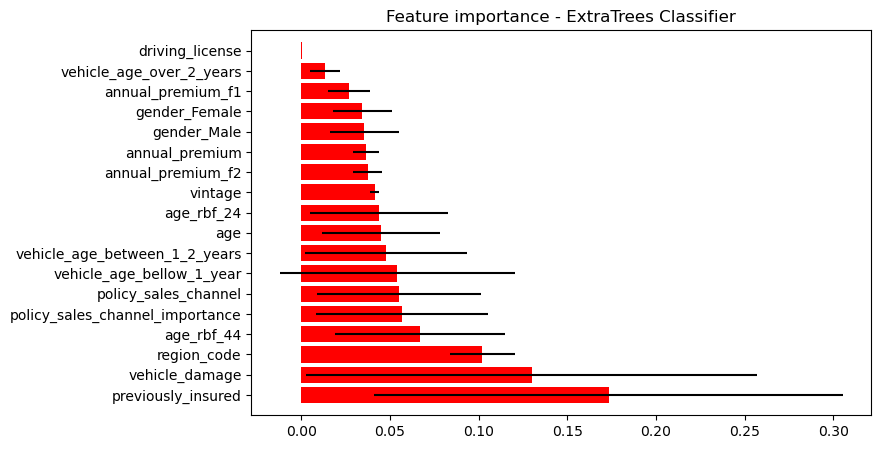

In [118]:
if Run_Feature_Importance:

    importances = forest.feature_importances_
    std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
    indices = np.argsort(importances)[::-1]

    # print feature ranking
    print("Feature ranking:")
    df = pd.DataFrame()
    for i, j in zip( x_train_n, forest.feature_importances_ ):
        aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
        df = pd.concat( [df, aux], axis=0 )

    df = df.sort_values( 'importance', ascending=False )
    print( df )

    # Plot the impurity-based feature importance from random forest
    plt.figure( figsize=(8, 5) )
    plt.title( "Feature importance - ExtraTrees Classifier" )
    plt.barh( df['feature'], df['importance'], color="r", xerr=std[indices] )
    plt.yticks( range(x_train_n.shape[1]), df['feature'] )
    plt.ylim( [-1, x_train_n.shape[1]] )
    plt.show()

## 7.3 Feature Importance: Boruta + LightGBM

In [119]:
if Run_Feature_Importance:

    x_train_n = x_train_prep.drop( ['id'], axis=1).values
    y_train_n = y_train_prep.values.ravel()

    # define RandomForestRegressor
    lgb = LGBMClassifier( n_estimators=100, random_state=42, n_jobs=-1, verbose=-1 )

    # Define boruta
    boruta = BorutaPy( estimator=lgb, n_estimators=100, verbose=2, random_state=42 )
    boruta.fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	3
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	3
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	3
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	3
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	4
I

In [120]:
cols_selected = 0
cols_not_selected_boruta = 0

if Run_Feature_Importance:

    cols_selected = boruta.support_.tolist()

    # best features
    x_train_fs = x_train_prep.drop( ['id'], axis=1 )
    cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

    # not selected boruta
    cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

cols_selected_boruta

['age',
 'region_code',
 'previously_insured',
 'vehicle_damage',
 'annual_premium',
 'policy_sales_channel',
 'annual_premium_f1',
 'gender_Female',
 'age_rbf_24',
 'age_rbf_44',
 'vehicle_age_bellow_1_year',
 'vehicle_age_between_1_2_years']

In [121]:
cols_not_selected_boruta

# 23.7.2024: ['annual_premium_f3', 'driving_license', 'gender_Male', 'vintage', 'vehicle_age_over_2_years']
# 12.8.2024: ['annual_premium_f3', 'driving_license', 'gender_Male', 'vintage']
# 16.9.2024: ['annual_premium_f2', 'driving_license', 'gender_Male', 'policy_sales_channel_importance']


['annual_premium_f2',
 'driving_license',
 'gender_Male',
 'policy_sales_channel_importance',
 'vehicle_age_over_2_years',
 'vintage']

## 7.4 Feature Importance: LightGBM

In [122]:
# Alternative to BORUTA

if Run_Feature_Importance:

    # model definition
    lgb = LGBMClassifier( n_estimators=1000, random_state=42, n_jobs=-1, verbose=-1 )

    # data preparation
    x_train_n = x_train_prep.drop( ['id'], axis=1 )
    y_train_n = y_train_prep.values
    lgb.fit( x_train_n, y_train_n )

Feature ranking:
                           feature  importance
0                      region_code        8226
0                          vintage        4796
0                   annual_premium        3294
0             policy_sales_channel        2484
0                              age        2473
0                       age_rbf_24        2393
0                       age_rbf_44        2184
0                annual_premium_f2        1016
0                   vehicle_damage         691
0               previously_insured         525
0                    gender_Female         499
0                      gender_Male         361
0                annual_premium_f1         345
0    vehicle_age_between_1_2_years         319
0        vehicle_age_bellow_1_year         215
0         vehicle_age_over_2_years         174
0                  driving_license           5
0  policy_sales_channel_importance           0


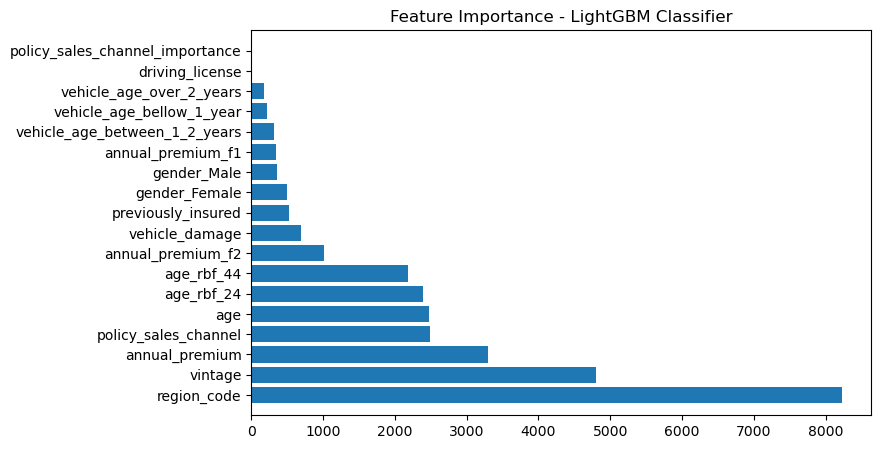

In [123]:
if Run_Feature_Importance:

    # Obter a importância das características
    importances = lgb.feature_importances_

    # Obter os índices das características ordenadas pela importância
    indices = np.argsort(importances)[::-1]

    # Imprimir as características e suas importâncias ordenadas
    print("Feature ranking:")
    df = pd.DataFrame()
    for i, j in zip( x_train_n, lgb.feature_importances_ ):
        aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
        df = pd.concat( [df, aux], axis=0 )

    df = df.sort_values( 'importance', ascending=False )
    print( df )

    # Ordenar as características por importância
    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_indices]
    sorted_features = x_train_n.columns[sorted_indices]

    # Criar o gráfico de barras
    plt.figure(figsize=(8, 5))
    plt.title("Feature Importance - LightGBM Classifier")
    plt.barh(range(x_train_n.shape[1]), sorted_importances, align='center')
    plt.yticks(range(x_train_n.shape[1]), sorted_features)
    plt.ylim([-1, x_train_n.shape[1]])
    plt.show()

## 7.5 Gradual Exclusion of Features

- More properly called: "Recursive Feature Elimination"

In [124]:
# get a copy of the dataframe (in case you want to run from here)
x_train_prep = x_train_prep1
x_validation_prep = x_validation_prep1
#x_test_prep = x_test_prep1

### Logistic Regression

In [198]:
cols_selected_boruta = [
# 'age',
 'age_rbf_24',
# 'age_rbf_44',
 'annual_premium',
 'annual_premium_f1',
 'annual_premium_f2',
 'driving_license',
 'gender_Female',
 'gender_Male',
 'policy_sales_channel',
 'policy_sales_channel_importance',
 'previously_insured',
 'region_code',
 'vehicle_age_bellow_1_year',
 'vehicle_age_between_1_2_years',
# 'vehicle_age_over_2_years',
 'vehicle_damage',
 'vintage',
]


In [ ]:
#............... Exclude features, one after the other, and adjust the model
# (runs fast...)
if Run_Feature_Importance:

    Single0_1CrossVal = False

    #............... Default case
    selected_features = cols_selected_boruta
    # prepare dataframe
    x_train_prep = x_train_prep1[ selected_features ]
    x_validation_prep = x_validation_prep1[ selected_features ]
    # KNN Optimization
    print("")
    print(f"==================== Benchmark case ====================")
    print(f"selected features = {selected_features}")
    lr_model = lm.LogisticRegression( random_state=42 )
    lr_model.fit( x_train_prep, y_train_prep )

    # model prediction - verifica o poder de generalização (não o de aprendizado)
    yhat_lr = lr_model.predict_proba( x_validation_prep )
    yhat_lr_1 = lr_model.predict( x_validation_prep )

    # Metrics
    if Single0_1CrossVal:
        lr_result = cross_validation( lr_model, 
                                        x_train, y_train, 
                                        2, 
                                        data_preparation_models, True )
        lr_result = lr_result.rename(columns={'Precision@20k Mean': 'Precision@20k'})
    else:
        lr_result = single_validation_metrics( 
                        type(lr_model).__name__, 
                        x_validation_prep, y_validation_prep,
                        yhat_lr, yhat_lr_1 )

    print(lr_result.T)
    lr_result['Model Name'] = 'benchmark'
    all_results = lr_result

    for i in range( len( cols_selected_boruta ) ):
        if i<0:     # adjust this threshold (from zero on) to start from where you stopped before.
            continue
        selected_features = cols_selected_boruta[:i] + cols_selected_boruta[i+1:]
        # prepare dataframe
        x_train_prep = x_train_prep1[ selected_features ]
        x_validation_prep = x_validation_prep1[ selected_features ]
        # Model Optimization
        print("")
        print(f"==================== {i} without: {cols_selected_boruta[i]} ====================")
        #print(f"selected features = {selected_features}")

        lr_model = lm.LogisticRegression( random_state=42 )
        lr_model.fit( x_train_prep, y_train_prep )

        # model prediction - verifica o poder de generalização (não o de aprendizado)
        yhat_lr = lr_model.predict_proba( x_validation_prep )
        yhat_lr_1 = lr_model.predict( x_validation_prep )

        # Metrics
        if Single0_1CrossVal:
            lr_result = cross_validation( lr_model,
                                          x_train_val, y_train_val,
                                          2, cols_selected_boruta )
            lr_result = lr_result.rename(columns={'Precision@20k Mean': 'Precision@20k'})
        else:
            lr_result = single_validation_metrics( 
                            type(lr_model).__name__, 
                            x_validation_prep, y_validation_prep,
                            yhat_lr, yhat_lr_1 )
    
        lr_result['Model Name'] = cols_selected_boruta[i]

        print( lr_result.loc[:, ['Model Name', 'Precision@20k', 'cm.pos.20k'] ] )
        all_results = pd.concat( [all_results, lr_result] )
    
    print( all_results.loc[:, ['Model Name', 'Precision@20k', 'cm.pos.20k'] ] )


### KNN

In [127]:
# There was a time when KNN sounded like the best model...

#............... Exclude features, one after the other, and adjust KNN
# (It's great, but waay too slow)

if Run_Feature_Importance:

    #............... Default case
    selected_features = cols_selected_boruta
    # prepare dataframe
    x_train_prep = x_train_prep1[ selected_features ]
    x_validation_prep = x_validation_prep1[ selected_features ]
    # KNN Optimization
    print("")
    print(f"==================== Benchmark case ====================")
    print(f"selected features = {selected_features}")
    knn_out = KNN_optimization( 77, 77, in_metric='manhattan' )
    # prediction
    yhat_knn = knn_out[0].predict_proba( x_validation_prep )
    yhat_knn_1 = knn_out[0].predict( x_validation_prep )

    # Metrics
    knn_result = single_validation_metrics( 
                    type(knn_out[0]).__name__, 
                    x_validation_prep, y_validation_prep,
                    yhat_knn, yhat_knn_1 )
    print(knn_result.T)

    for i in range( len( cols_selected_boruta ) ):
        if i<90:     # adjust this threshold (from zero on) to start from where you stopped before.
            continue
        selected_features = cols_selected_boruta[:i] + cols_selected_boruta[i+1:]
        # prepare dataframe
        x_train_prep = x_train_prep1[ selected_features ]
        x_validation_prep = x_validation_prep1[ selected_features ]
        # KNN Optimization
        print("")
        print(f"==================== {i} without: {cols_selected_boruta[i]} ====================")
        print(f"selected features = {selected_features}")
        knn_out = KNN_optimization( 47, 97, in_metric='manhattan' )
        # prediction
        yhat_knn = knn_out[0].predict_proba( x_validation_prep )
        yhat_knn_1 = knn_out[0].predict( x_validation_prep )

        # Metrics
        knn_result = single_validation_metrics( 
                        type(knn_out[0]).__name__, 
                        x_validation_prep, y_validation_prep,
                        yhat_knn, yhat_knn_1 )
        print(knn_result.T)



==================== Benchmark case ====================
selected features = ['age_rbf_24', 'annual_premium', 'annual_premium_f1', 'annual_premium_f2', 'driving_license', 'gender_Female', 'gender_Male', 'policy_sales_channel', 'policy_sales_channel_importance', 'previously_insured', 'region_code', 'vehicle_age_bellow_1_year', 'vehicle_age_between_1_2_years', 'vehicle_damage', 'vintage']
77 
k=77  F1=0.3612852664576803 
KNN - best Precision .. k: 77
KNN - best F1 ......... k: 77
KNN - best Recall ..... k: 77
TOT=50817  TP=2766  FP=6340  FN=3440  TN=38271
TOT=20000  TP=2766  FP=6340  FN=2726  TN=8168
TOT=40000  TP=2766  FP=6340  FN=3431  TN=27463
                                          0
Model Name             KNeighborsClassifier
Accuracy                            80.7545
Precision                           30.3756
Recall                              44.5698
F1                                36.128527
cm.pos                     TP=2766  FP=6340
cm.neg         FN=3440  TN=38271  TOT=

## 7.6 Manual Feature Selection

In [200]:
## MANUAL FEATURE SELECTION

# Compare features from BORUTA and from BIVARIATE ANALYSIS


# Features from Boruta & tested for LogisticRegression
cols_selected_boruta = [
# 'age',
 'age_rbf_24',
# 'age_rbf_44',
 'annual_premium',
 'annual_premium_f1',
 'annual_premium_f2',
 'driving_license',
 'gender_Female',
 'gender_Male',
 'policy_sales_channel',
 'policy_sales_channel_importance',
 'previously_insured',
 'region_code',
 'vehicle_age_bellow_1_year',
 'vehicle_age_between_1_2_years',
# 'vehicle_age_over_2_years',
 'vehicle_damage',
 'vintage',
]

cols_not_selected_boruta = [
 'gender_Male',
 'annual_premium_f3',
 'vehicle_age_over_2_years',
 'vintage',
]

# Save selected features
data_preparation_models.SaveSelectedFeatures( cols_selected_boruta )

# debug
print( data_preparation_models.GetSelectedFeatures() )


['age_rbf_24', 'annual_premium', 'annual_premium_f1', 'annual_premium_f2', 'driving_license', 'gender_Female', 'gender_Male', 'policy_sales_channel', 'policy_sales_channel_importance', 'previously_insured', 'region_code', 'vehicle_age_bellow_1_year', 'vehicle_age_between_1_2_years', 'vehicle_damage', 'vintage']


# 8. MACHINE LEARNING MODELS

## 8.0. Initial Procedures - selected features

In [129]:
# get the copied dataframe (in case you want to run from here)
x_train_prep = x_train_prep1
x_validation_prep = x_validation_prep1
#x_test_prep = x_test_prep1

In [130]:
# Keep selected features
x_train_prep = x_train_prep[ cols_selected_boruta ]
x_validation_prep = x_validation_prep[ cols_selected_boruta ]
#x_test_prep  = x_test_prep[ cols_selected_boruta ]

( x_train_prep.shape, y_train_prep.shape )

((315000, 15), (315000,))

In [131]:
( x_validation_prep.shape, y_validation_prep.shape )

((50817, 15), (50817,))

## 8.1. Single-Validation

### 8.1.1. Logistic Regression

In [132]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train_prep, y_train_prep )

# model prediction - verifica o poder de generalização (não o de aprendizado)
yhat_lr = lr_model.predict_proba( x_validation_prep )
yhat_lr_1 = lr_model.predict( x_validation_prep )

# Metrics
lr_result = single_validation_metrics( 
                type(lr_model).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_lr, yhat_lr_1 ) 
lr_result

TOT=50817  TP=5743  FP=16058  FN=463  TN=28553
TOT=20000  TP=5546  FP=14454  FN=0  TN=0
TOT=40000  TP=5743  FP=16058  FN=461  TN=17738


,Model Name,Accuracy,Precision,Recall,F1,cm.pos,cm.neg,Precision@20k,Recall@20k,F1@20k,cm.pos.20k,cm.neg.20k,Precision@40k,Recall@40k,F1@40k,cm.pos.40k,cm.neg.40k
0,LogisticRegression,67.4892,26.3428,92.5395,41.011176,TP=5743 FP=16058,FN=463 TN=28553 TOT=50817,27.73,100.0,43.4197,TP=5546 FP=14454,FN=0 TN=0 TOT=20k,26.3428,92.5693,41.0141,TP=5743 FP=16058,FN=461 TN=17738 TOT=40k


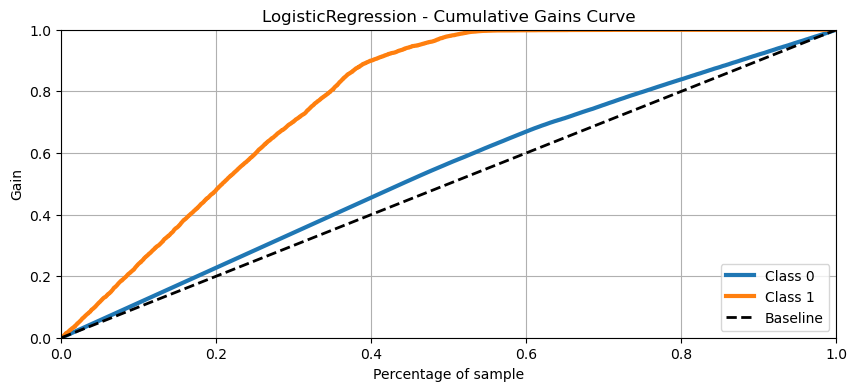

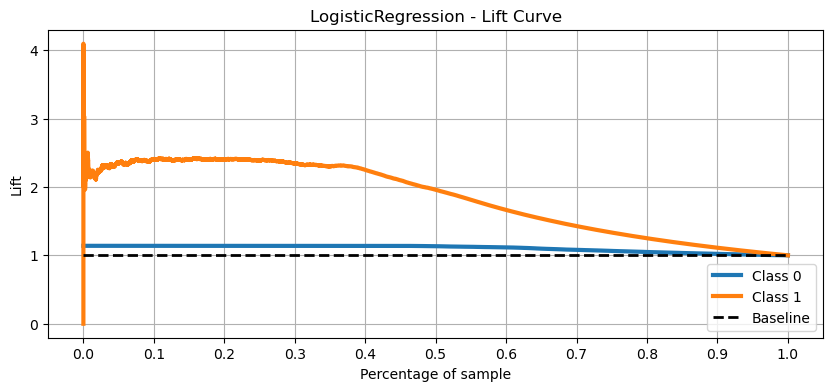

In [133]:
# Cumulative gain plot
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_lr, figsize=(10, 4) );
plt.title('LogisticRegression - Cumulative Gains Curve')
lr_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_lr, ax=ax);
#ax.set_ylim([0, 8.5])
plt.title('LogisticRegression - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])
plt.show()

### 8.1.2. XGBoost

In [134]:
# model definition
model_xgb = xgb.XGBClassifier( n_estimators=10,
                               eta=0.01,
                               max_depth=10,
                               subsample=0.7,
                               eval_metric = 'aucpr' )

# PS: not used "colsample_bytee=0.9" & "use_label_encoder = False"

# model fit
model_xgb.fit( x_train_prep, y_train_prep )

# model predict
yhat_xgb = model_xgb.predict_proba( x_validation_prep)
yhat_xgb_1 = model_xgb.predict( x_validation_prep)

# Metrics
xgb_result = single_validation_metrics( 
                type(model_xgb).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_xgb, yhat_xgb_1 ) 
xgb_result

TOT=50817  TP=4385  FP=11064  FN=1821  TN=33547
TOT=20000  TP=4385  FP=11064  FN=988  TN=3563
TOT=40000  TP=4385  FP=11064  FN=1811  TN=22740


,Model Name,Accuracy,Precision,Recall,F1,cm.pos,cm.neg,Precision@20k,Recall@20k,F1@20k,cm.pos.20k,cm.neg.20k,Precision@40k,Recall@40k,F1@40k,cm.pos.40k,cm.neg.40k
0,XGBClassifier,74.6443,28.3837,70.6574,40.49873,TP=4385 FP=11064,FN=1821 TN=33547 TOT=50817,28.3837,81.6118,42.1189,TP=4385 FP=11064,FN=988 TN=3563 TOT=20k,28.3837,70.7715,40.5174,TP=4385 FP=11064,FN=1811 TN=22740 TOT=40k


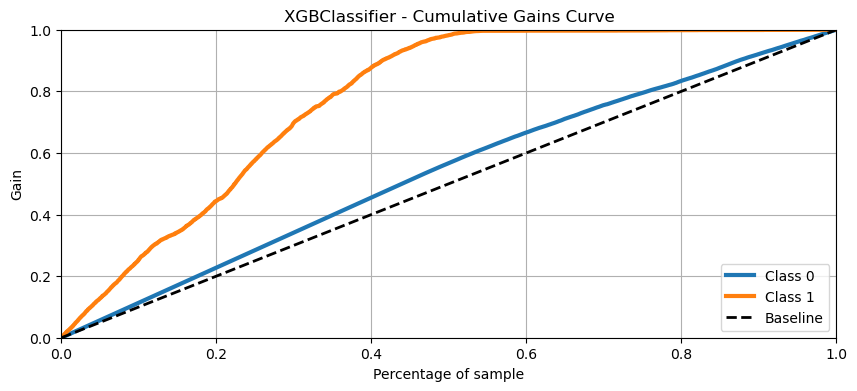

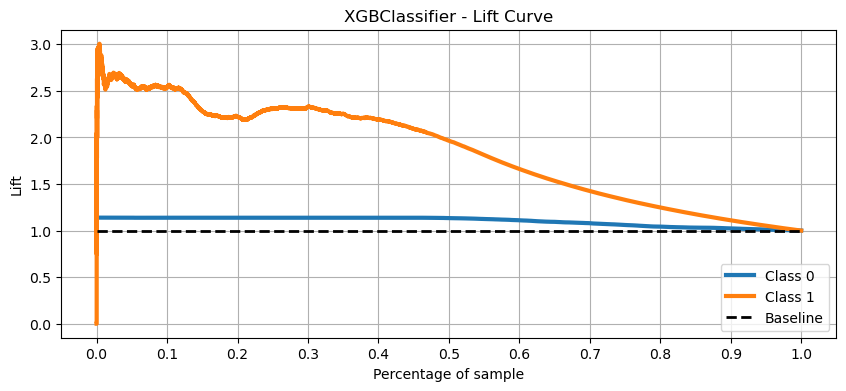

In [135]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_xgb, figsize=(10, 4) );
plt.title('XGBClassifier - Cumulative Gains Curve')
xgb_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_xgb, ax=ax);
#ax.set_ylim([0, 8.5])
plt.title('XGBClassifier - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.3. KNN

In [136]:
x_train_prep.columns

Index(['age_rbf_24', 'annual_premium', 'annual_premium_f1',
       'annual_premium_f2', 'driving_license', 'gender_Female', 'gender_Male',
       'policy_sales_channel', 'policy_sales_channel_importance',
       'previously_insured', 'region_code', 'vehicle_age_bellow_1_year',
       'vehicle_age_between_1_2_years', 'vehicle_damage', 'vintage'],
      dtype='object')

In [137]:
knn_out = KNN_optimization( 53, 53, in_metric='manhattan' )

53 
k=53  F1=0.35586075605112866 
KNN - best Precision .. k: 53
KNN - best F1 ......... k: 53
KNN - best Recall ..... k: 53


In [138]:
# prediction
yhat_knn = knn_out[0].predict_proba( x_validation_prep )
yhat_knn_1 = knn_out[0].predict( x_validation_prep )

# Metrics
knn_result = single_validation_metrics( 
                type(knn_out[0]).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_knn, yhat_knn_1 ) 
knn_result

TOT=50817  TP=2617  FP=5885  FN=3589  TN=38726
TOT=20000  TP=2617  FP=5885  FN=2862  TN=8636
TOT=40000  TP=2617  FP=5885  FN=3578  TN=27920


,Model Name,Accuracy,Precision,Recall,F1,cm.pos,cm.neg,Precision@20k,Recall@20k,F1@20k,cm.pos.20k,cm.neg.20k,Precision@40k,Recall@40k,F1@40k,cm.pos.40k,cm.neg.40k
0,KNeighborsClassifier,81.3566,30.781,42.1689,35.586076,TP=2617 FP=5885,FN=3589 TN=38726 TOT=50817,30.781,47.7642,37.4365,TP=2617 FP=5885,FN=2862 TN=8636 TOT=20k,30.781,42.2437,35.6127,TP=2617 FP=5885,FN=3578 TN=27920 TOT=40k


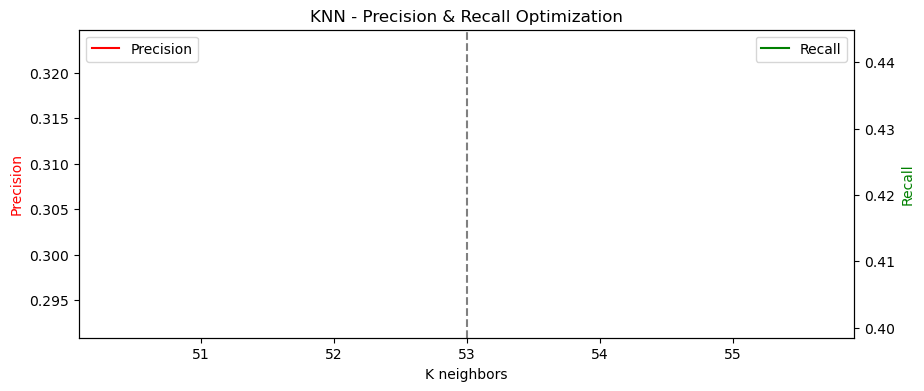

In [139]:
# Plotting  two Y axes
knn_BestClassifier = knn_out[0]
best_k_pr = knn_out[1]
Precision_list = knn_out[3]
Recall_list = knn_out[4]
KK = knn_out[5]

# Plotting  two Y axes
fig, ax1 = plt.subplots(figsize=(10, 4))
plt.title('KNN - Precision & Recall Optimization')
# First Y: precision
ax1.plot( KK, Precision_list,  'r-', label='Precision' )
ax1.set_xlabel('K neighbors')
ax1.set_ylabel('Precision', color='r')
ax1.legend(loc='upper left')
ax1.axvline(x=best_k_pr, color='gray', linestyle='--')
ax1.annotate(f"x = {best_k_pr}", xy=(best_k_pr+6, (min(Precision_list) + max(Precision_list)) / 2), fontsize=8, ha='center')
# Second Y: recall
ax2 = ax1.twinx()
ax2.plot( KK, Recall_list,  'g-', label='Recall')
ax2.set_ylabel('Recall', color='g')
ax2.legend(loc='upper right')
plt.show()

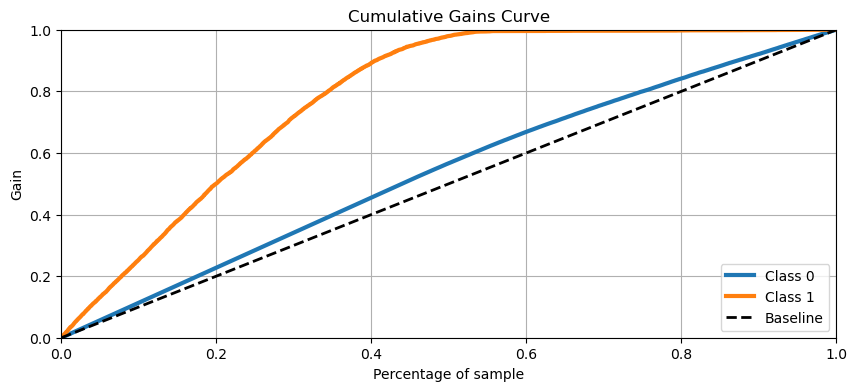

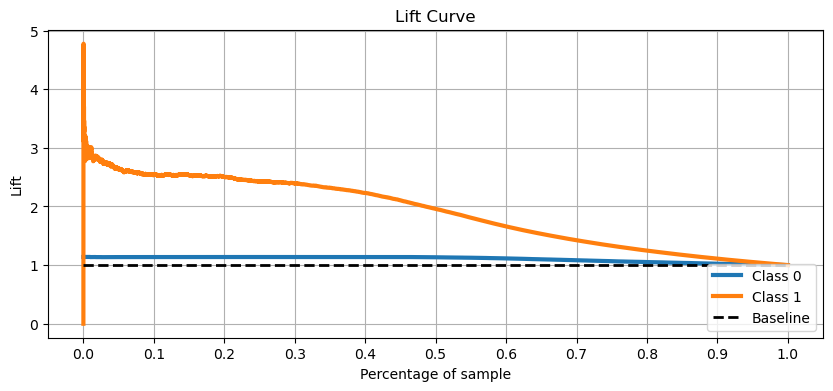

In [140]:
# Metric: cumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_knn, figsize=(10, 4) );
knn_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_knn, ax=ax);
#ax.set_ylim([0, 5])
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.4. Random Forest

In [141]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
rf.fit( x_train_prep, y_train_prep )

# model predict
yhat_rf = rf.predict_proba( x_validation_prep)
yhat_rf_1 = rf.predict( x_validation_prep )

# Metrics
rf_result = single_validation_metrics( 
                type(rf).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_rf, yhat_rf_1 ) 
rf_result

TOT=50817  TP=1214  FP=2760  FN=4992  TN=41851
TOT=20000  TP=1214  FP=2760  FN=4161  TN=11865
TOT=40000  TP=1214  FP=2760  FN=4979  TN=31047


,Model Name,Accuracy,Precision,Recall,F1,cm.pos,cm.neg,Precision@20k,Recall@20k,F1@20k,cm.pos.20k,cm.neg.20k,Precision@40k,Recall@40k,F1@40k,cm.pos.40k,cm.neg.40k
0,RandomForestClassifier,84.7453,30.5486,19.5617,23.850688,TP=1214 FP=2760,FN=4992 TN=41851 TOT=50817,30.5486,22.586,25.9707,TP=1214 FP=2760,FN=4161 TN=11865 TOT=20k,30.5486,19.6028,23.8812,TP=1214 FP=2760,FN=4979 TN=31047 TOT=40k


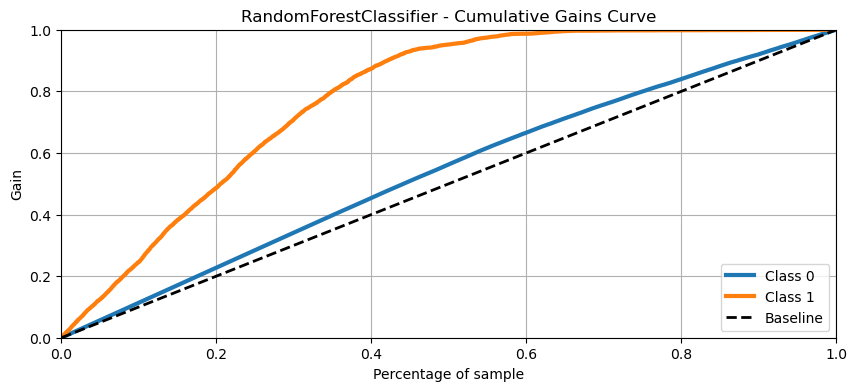

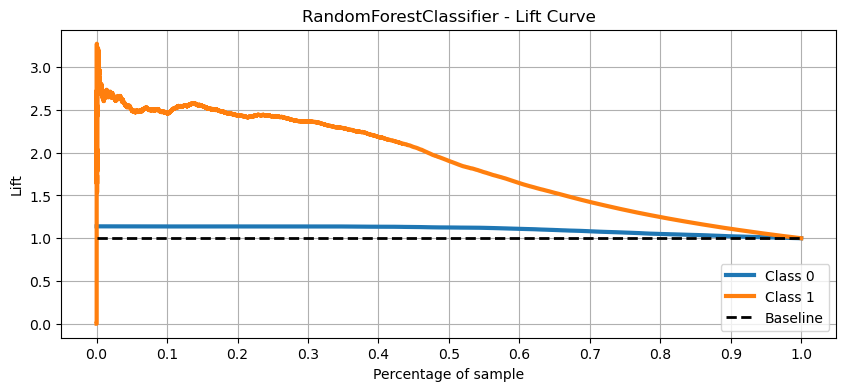

In [142]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_rf, figsize=(10, 4) );
plt.title('RandomForestClassifier - Cumulative Gains Curve')
rf_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_rf, ax=ax);
#ax.set_ylim([0, 4.5])
plt.title('RandomForestClassifier - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.5. Extra Trees

In [143]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et.fit( x_train_prep, y_train_prep )

# model predict
yhat_et = et.predict_proba( x_validation_prep)
yhat_et_1 = et.predict( x_validation_prep )

# Metrics
et_result = single_validation_metrics( 
                type(et).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_et, yhat_et_1 ) 
et_result.T

TOT=50817  TP=788  FP=1539  FN=5418  TN=43072
TOT=20000  TP=788  FP=1539  FN=4623  TN=13050
TOT=40000  TP=788  FP=1539  FN=5403  TN=32270


,0
Model Name,ExtraTreesClassifier
Accuracy,86.3097
Precision,33.8633
Recall,12.6974
F1,18.469471
cm.pos,TP=788 FP=1539
cm.neg,FN=5418 TN=43072 TOT=50817
Precision@20k,33.8633
Recall@20k,14.5629
F1@20k,20.367


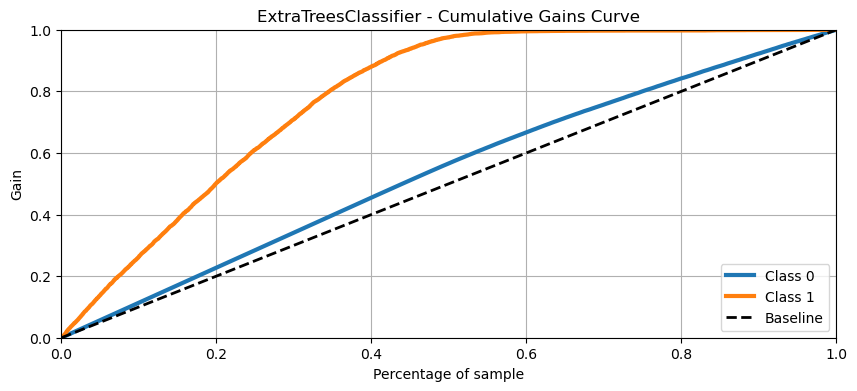

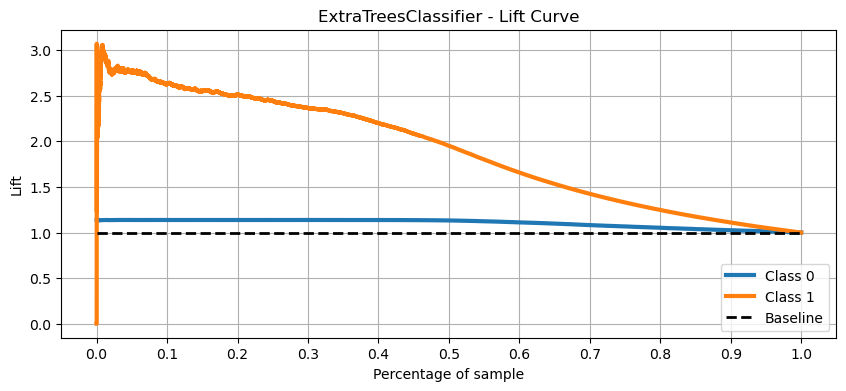

In [144]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_et, figsize=(10, 4) );
plt.title('ExtraTreesClassifier - Cumulative Gains Curve')
et_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_et, ax=ax);
#ax.set_ylim([0, 8.5])
plt.title('ExtraTreesClassifier - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.6. LightGBM

In [145]:
# model definition
lgb = LGBMClassifier( n_estimators=100, random_state=42, n_jobs=-1, verbose=-1 )

# model fit
lgb.fit( x_train_prep, y_train_prep )

# model predict
yhat_lgb = lgb.predict_proba( x_validation_prep)
yhat_lgb_1 = lgb.predict( x_validation_prep)

# Metrics
lgb_result = single_validation_metrics( 
                type(lgb).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_lgb, yhat_lgb_1 ) 
lgb_result

TOT=50817  TP=926  FP=3207  FN=5280  TN=41404
TOT=20000  TP=926  FP=3207  FN=2631  TN=13236
TOT=40000  TP=926  FP=3207  FN=4783  TN=31084


,Model Name,Accuracy,Precision,Recall,F1,cm.pos,cm.neg,Precision@20k,Recall@20k,F1@20k,cm.pos.20k,cm.neg.20k,Precision@40k,Recall@40k,F1@40k,cm.pos.40k,cm.neg.40k
0,LGBMClassifier,83.2989,22.405,14.921,17.912758,TP=926 FP=3207,FN=5280 TN=41404 TOT=50817,22.405,26.0332,24.0832,TP=926 FP=3207,FN=2631 TN=13236 TOT=20k,22.405,16.22,18.8173,TP=926 FP=3207,FN=4783 TN=31084 TOT=40k


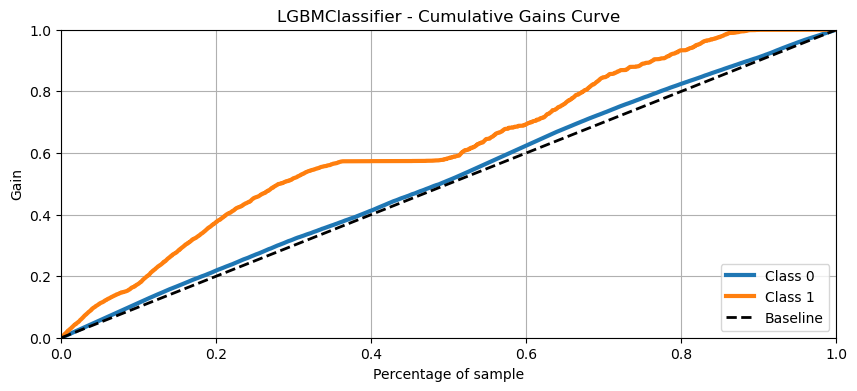

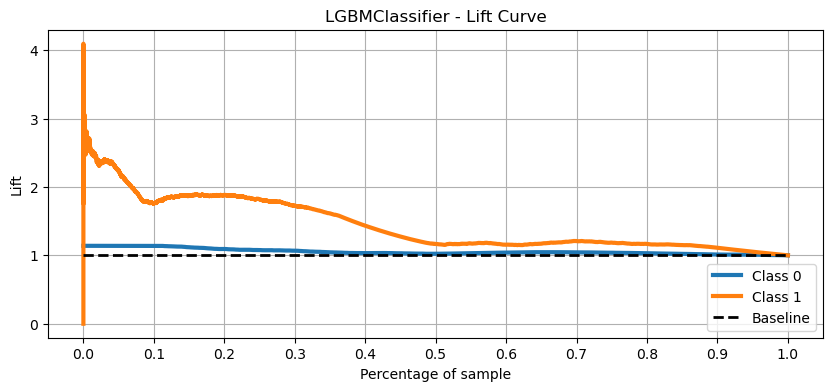

In [146]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_lgb, figsize=(10, 4) );
plt.title('LGBMClassifier - Cumulative Gains Curve')
lgbm_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_lgb, ax=ax);
#ax.set_ylim([0, 3.5])
plt.title('LGBMClassifier - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.7. Performance

In [147]:
# Single-validation Performance
sgl = pd.concat( [
        knn_result, lr_result, et_result, rf_result, xgb_result, lgb_result
    ] ).round(4).T.reset_index()
sgl.columns = [ 'metrics', 'knn', 'logistic reg.', 'extra trees', 'random forest', 'xgboost', 'LightGBM' ]
# Order columns by one metric
ordering_line = 3  # "Recall" metrics
#ordering_line = 2  # "Precision" metrics
col_metrics = sgl.iloc[:,0]
cols_ordered = sgl.iloc[:,1:].loc[ordering_line].sort_values(ascending=False).index
sgl = pd.concat( [col_metrics, sgl[cols_ordered]], axis=1 )

sgl

,metrics,logistic reg.,xgboost,knn,random forest,LightGBM,extra trees
0,Model Name,LogisticRegression,XGBClassifier,KNeighborsClassifier,RandomForestClassifier,LGBMClassifier,ExtraTreesClassifier
1,Accuracy,67.4892,74.6443,81.3566,84.7453,83.2989,86.3097
2,Precision,26.3428,28.3837,30.781,30.5486,22.405,33.8633
3,Recall,92.5395,70.6574,42.1689,19.5617,14.921,12.6974
4,F1,41.0112,40.4987,35.5861,23.8507,17.9128,18.4695
5,cm.pos,TP=5743 FP=16058,TP=4385 FP=11064,TP=2617 FP=5885,TP=1214 FP=2760,TP=926 FP=3207,TP=788 FP=1539
6,cm.neg,FN=463 TN=28553 TOT=50817,FN=1821 TN=33547 TOT=50817,FN=3589 TN=38726 TOT=50817,FN=4992 TN=41851 TOT=50817,FN=5280 TN=41404 TOT=50817,FN=5418 TN=43072 TOT=50817
7,Precision@20k,27.73,28.3837,30.781,30.5486,22.405,33.8633
8,Recall@20k,100.0,81.6118,47.7642,22.586,26.0332,14.5629
9,F1@20k,43.4197,42.1189,37.4365,25.9707,24.0832,20.367


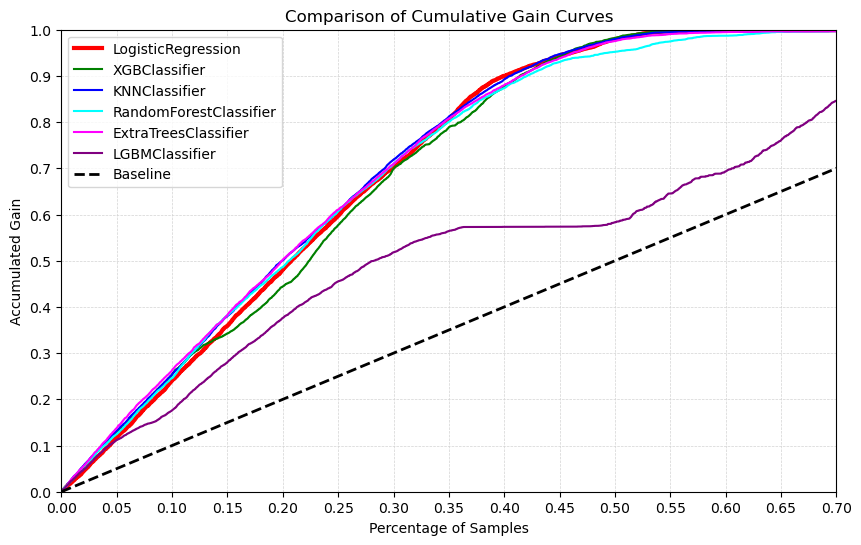

In [148]:
plt.figure(figsize=(10, 6))
plt.plot(lr_line[0], lr_line[1], label='LogisticRegression', color='red', lw=3)
plt.plot(xgb_line[0], xgb_line[1], label='XGBClassifier', color='green')
plt.plot(knn_line[0], knn_line[1], label='KNNClassifier', color='blue')
plt.plot(rf_line[0], rf_line[1], label='RandomForestClassifier', color='cyan')
plt.plot(et_line[0], et_line[1], label='ExtraTreesClassifier', color='magenta')
plt.plot(lgbm_line[0], lgbm_line[1], label='LGBMClassifier', color='purple')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Baseline', lw=2)

# Adicionar labels etc...
plt.title('Comparison of Cumulative Gain Curves')
plt.xlabel('Percentage of Samples')
plt.ylabel('Accumulated Gain')
plt.grid(True, which='both', axis='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.xlim([0.0, 0.7])
plt.ylim([0.0, 1.0])
plt.xticks([i/20.0 for i in range(15)])
plt.yticks([i/10.0 for i in range(11)])
plt.legend()

# Mostrar o gráfico
plt.show()


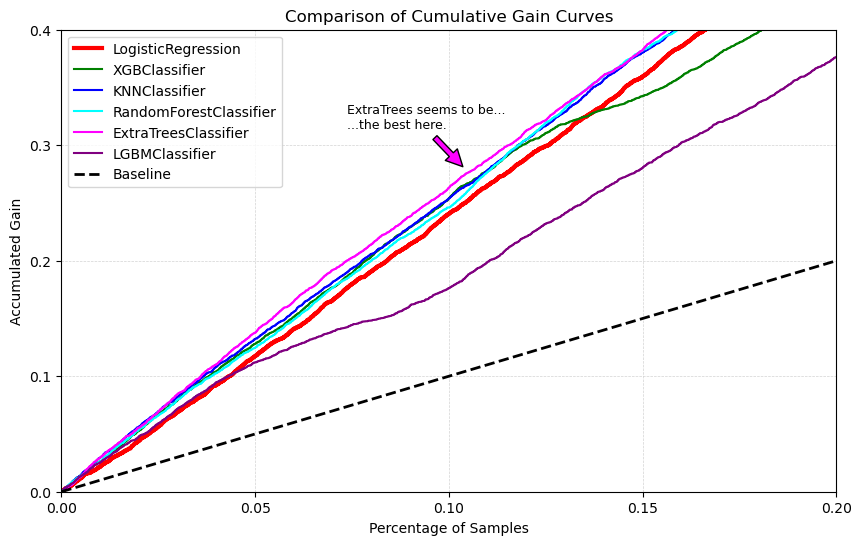

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(lr_line[0], lr_line[1], label='LogisticRegression', color='red', lw=3)
plt.plot(xgb_line[0], xgb_line[1], label='XGBClassifier', color='green')
plt.plot(knn_line[0], knn_line[1], label='KNNClassifier', color='blue')
plt.plot(rf_line[0], rf_line[1], label='RandomForestClassifier', color='cyan')
plt.plot(et_line[0], et_line[1], label='ExtraTreesClassifier', color='magenta')
plt.plot(lgbm_line[0], lgbm_line[1], label='LGBMClassifier', color='purple')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Baseline', lw=2)

# Adicionar labels etc...
plt.title('Comparison of Cumulative Gain Curves')
plt.xlabel('Percentage of Samples')
plt.ylabel('Accumulated Gain')
plt.grid(True, which='both', axis='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.xlim([0.0, 0.2])
plt.ylim([0.0, 0.4])
plt.xticks([i/20.0 for i in range(5)])
plt.yticks([i/10.0 for i in range(5)])
plt.annotate( 'ExtraTrees seems to be...\n...the best here.', 
             xy=(250,300), fontsize=9, xycoords='figure points' );
plt.annotate( '', xy=(0.52, 0.70), xycoords='axes fraction', 
              xytext=(0.48, 0.77), textcoords='axes fraction', 
              arrowprops=dict(facecolor='magenta', shrink=0.05));
plt.legend()

# Mostrar o gráfico
plt.show()


## 8.2. Cross-Validation

### 8.2.1. Logistic Regression

In [150]:
lr_cv_result = cross_validation( lr_model,
                                 x_train_val, y_train_val,
                                 5, cols_selected_boruta )

lr_cv_result

1 TOT=20000  TP=5583  FP=14417  FN=0  TN=0
TOT=40000  TP=5783  FP=16056  FN=429  TN=17732
2 TOT=20000  TP=5577  FP=14423  FN=0  TN=0
TOT=40000  TP=5835  FP=16169  FN=381  TN=17615
3 TOT=20000  TP=5554  FP=14446  FN=0  TN=0
TOT=40000  TP=5767  FP=16094  FN=449  TN=17690
4 TOT=20000  TP=5565  FP=14435  FN=0  TN=0
TOT=40000  TP=5761  FP=15908  FN=453  TN=17878
5 TOT=20000  TP=5599  FP=14401  FN=0  TN=0
TOT=40000  TP=5803  FP=16003  FN=411  TN=17783


,Model Name,Balanced Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Mean,F1 STD,cm.pos,cm.neg,...,cm.pos.20k,cm.neg.20k,Precision@40k Mean,Precision@40k STD,Recall@40k Mean,Recall@40k STD,F1@40k Mean,F1@40k STD,cm.pos.40k,cm.neg.40k
0,LogisticRegression,78.57547,26.51534,0.08,93.12852,0.43,41.2779,0.12,TP=5789 FP=16046,FN=427 TN=28554 TOT=254085,...,TP=5575 FP=14424,FN=0 TN=0 TOT=20k,26.51534,0.08,93.16746,0.43,41.28173,0.12,TP=5789 FP=16046,FN=424 TN=17739 TOT=40k


### 8.2.2. XGBoost

In [151]:
xgb_cv_result = cross_validation( model_xgb,
                                 x_train_val, y_train_val,
                                 5, cols_selected_boruta )

xgb_cv_result

1 TOT=20000  TP=4658  FP=12614  FN=682  TN=2046
TOT=40000  TP=4658  FP=12614  FN=1547  TN=21181
2 TOT=20000  TP=4498  FP=11350  FN=956  TN=3196
TOT=40000  TP=4498  FP=11350  FN=1712  TN=22440
3 TOT=20000  TP=4416  FP=11565  FN=927  TN=3092
TOT=40000  TP=4416  FP=11565  FN=1786  TN=22233
4 TOT=20000  TP=4321  FP=11100  FN=1034  TN=3545
TOT=40000  TP=4321  FP=11100  FN=1888  TN=22691
5 TOT=20000  TP=4519  FP=11346  FN=908  TN=3227
TOT=40000  TP=4519  FP=11346  FN=1687  TN=22448


,Model Name,Balanced Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Mean,F1 STD,cm.pos,cm.neg,...,cm.pos.20k,cm.neg.20k,Precision@40k Mean,Precision@40k STD,Recall@40k Mean,Recall@40k STD,F1@40k Mean,F1@40k STD,cm.pos.40k,cm.neg.40k
0,XGBClassifier,73.050663,27.89755,0.55,72.09908,1.8,40.21744,0.53,TP=4482 FP=11595,FN=1734 TN=33005 TOT=254085,...,TP=4482 FP=11595,FN=901 TN=3021 TOT=20k,27.89755,0.55,72.22241,1.81,40.2365,0.52,TP=4482 FP=11595,FN=1724 TN=22198 TOT=40k


### 8.2.3. KNN

In [152]:
knn_cv_result = cross_validation( knn_BestClassifier,
                                 x_train_val, y_train_val,
                                 5, cols_selected_boruta )

knn_cv_result

1 TOT=20000  TP=2623  FP=5802  FN=2890  TN=8685
TOT=40000  TP=2623  FP=5802  FN=3586  TN=27989
2 TOT=20000  TP=2538  FP=5851  FN=2932  TN=8679
TOT=40000  TP=2538  FP=5851  FN=3675  TN=27936
3 TOT=20000  TP=2612  FP=5825  FN=2897  TN=8666
TOT=40000  TP=2612  FP=5825  FN=3591  TN=27972
4 TOT=20000  TP=2557  FP=5775  FN=2972  TN=8696
TOT=40000  TP=2557  FP=5775  FN=3657  TN=28011
5 TOT=20000  TP=2581  FP=5712  FN=2954  TN=8753
TOT=40000  TP=2581  FP=5712  FN=3626  TN=28081


,Model Name,Balanced Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Mean,F1 STD,cm.pos,cm.neg,...,cm.pos.20k,cm.neg.20k,Precision@40k Mean,Precision@40k STD,Recall@40k Mean,Recall@40k STD,F1@40k Mean,F1@40k STD,cm.pos.40k,cm.neg.40k
0,KNeighborsClassifier,64.272856,30.83157,0.33,41.5345,0.52,35.39118,0.39,TP=2582 FP=5793,FN=3634 TN=38807 TOT=254085,...,TP=2582 FP=5793,FN=2929 TN=8695 TOT=20k,30.83157,0.33,41.58694,0.54,35.41018,0.4,TP=2582 FP=5793,FN=3627 TN=27997 TOT=40k


### 8.2.4. Random Forest

In [153]:
rf_cv_result = cross_validation( rf,
                                 x_train_val, y_train_val,
                                 5, cols_selected_boruta )

rf_cv_result

1 TOT=20000  TP=1027  FP=2136  FN=4368  TN=12469
TOT=40000  TP=1027  FP=2136  FN=5183  TN=31654
2 TOT=20000  TP=673  FP=1237  FN=3428  TN=14662
TOT=40000  TP=673  FP=1237  FN=5448  TN=32642
3 TOT=20000  TP=540  FP=1112  FN=3480  TN=14868
TOT=40000  TP=540  FP=1112  FN=5601  TN=32747
4 TOT=20000  TP=618  FP=1189  FN=4794  TN=13399
TOT=40000  TP=618  FP=1189  FN=5594  TN=32599
5 TOT=20000  TP=575  FP=1002  FN=3491  TN=14932
TOT=40000  TP=575  FP=1002  FN=5532  TN=32891


,Model Name,Balanced Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Mean,F1 STD,cm.pos,cm.neg,...,cm.pos.20k,cm.neg.20k,Precision@40k Mean,Precision@40k STD,Recall@40k Mean,Recall@40k STD,F1@40k Mean,F1@40k STD,cm.pos.40k,cm.neg.40k
0,RandomForestClassifier,54.025095,34.21088,1.51,11.04391,2.83,16.46864,2.87,TP=686 FP=1335,FN=5530 TN=43264 TOT=254085,...,TP=686 FP=1335,FN=3912 TN=14066 TOT=20k,34.21088,1.51,11.13801,2.79,16.58244,2.82,TP=686 FP=1335,FN=5471 TN=32506 TOT=40k


### 8.2.5. Extra Trees

In [154]:
et_cv_result = cross_validation( et,
                                 x_train_val, y_train_val,
                                 5, cols_selected_boruta )

et_cv_result

1 TOT=20000  TP=730  FP=1446  FN=4728  TN=13096
TOT=40000  TP=730  FP=1446  FN=5474  TN=32350
2 TOT=20000  TP=771  FP=1604  FN=4701  TN=12924
TOT=40000  TP=771  FP=1604  FN=5441  TN=32184
3 TOT=20000  TP=702  FP=1459  FN=4740  TN=13099
TOT=40000  TP=702  FP=1459  FN=5500  TN=32339
4 TOT=20000  TP=726  FP=1499  FN=4724  TN=13051
TOT=40000  TP=726  FP=1499  FN=5484  TN=32291
5 TOT=20000  TP=749  FP=1437  FN=4729  TN=13085
TOT=40000  TP=749  FP=1437  FN=5463  TN=32351


,Model Name,Balanced Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Mean,F1 STD,cm.pos,cm.neg,...,cm.pos.20k,cm.neg.20k,Precision@40k Mean,Precision@40k STD,Recall@40k Mean,Recall@40k STD,F1@40k Mean,F1@40k STD,cm.pos.40k,cm.neg.40k
0,ExtraTreesClassifier,54.246754,33.07772,0.72,11.83207,0.37,17.42545,0.43,TP=735 FP=1489,FN=5481 TN=43111 TOT=254085,...,TP=735 FP=1489,FN=4724 TN=13051 TOT=20k,33.07772,0.72,11.84902,0.37,17.44392,0.42,TP=735 FP=1489,FN=5472 TN=32303 TOT=40k


### 8.2.6. LightGBM

In [155]:
lgb_cv_result = cross_validation( lgb,
                                 x_train_val, y_train_val,
                                 5, cols_selected_boruta )

lgb_cv_result

1 TOT=20000  TP=798  FP=3099  FN=2734  TN=13369
TOT=40000  TP=798  FP=3099  FN=5415  TN=30688
2 TOT=20000  TP=1053  FP=3792  FN=2530  TN=12625
TOT=40000  TP=1053  FP=3792  FN=5160  TN=29995
3 TOT=20000  TP=908  FP=3856  FN=2632  TN=12604
TOT=40000  TP=908  FP=3856  FN=5305  TN=29931
4 TOT=20000  TP=1347  FP=4756  FN=2247  TN=11650
TOT=40000  TP=1347  FP=4756  FN=4869  TN=29028
5 TOT=20000  TP=1001  FP=3430  FN=2518  TN=13051
TOT=40000  TP=1001  FP=3430  FN=4879  TN=30690


,Model Name,Balanced Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Mean,F1 STD,cm.pos,cm.neg,...,cm.pos.20k,cm.neg.20k,Precision@40k Mean,Precision@40k STD,Recall@40k Mean,Recall@40k STD,F1@40k Mean,F1@40k STD,cm.pos.40k,cm.neg.40k
0,LGBMClassifier,53.969506,21.18652,1.27,16.42915,2.97,18.40489,2.14,TP=1021 FP=3786,FN=5195 TN=40813 TOT=254085,...,TP=1021 FP=3786,FN=2532 TN=12659 TOT=20k,21.18652,1.27,16.62012,2.97,18.53198,2.18,TP=1021 FP=3786,FN=5125 TN=30066 TOT=40k


### 8.2.7. Performance Table

In [156]:
# Cross-validation Performance
cvp = pd.concat( [
        knn_cv_result, lr_cv_result, et_cv_result, rf_cv_result, xgb_cv_result, lgb_cv_result
    ] ).round(8).T.reset_index()
cvp.columns = [ 'metrics', 'knn', 'logistic reg.', 'extra trees', 'random forest', 'xgboost', 'LightGBM' ]
# Order columns by one metric
ordering_line = 4  # "Recall Mean" metrics
#ordering_line = 2  # "Precision Mean" metrics
col_metrics = cvp.iloc[:,0]
cols_ordered = cvp.iloc[:,1:].loc[ordering_line].sort_values(ascending=False).index
cvp = pd.concat( [col_metrics, cvp[cols_ordered]], axis=1 )

cvp

,metrics,logistic reg.,xgboost,knn,LightGBM,extra trees,random forest
0,Model Name,LogisticRegression,XGBClassifier,KNeighborsClassifier,LGBMClassifier,ExtraTreesClassifier,RandomForestClassifier
1,Balanced Accuracy Mean,78.57547,73.050663,64.272856,53.969506,54.246754,54.025095
2,Precision Mean,26.51534,27.89755,30.83157,21.18652,33.07772,34.21088
3,Precision STD,0.08,0.55,0.33,1.27,0.72,1.51
4,Recall Mean,93.12852,72.09908,41.5345,16.42915,11.83207,11.04391
5,Recall STD,0.43,1.8,0.52,2.97,0.37,2.83
6,F1 Mean,41.2779,40.21744,35.39118,18.40489,17.42545,16.46864
7,F1 STD,0.12,0.53,0.39,2.14,0.43,2.87
8,cm.pos,TP=5789 FP=16046,TP=4482 FP=11595,TP=2582 FP=5793,TP=1021 FP=3786,TP=735 FP=1489,TP=686 FP=1335
9,cm.neg,FN=427 TN=28554 TOT=254085,FN=1734 TN=33005 TOT=254085,FN=3634 TN=38807 TOT=254085,FN=5195 TN=40813 TOT=254085,FN=5481 TN=43111 TOT=254085,FN=5530 TN=43264 TOT=254085


# 9. HYPERPARAMETER FINE TUNING

## 9.1. KNN Fine Tuning

In [157]:
# There was a time when KNN sounded like the best model...
#
# Test the following hyperparameters for "KNeighborsClassifier":
#  - weights: can be [ 'uniform', 'distance' ]
#  - metric: can be [ 'minkowski', 'euclidean', 'manhattan', 'chebyshev', 'mahalanobis' ]
#  - in case of metric='minkowski', make p = [ 3, 4, ... ]

wgt   = [ 'distance' ]
metr  = [ 'minkowski', 'euclidean', 'manhattan', 'chebyshev' ]
metr  = [  ] # debug: don't do a thing
hyp_p = [ 3, 4, 5 ]

for wg in wgt:
    for mtr in metr:
        if mtr == 'minkowski':
            p_vals = hyp_p
        else:
            p_vals = [ 1 ]
        for pv in p_vals:
            print('\n====================================================')
            print(f"Params:  weight={wg}   metric={mtr}   p={pv}")
            print('====================================================')
            knn_classifier = KNeighborsClassifier( 
                                n_neighbors = 55,
                                weights = wg,
                                metric = mtr,
                                p = pv
                            )
            result = cross_validation( knn_classifier, 
                                    x_train, y_train, 
                                    3, 
                                    data_preparation_models, True )
            print(result.T)


## 9.2. Winner Model Fine Tuning

In [158]:
# Define Optuna Objective Function
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

def objective_rf( trial ):

    lr_model = lm.LogisticRegression(
                class_weight='balanced',
                #solver=trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga']),
                solver='lbfgs',
                #penalty=trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet', None]),
                penalty='l2',
                #l1_ratio=trial.suggest_float('l1_ratio', 0, 1), # for "elasticnet" only
                #C=0.1,
                C=trial.suggest_float('C', 3.946277, 3.946278, log=True),
                max_iter=200
                #max_iter=trial.suggest_int("max_iter", 50, 500, step=50)
    )

    result = cross_validation( lr_model,
                               x_train_val, y_train_val,
                               3, cols_selected_boruta )
    
    #print(result.T)

    return result['F1@20k Mean'][0]

#......... Results:
# BEST F1=45.76209 - for: solver='lbfgs',     penalty='l2',         max_iter=200, C=3.946277626773563
# BEST F1=45.72845 - for: solver='liblinear', penalty='l1',         max_iter=200, C=2.1347370839256246
# BEST F1=45.71260 - for: solver='liblinear', penalty='l2',         max_iter=200, C=4.858950038787912
# BEST F1=45.71853 - for: solver='saga',      penalty='l1',         max_iter=200, C=5.067677476450704
# BEST F1=45.70665 - for: solver='saga',      penalty='l2',         max_iter=200, C=5.81821119388984
# BEST F1=45.71261 - for: solver='saga',      penalty='elasticnet', max_iter=200, C=1.5158092856480454, l1_ratio=0.8884491391644332
# BEST F1=45.72250 - for: solver='saga',      penalty=None,         max_iter=200, C=2.4557991296986152


In [159]:
# 
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=2)

print('Best hyperparameters:', study.best_params)
print('Best result.........:', study.best_value)


[I 2024-09-20 09:48:48,556] A new study created in memory with name: no-name-eb22e700-5188-4741-8f24-6aee17b6ea86


1 TOT=20000  TP=5979  FP=14021  FN=0  TN=0
TOT=40000  TP=9662  FP=26709  FN=322  TN=3307
2 TOT=20000  TP=5913  FP=14087  FN=0  TN=0
TOT=40000  TP=9578  FP=26551  FN=387  TN=3484
3 

[I 2024-09-20 09:54:57,769] Trial 0 finished with value: 45.76209 and parameters: {'C': 3.9462776071175654}. Best is trial 0 with value: 45.76209.


TOT=20000  TP=5910  FP=14090  FN=0  TN=0
TOT=40000  TP=9689  FP=26847  FN=313  TN=3151
1 TOT=20000  TP=5979  FP=14021  FN=0  TN=0
TOT=40000  TP=9662  FP=26709  FN=322  TN=3307
2 TOT=20000  TP=5913  FP=14087  FN=0  TN=0
TOT=40000  TP=9578  FP=26551  FN=387  TN=3484
3 

[I 2024-09-20 10:01:10,985] Trial 1 finished with value: 45.76209 and parameters: {'C': 3.9462774063868276}. Best is trial 0 with value: 45.76209.


TOT=20000  TP=5910  FP=14090  FN=0  TN=0
TOT=40000  TP=9689  FP=26847  FN=313  TN=3151
Best hyperparameters: {'C': 3.9462776071175654}
Best result.........: 45.76209


In [160]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(template='plotly_dark', title='<b>Slice Plot', title_x=0.2)
fig.show()

## 9.3. Winner Model - test dataset

- The idea is: retrain the winner model with train+val dataset, then evaluate using test dataset

In [161]:
# Model defined: let's train it with both TRAIN+VAL dataframes & apply to TEST dataframe
final_model = lm.LogisticRegression(
                class_weight='balanced',
                solver='lbfgs',
                penalty='l2',
                C=3.946277626773563,
                max_iter=200
)

In [162]:
# (6.1) Prepare "train_val" dataset, as in 6.1

# Simple conversion of "vehicle_damage", "vehicle_age" and "annual_premium"
x_train_val = data_preparation_models.simple_conversion_of_categorical_features(x_train_val)
x_test_prep = data_preparation_models.simple_conversion_of_categorical_features(x_test)

# Fit to create (& apply) econdings
x_train_val_prep = data_preparation_models.DataFitting(x_train_val, y_train_val)
y_train_val_prep = y_train_val  # readability

# transform
x_test_prep = data_preparation_models.DataTransforming(x_test_prep)
y_test_prep = y_test

# (6.2) Delete all ROWS in 'train_val' where 'annual_premium_f3' <> 0
aux = x_train_val_prep
aux['response'] = y_train_val_prep
aux = aux[ (aux['annual_premium_f3'] == 0) ]
x_train_val_prep = aux.drop( 'response', axis=1 )
y_train_val_prep = aux['response'].copy()

# (6.3) Delete 'annual_premium_f3' COLUMN in train_val & test
x_train_val_prep = x_train_val_prep.drop( 'annual_premium_f3', axis=1 )
x_test_prep = x_test_prep.drop( 'annual_premium_f3', axis=1 )

# (6.4) Solution used: SMOTE + Tomek
x_train_val_prep, y_train_val_prep = SMOTETomek(random_state=42).fit_resample(x_train_val_prep, y_train_val_prep)

( x_train_val_prep.shape, y_train_val_prep.shape, x_test_prep.shape, y_test_prep.shape )

((400332, 19), (400332,), (127024, 19), (127024,))

In [163]:
# train+val model
x_train_val_prep = x_train_val_prep[ cols_selected_boruta ]
x_test_prep = x_test_prep[ cols_selected_boruta ]
final_model.fit( x_train_val_prep, y_train_val_prep )

# model prediction
yhat_final_model = final_model.predict_proba( x_test_prep )
yhat_final_model_1 = final_model.predict( x_test_prep )

In [164]:
# Metrics
final_result = single_validation_metrics( 
                type(final_model).__name__, 
                x_test_prep, y_test_prep,
                yhat_final_model, yhat_final_model_1 ) 
final_result.T

TOT=127024  TP=14581  FP=40267  FN=1044  TN=71132
TOT=20000  TP=5959  FP=14041  FN=0  TN=0
TOT=40000  TP=11543  FP=28457  FN=0  TN=0


,0
Model Name,LogisticRegression
Accuracy,67.4778
Precision,26.5844
Recall,93.3184
F1,41.380387
cm.pos,TP=14581 FP=40267
cm.neg,FN=1044 TN=71132 TOT=127024
Precision@20k,29.795
Recall@20k,100.0
F1@20k,45.9109


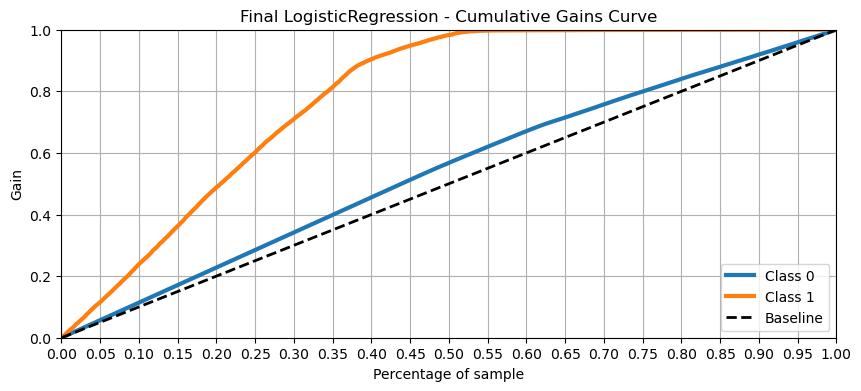

In [165]:
# Cumulative gain plot
skplt.metrics.plot_cumulative_gain( y_test_prep, yhat_final_model, figsize=(10, 4) );
plt.title('Final LogisticRegression - Cumulative Gains Curve')
plt.xticks([i/20.0 for i in range(21)])
plt.show()

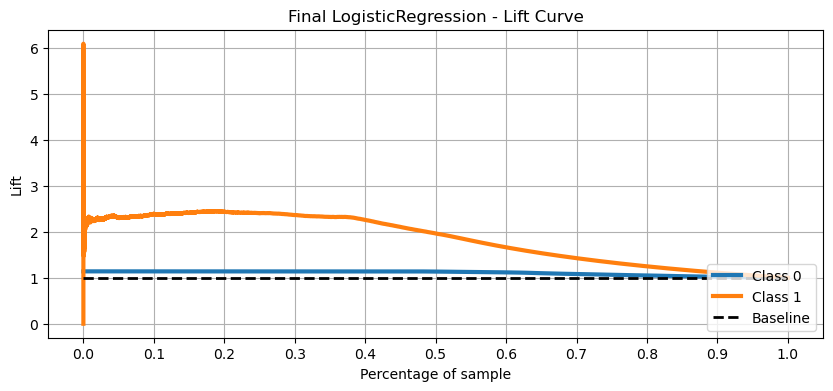

In [166]:
# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_test_prep, yhat_final_model, ax=ax);
#ax.set_ylim([0, 8.5])
plt.title('Final LogisticRegression - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])
plt.show()

# 10. PERFORMANCE EVALUATION

## 10.1. Prepare data

In [167]:
# Effectively invoiced contracts
df10 = x_test_prep.copy()
df10['response'] = y_test_prep
df10['prediction'] = yhat_final_model_1
df10['predict_proba'] = yhat_final_model[:, 1].tolist()
df10['annual_premium_contracted'] = x_test['annual_premium']
df10['annual_premium_contracted'] = ( df10
            .apply( lambda x: x['response'] * x['annual_premium_contracted'], axis=1 ) )
df10.shape

(127024, 19)

## 10.2. Business Performance

- TASK: compare results to the "status quo"
- Status quo: randomly chosen 20k (& 40k) potential clients (probably: 12,26%)
- ML performance: from the first 20k (& 40k) ordered potential clients

In [168]:
total_population = df10.shape[0]
total_pop_interested = np.sum( df10['response'] )
total_revenue = np.sum( df10['annual_premium_contracted'] )
perc = 100 * total_pop_interested / total_population
print( f"Total population tested...........: {total_population}" )
print( f"Total popupation interested.......: {total_pop_interested}  ({perc:.2f}%)" )
print( f"Total revenue (health-insurance)..: {total_revenue:15,.2f}" )

Total population tested...........: 127024
Total popupation interested.......: 15625  (12.30%)
Total revenue (health-insurance)..:  493,804,649.00


### business performance at 20k

In [169]:
# (1) STATUS-QUO: randomly choosing 20.000 potential clients to receive an offer
#     - Calculus using average values (see sections 1.3.2 & 1.3.4):
#     - Considering (I) premium per contract = average(annual_premium) . . . . = $30.564,39
#     -             (II) percentage of acceptance (in theory) = 46.710/381.109 = 12,26%
#     - Revenue @20k = 12,26% x 20.000 x $30.564,39 =  $74.943.884
#     - Revenue @40k = 12,26% x 40.000 x $30.564,39 = $149.887.769

df_statusquo = df10.sample(20000)
num_of_success_statusquo = np.round( np.sum(df_statusquo['response']), 2 )
# Percentage of aceptance
val = 100 * num_of_success_statusquo / df_statusquo.shape[0]
num_of_success_statusquo_p = np.round( val, 2 )
# Premium values (considering "Annual_Premium" as proxy)
total_revenue_statusquo = np.sum(df_statusquo['annual_premium_contracted'])

In [170]:
# (2) Average Machine Learning Model Results (in theory / in average):
#     - Considering model performance = Precision * Recall = 0,2956 * 1
#     - Total revenue @20k = 0,2983 x 20.000 x $30.564,39 = $180.696.674
#     - Revenue raised in: $105.752.790 (+141%)

df_ml_20k_case = df10.sort_values('predict_proba', ascending=False)
df_ml_20k_case = df_ml_20k_case.head(20000)
num_of_success_ml = np.round( np.sum(df_ml_20k_case['response']), 2 )

# Percentage of aceptance
val = 100 * num_of_success_ml / df_ml_20k_case.shape[0]
num_of_success_ml_p = np.round( val, 2 )
# Premium values (considering "Annual_Premium" as proxy)
total_revenue_ml = np.sum(df_ml_20k_case['annual_premium_contracted'])


In [171]:
print( "STATUS-QUO 20k" )
print( f"N# of contracts sold: {num_of_success_statusquo} ({num_of_success_statusquo_p}%) of 20k" )
print( "Total Revenue: ${:15,.2f}".format(total_revenue_statusquo) )

print( "\nML 20k RESULTS" )
print( f"N# of contracts sold: {num_of_success_ml} ({num_of_success_ml_p}%) of 20k" )
dif = num_of_success_ml - num_of_success_statusquo
difp = 100 * dif / num_of_success_statusquo
print( "Gain: {}  ({:.1f}%)".format(dif, difp) )
print( "Total Revenue: ${:15,.2f}".format(total_revenue_ml) )
dif = total_revenue_ml - total_revenue_statusquo
difp = 100 * dif / total_revenue_statusquo
print( "Revenue Gain: {:15,.2f}  ({:.1f}%)".format(dif, difp) )

STATUS-QUO 20k
N# of contracts sold: 2437 (12.18%) of 20k
Total Revenue: $  77,562,978.00

ML 20k RESULTS
N# of contracts sold: 5959 (29.8%) of 20k
Gain: 3522  (144.5%)
Total Revenue: $ 217,376,323.00
Revenue Gain:  139,813,345.00  (180.3%)


### business performance at 40k

In [172]:
# (1) STATUS-QUO: randomly choosing 40.000 potential clients to receive an offer
#     - Revenue @40k = 12,26% x 40.000 x $30.564,39 = $149.887.769

df_statusquo = df10.sample(40000)
num_of_success_statusquo = np.round( np.sum(df_statusquo['response']), 2 )
# Percentage of aceptance
val = 100 * num_of_success_statusquo / df_statusquo.shape[0]
num_of_success_statusquo_p = np.round( val, 2 )
# Premium values (considering "Annual_Premium" as proxy)
total_revenue_statusquo = np.sum(df_statusquo['annual_premium_contracted'])

In [173]:
# (2) Average Machine Learning Model Results (in theory / in average):
#     - Considering model performance = Precision * Recall = 0,2899 * 1
#     - Total revenue @40k = 0,2899 x 40.000 x $30.564,39 = $354.424.666
#     - Revenue raised in: $204.536.897 (+136%)

df_ml_40k_case = df10.sort_values('predict_proba', ascending=False)
df_ml_40k_case = df_ml_40k_case.head(40000)
num_of_success_ml = np.round( np.sum(df_ml_40k_case['response']), 2 )

# Percentage of aceptance
val = 100 * num_of_success_ml / df_ml_40k_case.shape[0]
num_of_success_ml_p = np.round( val, 2 )
# Premium values (considering "Annual_Premium" as proxy)
total_revenue_ml = np.sum(df_ml_40k_case['annual_premium_contracted'])

In [174]:
print( "STATUS-QUO 40k" )
print( f"N# of contracts sold: {num_of_success_statusquo} ({num_of_success_statusquo_p}%) of 40k" )
print( "Total Revenue: ${:15,.2f}".format(total_revenue_statusquo) )

print( "\nML 40k RESULTS" )
print( f"N# of contracts sold: {num_of_success_ml} ({num_of_success_ml_p}%) of 40k" )
dif = num_of_success_ml - num_of_success_statusquo
difp = 100 * dif / num_of_success_statusquo
print( "Gain: {}  ({:.1f}%)".format(dif, difp) )
print( "Total Revenue: ${:15,.2f}".format(total_revenue_ml) )
dif = total_revenue_ml - total_revenue_statusquo
difp = 100 * dif / total_revenue_statusquo
print( "Revenue Gain: {:15,.2f}  ({:.1f}%)".format(dif, difp) )

STATUS-QUO 40k
N# of contracts sold: 4859 (12.15%) of 40k
Total Revenue: $ 154,057,457.00

ML 40k RESULTS
N# of contracts sold: 11543 (28.86%) of 40k
Gain: 6684  (137.6%)
Total Revenue: $ 389,342,460.00
Revenue Gain:  235,285,003.00  (152.7%)


### 80% business performance

In [175]:
# Order by predict_proba
y_probs_class_1 = yhat_final_model[:, 1]
order = np.argsort(y_probs_class_1)[::-1]
y_true_sorted = np.array(y_test_prep)[order]

# Compute cumulative gain
cumulative_true_positives = np.cumsum(y_true_sorted == 1)
percentages = np.arange(1, len(y_test_prep) + 1) / len(y_test_prep)
gains_class_1 = cumulative_true_positives / cumulative_true_positives[-1]

# cummulative gain of 80%
index_class_1 = np.where(gains_class_1 >= 0.8)[0][0]
percentage_at_gain_1 = percentages[index_class_1]
total_points_to_test = 127024 * percentage_at_gain_1

# print...
print("To reach 80% of cummulative gain:")
print(f"Samples needed: {total_points_to_test:7,.0f} ({percentage_at_gain_1*100:.2f}%)")


To reach 80% of cummulative gain:
Samples needed:  43,649 (34.36%)


### Plotting results

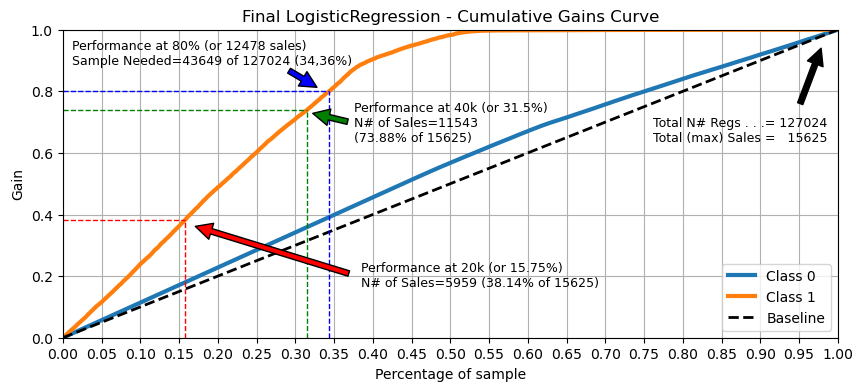

In [176]:
# Cumulative gain plot
skplt.metrics.plot_cumulative_gain( y_test_prep, yhat_final_model, figsize=(10, 4) );
plt.title('Final LogisticRegression - Cumulative Gains Curve')
plt.xticks([i/20.0 for i in range(21)])

plt.annotate( 'Total N# Regs . . .= 127024\nTotal (max) Sales =   15625', 
             xy=(470,180), fontsize=9, xycoords='figure points' );
plt.annotate( '', xy=(0.98, 0.95), xycoords='axes fraction', 
              xytext=(0.95, 0.75), textcoords='axes fraction', 
              arrowprops=dict(facecolor='black', shrink=0.05));
# 20k-case: eixo.x: 20k/127k = 15,745%  -  eixo.y: 5959/15625 = 0,381376
plt.axhline( 0.3814, 0, 0.15745, color='red', ls='--', lw=1 )
plt.axvline( 0.15745, 0, 0.3814, color='red', ls='--', lw=1 )
plt.annotate( 'Performance at 20k (or 15.75%)\nN# of Sales=5959 (38.14% of 15625)', 
             xy=(260,75), fontsize=9, xycoords='figure points' );
plt.annotate( '', xy=(0.16, 0.37), xycoords='axes fraction', 
              xytext=(0.38, 0.20), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05));
# 40k-case: eixo.x: 40k/127k = 31,490%  -  eixo.y: 11543/15625 = 0,738752
plt.axhline( 0.7388, 0, 0.3149, color='green', ls='--', lw=1 )
plt.axvline( 0.3149, 0, 0.7388, color='green', ls='--', lw=1 )
plt.annotate( 'Performance at 40k (or 31.5%)\nN# of Sales=11543\n(73.88% of 15625)', 
             xy=(255,180), fontsize=9, xycoords='figure points' );
plt.annotate( '', xy=(0.32, 0.73), xycoords='axes fraction', 
              xytext=(0.37, 0.70), textcoords='axes fraction', 
              arrowprops=dict(facecolor='green', shrink=0.05));
# 80% case: eixo.x: 0,3436  -  eixo.y: 0,80
plt.axhline( 0.8, 0, 0.3436, color='blue', ls='--', lw=1 )
plt.axvline( 0.3436, 0, 0.8, color='blue', ls='--', lw=1 )
plt.annotate( 'Performance at 80% (or 12478 sales)\nSample Needed=43649 of 127024 (34,36%)', 
             xy=(52,235), fontsize=9, xycoords='figure points' );
plt.annotate( '', xy=(0.33, 0.81), xycoords='axes fraction', 
              xytext=(0.29, 0.87), textcoords='axes fraction', 
              arrowprops=dict(facecolor='blue', shrink=0.05));
plt.show()

# 11. DEPLOY TO PRODUCTION

## 11.1. Final Model (train+val+test)

- The idea is: retrain the winner model in train+val+test dataset, then deploy it.

In [177]:
# Using dataframe "df1" (as in section 1.2)
# ...where: df1 = train+validation+test
# ...and prepare as in section 6
X = df1.drop( 'response', axis=1 )
y = df1['response'].copy()

# Simple conversion of "vehicle_damage", "vehicle_age" and "annual_premium"
X = data_preparation_models.simple_conversion_of_categorical_features(X)

# Fit to create (& apply) econdings
X = data_preparation_models.DataFitting(X, y)

# Delete all ROWS where 'annual_premium_f3' <> 0
aux = X
aux['response'] = y
aux = aux[ (aux['annual_premium_f3'] == 0) ]
X = aux.drop( 'response', axis=1 )
y = aux['response'].copy()

# Delete 'annual_premium_f3' COLUMN
X = X.drop( 'annual_premium_f3', axis=1 )

# Solution used: SMOTE + Tomek
X, y = SMOTETomek(random_state=42).fit_resample(X, y)

# train model
X = X[ cols_selected_boruta ]
final_model.fit( X, y )


LogisticRegression(C=3.946277626773563, class_weight='balanced', max_iter=200)

In [178]:
# Read models & save to pickle files
trained_models = data_preparation_models.get_parameters()

# Save final winner model
pickle.dump( final_model, open( '../webapp/models/final_model.pkl', 'wb' ) )

# Save pickle files
pickle.dump( trained_models['mms_age'], open(                 '../webapp/models/age_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['age_rbf_24'], open(              '../webapp/models/age_rbf_24_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['age_rbf_44'], open(              '../webapp/models/age_rbf_44_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['ss0'], open(                     '../webapp/models/annual_premium_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['ss1'], open(                     '../webapp/models/annual_premium_scaler_f1.pkl', 'wb' ) )
pickle.dump( trained_models['ss2'], open(                     '../webapp/models/annual_premium_scaler_f2.pkl', 'wb' ) )
pickle.dump( trained_models['ohe_gender_enc'], open(          '../webapp/models/ohe_gender_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['fe_policy_sales_channel'], open( '../webapp/models/fe_policy_sales_channel_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['policy_importance_dict'], open(  '../webapp/models/fe_policy_sales_channel_dict.pkl', 'wb' ) )
pickle.dump( trained_models['looe_region_code_enc'], open(    '../webapp/models/looe_region_code_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['ohe_vehicle_age'], open(         '../webapp/models/ohe_vehicle_age_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['mms_vintage'], open(             '../webapp/models/vintage_scaler.pkl', 'wb' ) )
#pickle.dump( trained_models['ss3'], open(                     '../webapp/models/annual_premium_scaler_f3.pkl', 'wb' ) )
#print("\nFitted Parameters:")
#print(trained_models)

## 11.2. Health Insurance Class

In [179]:
class HealthInsurance:
    def __init__(self) -> None:
        #self.home_path = '../webapp/models/'
        self.home_path = 'C:/MeusEstudos/CURSOS TI/Em 2023 - ComunidadeDS/Projetos do Aluno/PA.04 health_insurance_priv/webapp/models/'
        # variáveis utilizadas na versão "atual": ver método "DataTransforming"
        self.age_scaler                       = pickle.load( open( self.home_path + 'age_scaler.pkl', 'rb' ) )
        self.age_rbf_24_scaler                = pickle.load( open( self.home_path + 'age_rbf_24_scaler.pkl', 'rb' ) )
        self.age_rbf_44_scaler                = pickle.load( open( self.home_path + 'age_rbf_44_scaler.pkl', 'rb' ) )
        self.annual_premium_scaler            = pickle.load( open( self.home_path + 'annual_premium_scaler.pkl', 'rb' ) )
        self.annual_premium_scaler_f1         = pickle.load( open( self.home_path + 'annual_premium_scaler_f1.pkl', 'rb' ) )
        self.annual_premium_scaler_f2         = pickle.load( open( self.home_path + 'annual_premium_scaler_f2.pkl', 'rb' ) )
        self.ohe_gender                       = pickle.load( open( self.home_path + 'ohe_gender_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler   = pickle.load( open( self.home_path + 'fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        self.policy_sales_chn_importance_dict = pickle.load( open( self.home_path + 'fe_policy_sales_channel_dict.pkl', 'rb' ) )
        self.looe_region_code_scaler          = pickle.load( open( self.home_path + 'looe_region_code_scaler.pkl', 'rb' ) )
        self.ohe_vehicle_age                  = pickle.load( open( self.home_path + 'ohe_vehicle_age_scaler.pkl', 'rb' ) )
        self.vintage_scaler                   = pickle.load( open( self.home_path + 'vintage_scaler.pkl', 'rb' ) )

        # variáveis constantes na versão "original" e descontinuados
        #self.annual_premium_scaler_f3         = pickle.load( open( self.home_path + 'annual_premium_scaler_f3.pkl', 'rb' ) )

    def data_cleaning( self, df1 ):
        # 1.0. Rename Columns to LowerCase
        df1.columns = df1.columns.str.lower()
        return df1

    def feature_engineering( self, df3 ):
        # 3.2. Create Features

        # Simple conversion of "vehicle_damage", "vehicle_age" and "annual_premium"

        # vehicle damage number
        df3['vehicle_damage'] = df3['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # vehicle age
        df3['vehicle_age'] = df3['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                            'between_1_2_years' if x == '1-2 Year'  else 
                                                            'bellow_1_year' )

        # From 'annual_premium', derive 3 features
        #    - feature.1: points with values between 2630-2675, others =ZERO
        #    - feature.2: values from 2675 to 74301 (or 83260), others =ZERO
        #    - feature.3: values above previous limits, others =ZERO
        df3['annual_premium_f1'] = df3['annual_premium'].apply( lambda x: 0.0 if x>2675.0 else x )
        df3['annual_premium_f2'] = df3['annual_premium'].apply( lambda x: x if x>2675.0 and x<74301.0 else 0.0 )
#       df3['annual_premium_f3'] = df3['annual_premium'].apply( lambda x: 0.0 if x<74301.0 else x )

        return df3

    def DataTransforming(self, in_df):

        # The code here is (almost) a mirror of Section 3.1: DataFitAndTransform.DataTransforming

        out_df = in_df.copy()

        # gender: encoding
        ohe_gender = self.ohe_gender.transform(out_df[['gender']])
        out_df = pd.concat([out_df, ohe_gender], axis=1).drop(columns=['gender'])

        # region_code: encoding
        out_df = self.looe_region_code_scaler.transform(out_df)

        # age: rescaling
        out_df['age_rbf_24'] = out_df['age'].map(self.age_rbf_24_scaler)
        out_df['age_rbf_44'] = out_df['age'].map(self.age_rbf_44_scaler)
        out_df['age'] = self.age_scaler.transform(out_df[['age']].values)
        
        # annual_premium: standardization
        out_df['annual_premium'] = self.annual_premium_scaler.transform(out_df[['annual_premium']].values)
        out_df['annual_premium_f1'] = self.annual_premium_scaler_f1.transform(out_df[['annual_premium_f1']].values)
        out_df['annual_premium_f2'] = self.annual_premium_scaler_f2.transform(out_df[['annual_premium_f2']].values)
#       out_df['annual_premium_f3'] = self.ss3.transform(out_df[['annual_premium_f3']].values)

        # policy_sales_channel: encoding
        out_df['policy_sales_channel_importance'] = out_df['policy_sales_channel'].map(self.policy_sales_chn_importance_dict)
        out_df['policy_sales_channel'] = out_df['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)

        # vehicle_age: encoding
        ohe = self.ohe_vehicle_age.transform(out_df[['vehicle_age']])
        out_df = pd.concat([out_df, ohe], axis=1).drop(columns=['vehicle_age'])

        # vintage: rescaling
        out_df['vintage'] = self.vintage_scaler.transform(out_df[['vintage']].values)

        return out_df

    def data_preparation( self, df6 ):

        # 6.2. Split data
        # treat "annual_premium_f3"
#        df6 = df6[ (df6['annual_premium_f3'] == 0) ]
#        df6 = df6.drop( 'annual_premium_f3', axis=1 )
        # Apply scalers&encodings to validation set
        df6 = df6.drop(columns=['response'], errors='ignore')
        df6 = self.DataTransforming(df6)

        # 6.3. Resampling: nop

        # 7.6. Manual feature selection
        cols_selected = ['age_rbf_24',
                        # 'age', 'age_rbf_44', 'vehicle_age_over_2_years',
                         'annual_premium', 'annual_premium_f1',
                         'annual_premium_f2', 'driving_license',
                         'gender_Female', 'gender_Male', 'policy_sales_channel',
                         'policy_sales_channel_importance', 'previously_insured',
                         'region_code', 'vehicle_age_bellow_1_year',
                         'vehicle_age_between_1_2_years',
                         'vehicle_damage', 'vintage']

        return df6[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):

        # DEBUG
        #test_data.to_csv('test_data.csv', index=False)

        # model prediction
        pred = model.predict_proba( test_data )

        # From predict_proba, get only col.1: probability of True-Response
        pred1 = [ col[1] for col in pred ]

        # join prediction into original data
        original_data['score'] = pred1

        # convert to JSON & return results
        return original_data.to_json( orient='records', date_format='iso' )


## 11.3. API Tester

In [180]:
# Import original dataset & apply all transformations...
import requests

# load test data (see STEP 5.0 INITIAL PROCEDURES)

df_raw = pd.read_csv('../data/raw/train.csv')

df_test_raw = pd.read_csv('../data/raw/test.csv')
#df_test_raw.sample(4).T

# choose some regs for prediction...
df_test = df_test_raw.sample(8)
# ...or: define one specific reg
df_test = df_test_raw.loc[ df_test_raw['id']==393529, : ].copy()

df_test.head()


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
12419,393529,Female,40,1,35.0,0,1-2 Year,Yes,40484.0,26.0,202


In [181]:
# Some fixed examples
casos = [ 251190, 84147, 79843, 91712, 191839, 310928, 8990, 295386, 
          72318, 327357, 244367, 329955, 173781, 348823, 81273, 173138, 
          347844, 131322, 114694, 270409, 130199, 117138, 127363, 251867,
          329466, 123665 ]

df_raw = pd.read_csv('../data/raw/train.csv')
df_raw['id'] = pd.Categorical( df_raw['id'], categories=casos, ordered=True )
df_test2 = df_raw[ df_raw['id'].isin(casos) ].sort_values('id')
df_test2 = df_test2.reset_index(drop=True)

# save to CSV
df_test2.to_csv('../data/df_test2.csv', index=False)
df_test2


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,251190,Male,37,1,28.0,0,1-2 Year,No,24228.0,30.0,25,0
1,84147,Male,35,1,28.0,0,1-2 Year,Yes,28789.0,154.0,156,1
2,79843,Male,69,1,28.0,0,1-2 Year,Yes,41046.0,122.0,127,0
3,91712,Male,35,1,28.0,0,1-2 Year,Yes,28816.0,124.0,166,0
4,191839,Female,44,1,28.0,0,1-2 Year,Yes,32343.0,124.0,63,1
5,310928,Female,51,1,28.0,0,1-2 Year,Yes,41779.0,124.0,33,0
6,8990,Male,30,1,3.0,0,< 1 Year,Yes,23555.0,156.0,103,1
7,295386,Female,48,1,28.0,0,1-2 Year,Yes,42612.0,26.0,288,0
8,72318,Male,55,1,28.0,0,1-2 Year,Yes,44982.0,124.0,113,0
9,327357,Female,70,1,28.0,0,> 2 Years,Yes,35099.0,124.0,57,0


In [182]:
# Convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

# MLMM: DEBUG - show formatted json
json_formatted_str = json.dumps( df_test.to_dict( orient='records' ), indent=2 )
print( json_formatted_str )

[
  {
    "id": 393529,
    "Gender": "Female",
    "Age": 40,
    "Driving_License": 1,
    "Region_Code": 35.0,
    "Previously_Insured": 0,
    "Vehicle_Age": "1-2 Year",
    "Vehicle_Damage": "Yes",
    "Annual_Premium": 40484.0,
    "Policy_Sales_Channel": 26.0,
    "Vintage": 202
  }
]


In [ ]:
# Before locally calling the API (next step), go to terminal, change path and run the handler...

# cd C:\MeusEstudos\CURSOS TI\Em 2023 - ComunidadeDS\Projetos do Aluno\PA.04 health_insurance_priv\webapp
# ...or simply: cd webapp

# > python handler.py
xxx

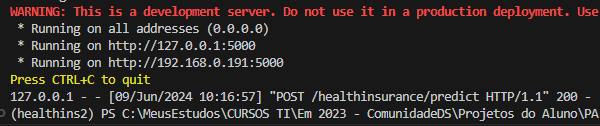

In [184]:
Image('../img/RunningHealthInsuranceHandler.png')

In [190]:
# API call
url = 'https://health-insurance-priv.onrender.com/healthinsurance/predict'
#url = 'http://127.0.0.1:5000/healthinsurance/predict'

# Kind of data to be sent
header = {'Content-type': 'application/json'}

r = requests.post( url, data=data, headers=header )
print( 'Status code {}'.format( r.status_code ) )

Status code 200


In [188]:
# Convert response from Json to DataFrame
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head().T

,0
id,393529
gender,Female
age,40
driving_license,1
region_code,35.0
previously_insured,0
vehicle_age,between_1_2_years
vehicle_damage,1
annual_premium,40484.0
policy_sales_channel,26.0


## 11.4. API Handler

In [ ]:
xxx   # rustic breakpoint

In [ ]:
# OBS: como testar no VS-Code??
# R: ver DS em Produção, módulo 10, video 47
# R: ver "propensão de compra", vídeo 9

import os
import pickle
import pandas as pd
from flask             import Flask, request, Response

# from "pasta.NomeDoArquivo" import "NomeDaClasse"
from healthinsurance.HealthInsurance  import HealthInsurance

#............... Load model
# before the loop, to make it faster...
model = pickle.load( open( 'models/final_model.pkl', 'rb' ) )
#model = pickle.load( open( 'C:/MeusEstudos/CURSOS TI/Em 2023 - ComunidadeDS/Projetos do Aluno/PA.04 health_insurance_priv/webapp/models/model_linear_regression.pkl', 'rb' ) )

#............... Init API
# REF: https://flask.palletsprojects.com/en/2.3.x/genindex/

app = Flask( __name__ )

#............... Create Endpoint Route
# REF: https://flask.palletsprojects.com/en/2.3.x/api/#flask.Blueprint.route
# predict function: that's the handler, activated when the API receives a request

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # is there any data in the received request?
        if isinstance( test_json, dict ): # unique dt
            # Convert 1-line Json to DataFrame
            test_raw = pd.DataFrame( test_json, index=[0] )

        else: # multiple dt
            # Convert N-lines Json to DataFrame
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate HealthInsurance class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction
        json_response = pipeline.get_prediction( model, test_raw, df3 )

        return json_response

    else:
        return Response( 'OK, but no data... {}', status=200, mimetype='application/json' )


#............... Run Flask API
if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( '0.0.0.0', port=port )
